In [13]:
import pandas as pd
import pytz
import smtplib 
from stockstats import StockDataFrame
from datetime import datetime
import datetime as dt
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as py
import urllib3
from binance.client import Client

In [14]:
def convert_datetime_timezone(dt, tz1, tz2):
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)
    dt = datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
    dt = dt.strftime('%Y-%m-%d %H:%M:%S')
    return dt

In [15]:
def scrap_binance_price(unit,interval):
    from binance.client import Client
    import pandas as pd
    import datetime
    import dateutil.parser

    api_key = 'LKa422RMjzx2tsXESIoSQ5qJzqi7LaC7iDFf9qdSrYjhJrZ6a8CcvOdniJWtfX13'
    api_secret = 'EvomPthpqwgTjeuqYFWBQM9HtE52Zeq6SuKrZSROqhd8g2tvbz086zVZqbbJGxsZ'

    client = Client(api_key, api_secret, {"verify": False, "timeout": 20})
    klines = client.get_historical_klines("BTCUSDT", unit, interval)

    data = pd.DataFrame();
    tradingdate = []
    openprice = []
    highprice = []
    lowprice = []
    closeprice = [] 
    for i in range(len(klines)):   
        time = datetime.datetime.utcfromtimestamp(klines[i][0]/1000).strftime('%Y-%m-%d %H:%M:%S')
        local_time = convert_datetime_timezone(time,'GMT','Australia/Adelaide')
        format_time = dateutil.parser.parse(local_time)
        tradingdate.append(format_time)
        openprice.append(float(klines[i][1]))
        highprice.append(float(klines[i][2]))
        lowprice.append(float(klines[i][3]))
        closeprice.append(float(klines[i][4]))
    data['datetime'] = tradingdate
    data['low'] = lowprice
    data['high'] = highprice
    data['open'] = openprice
    data['close'] = closeprice
    return data

In [16]:
def add_indicator(df):
    from stockstats import StockDataFrame
    df.reset_index(drop=True, inplace=True)
    df = StockDataFrame.retype(df)
    df['macd'] = df.get('macd') # calculate MACD
    #1: buy indicator
    #-1: sell indicator
    #0: no activity
    MACD = df
    point = []
    previous = 0
    current = 0
    #MACD_EMA_SHORT: default to 12
    #MACD_EMA_LONG: default to 26
    #MACD_EMA_SIGNAL: default to 9
    point.append(0)
    hasBitcoin = False
    for i in range(1,len(MACD)):
        previous = MACD['macdh'][i-1];
        current = MACD['macdh'][i];
        if(previous<0 and current >0 and hasBitcoin == False):
            point.append(1)
            hasBitcoin = True
        elif(previous>0 and current <0 and hasBitcoin == True):
            point.append(2)
            hasBitcoin = False
        else:
            point.append(0)
    MACD['indicator'] = point
    return MACD

In [17]:
def round_down(value, decimals):
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor


In [18]:
def email_notification(message):
    info = pd.read_csv('C:\\Users\\Ray\\Desktop\\E_Info.csv')
    gmailaddress = info['username'][0]
    gmailpassword = info['password'][0]
    mailToOne = info['addressOne'][0]
    mailToTwo = info['addressTwo'][0]
    msg = "Buy the Bitcoin"
    mailServer = smtplib.SMTP('smtp.gmail.com' , 587)
    mailServer.starttls()
    mailServer.login(gmailaddress , gmailpassword)
    #mailServer.sendmail(gmailaddress, mailToOne , message)
    #mailServer.sendmail(gmailaddress, mailToTwo , message)
    mailServer.quit()

In [19]:
def trading(treasure,test,money,bitcoin,bnb):
    
    initial_money = money
    initial_bitcoin = bitcoin
    initial_bnb = bnb
    #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(initial_bnb,6))
    A = []
    B = []
    C = []
    D = []
    E = []
    F = []
    G = []
    
    commission_rate = 0.00075
    
    test.reset_index(drop = True, inplace = True)
    comission_state = True
    balance = 100
    index = 0
    for i in range (len(test)):
        #set the current transfer index    
        index += 1
        #set the transaction rule
        #set the rule of buy bitcoin
        if(test['indicator'][i] == 1 and money > 0 and comission_state == True and bnb>0):
            if(money/test['close'][i]<balance):
                if(i<len(test)-1):
                    bitcoin_exchange = round_down(money/test['close'][i],6)
                    bnb -= money/18*commission_rate
                    balance -= bitcoin_exchange
                    bitcoin += bitcoin_exchange
                    money -= bitcoin_exchange*test['close'][i]
                    record[test['datetime'][i]] = 1
                else:
                    bitcoin_exchange = round_down(money/test['close'][i],6)
                    bnb -= money/18*commission_rate
                    balance -= bitcoin_exchange
                    bitcoin += bitcoin_exchange
                    money -= bitcoin_exchange*test['close'][i]
                    if(record.get(test['datetime'][i]) != 1):
                        record[test['datetime'][i]] = 1
                        email_notification("Buy the Bitcoin Right Now! -- 1 Hour Economic Model.")
                    #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(bitcoin_exchange,6))
            else:
                bitcoin += balance
                money -= balance*test['close'][i]
                bnb -= money/18*commission_rate
                comission_state = False
                record[test['datetime'][i]] = 1
                if(i<len(test)-1):
                    if(record.get(test['datetime'][i]) != 1):
                        record[test['datetime'][i]] = 1
                        email_notification("Buy the Bitcoin Right Now! -- 1 Hour Economic Model.")
                        #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(balance,6) )
        #set the rule of sell bitcoin
        elif(test['indicator'][i] == 2 and bitcoin>0 and bnb>0):
            if(i<len(test)-1):
                #each extraction opertion the system would charge commission fee
                bnb -= bitcoin*test['close'][i]/18*commission_rate
                money += bitcoin*test['close'][i]
                bitcoin = 0
                record[test['datetime'][i]] = 2
            else:              
                #each extraction opertion the system would charge commission fee
                bnb -= bitcoin*test['close'][i]/18*commission_rate
                money += bitcoin*test['close'][i]
                bitcoin = 0
                if(record.get(test['datetime'][i]) != 2):
                    record[test['datetime'][i]] = 2
                    email_notification("Sell the Bitcoin Right Now! -- 1 Hour Economic Model.")
                #client.order_market_sell(symbol = 'BTCUSDT',quantity = round_down(bitcoin,6))
        #the system would run 24h daily 
        if(index>=24*4):
            index = 0
            balance = 100
            comission_state = True
            
        A.append(test['datetime'][i]);
        B.append(money)
        C.append(bitcoin)
        D.append(bitcoin*test['close'][i]+money)
        E.append(test['indicator'][i])
        F.append(i+1)
        G.append(test['close'][i])
 
    treasure['datetime'] = A
    treasure['index'] = F
    treasure['money'] = B
    treasure['bitcoin'] = C
    treasure['total'] = D
    treasure['indicator'] = E
    treasure['close'] = G
    
    initial_assert = initial_money+initial_bitcoin*test['close'][0]+initial_bnb*18
    TotalAssert = bitcoin*test['close'][len(test)-1]+money+bnb*18
    TransactionDate = test['datetime'][len(test)-1]-test['datetime'][0]
    print("Initial money is:" + str(initial_money))
    print("Initial bitcoin is:" + str(initial_bitcoin))
    print("Initial bnb is:" + str(initial_bnb))
    print("Investment Start Time:" + str(test['datetime'][0]) )
    print("Investment End Time:" + str(test['datetime'][len(test)-1]) )
    print("Investment Periods: "+str(TransactionDate.days) )
    print("Current Money:" + str(money) )
    print("Current Bitcoin: "+ str(bitcoin) )
    print("Current BNB: "+ str(bnb) )
    print("Return on Investment is:"+ str( (TotalAssert-initial_assert)/initial_assert*100)+"%")
    print("Current Total Assert is: "+ str(TotalAssert) )
    if(TotalAssert/initial_assert<0.9):
        print("Trading curb occured")
        money += bitcoin * test['close'][len(test)-1]*commission_rate
        bnb -= bitcoin*test['close'][len(test)-1]*commission_rate
        bitcoin = 0
        alarm = True
    #return TotalAssert
    

In [20]:
def run_bot(time_interval,time_interval_name,time_range,record):
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    pd.set_option('display.float_format',lambda x : '%.2f' % x)

    api_key = 'LKa422RMjzx2tsXESIoSQ5qJzqi7LaC7iDFf9qdSrYjhJrZ6a8CcvOdniJWtfX13'
    api_secret = 'EvomPthpqwgTjeuqYFWBQM9HtE52Zeq6SuKrZSROqhd8g2tvbz086zVZqbbJGxsZ'

    client = Client(api_key, api_secret, {"verify": False, "timeout": 20})
    money = 500
    bitcoin = 0
    #bnb=bitcoin*0.3/0.002
    bnb = 5
    alarm = False
    initial_data = scrap_binance_price(time_interval,time_range)
    data = initial_data[:len(initial_data)-1]
    #loop
    code = 0
    record = {}
    while(bnb>0):
        #try:
            latest_data = scrap_binance_price(time_interval, time_interval_name+" ago UTC")
            if(data['datetime'][len(data)-1] == latest_data['datetime'][0]):
                data.drop(data.index[len(data)-1],inplace = True)
            data = pd.concat([data, latest_data], axis=0, join='outer', ignore_index=False, keys=None,
                      levels=None, names=None, verify_integrity=False, copy=True)
            data.reset_index(drop = True, inplace = True)
            candle_sticks = data.copy()
            test = add_indicator(candle_sticks)
            treasure = pd.DataFrame()
            trading(treasure,test,money,bitcoin,bnb)

            x_positive = []
            y_positive = []
            yp_positive = []
            x_negative = []
            y_negative = []  
            yp_negative = []
            for i in range(len(treasure)):
                if(treasure['indicator'][i] == 1):
                    x_positive.append(treasure['index'][i])
                    y_positive.append(treasure['total'][i])
                    yp_positive.append(treasure['close'][i])
                elif(treasure['indicator'][i] == 2):
                    x_negative.append(treasure['index'][i])
                    y_negative.append(treasure['total'][i])
                    yp_negative.append(treasure['close'][i])

            #assert growth graph
            fig_assert = py.figure(figsize=(20,10))
            x = treasure['index'].values.tolist()
            y = treasure['total'].values.tolist()
            py.xticks(([0,len(treasure)//4,len(treasure)//4*2,len(treasure)//4*3,len(treasure)//4*4]), (str(treasure['datetime'][0]),str(treasure['datetime'][len(treasure)//4]),str(treasure['datetime'][len(treasure)//4*2]),str(treasure['datetime'][len(treasure)//4*3]),str(treasure['datetime'][len(treasure)-1])), rotation=20,fontsize = 20)
            py.yticks(fontsize = 20)
            py.plot(x,y)
            #buy point
            py.scatter(x_positive,y_positive,c='#00CC00',s=80)
            #sell point
            py.scatter(x_negative,y_negative,c='#CC3333',s=80)
            py.xlabel('Transaction Time -- Adelaide Time Zone',fontsize = 20)
            py.ylabel('total assert',fontsize = 20)
            py.show()

            #price flowing graph
            fig_price = py.figure(figsize=(20,10))
            xp = treasure['index'].values.tolist()
            yp = treasure['close'].values.tolist()
            py.xticks(([0,len(treasure)//4,len(treasure)//4*2,len(treasure)//4*3,len(treasure)//4*4]), (str(treasure['datetime'][0]),str(treasure['datetime'][len(treasure)//4]),str(treasure['datetime'][len(treasure)//4*2]),str(treasure['datetime'][len(treasure)//4*3]),str(treasure['datetime'][len(treasure)-1])), rotation=20,fontsize = 20)
            py.yticks(fontsize = 20)
            py.plot(xp,yp)
            #buy point
            py.scatter(x_positive,yp_positive,c='#00CC00',s=80)
            #sell point
            py.scatter(x_negative,yp_negative,c='#CC3333',s=80)
            py.xlabel('Transaction Time -- Adelaide Time Zone',fontsize = 20)
            py.ylabel('close price',fontsize = 20)
            py.show()
            #test.to_csv('1h_indicator.csv',index = None)
            code+=1
            #print(record)
            break
            if(alarm == True):
                email_notification("Sell the Bitcoin Right Now! -- 1 Hour Economic Model.")
                break
        #except:
            #print("Something went wrong")
        #time.sleep(30)
        #clear_output()

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-11 14:30:00
Investment End Time:2019-11-20 10:30:00
Investment Periods: 39
Current Money:511.99415256000015
Current Bitcoin: 0
Current BNB: 4.52951103906125
Return on Investment is:0.5975171632377301%
Current Total Assert is: 593.5253512631026


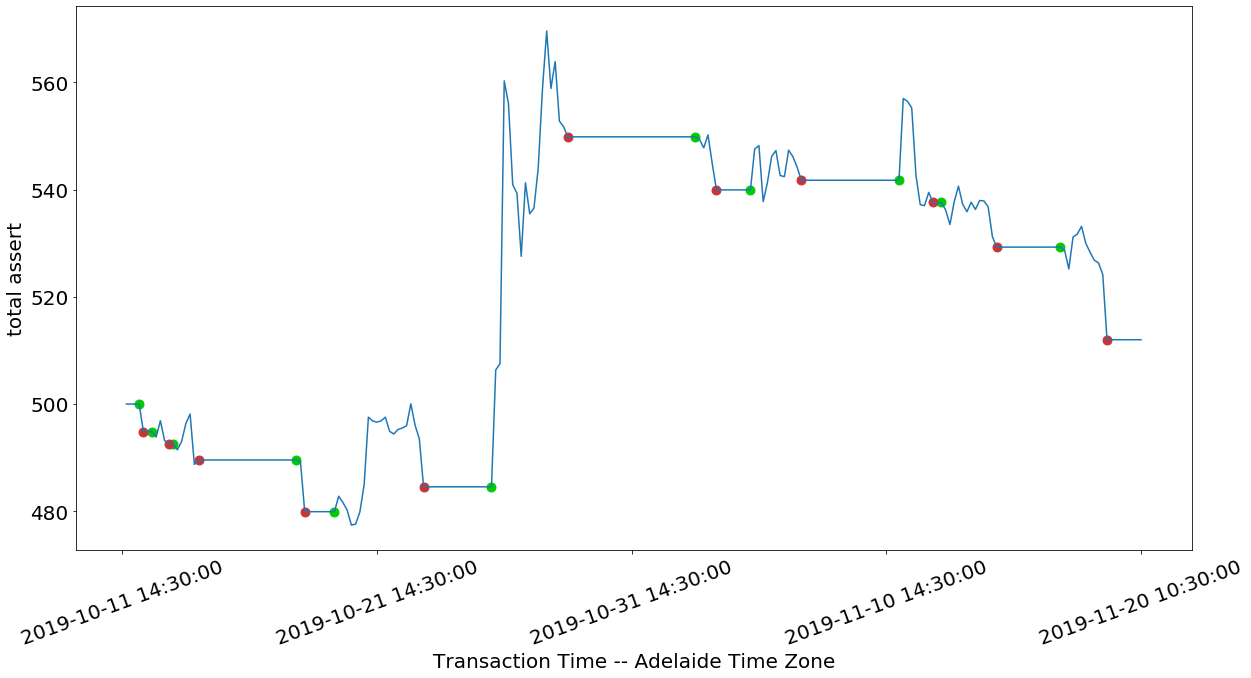

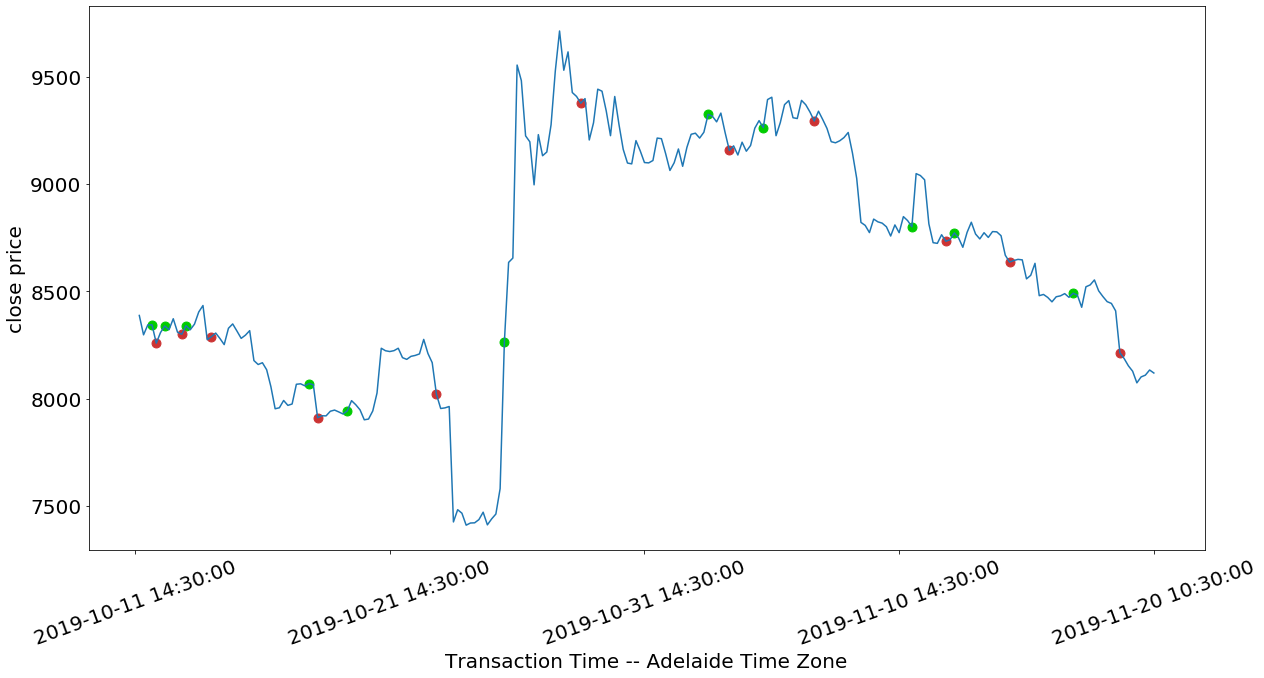

In [31]:
record = {}
run_bot('4h','4 hours','40 days ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-11 12:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 30
Current Money:0.008034019999968223
Current Bitcoin: 0.064555
Current BNB: 4.399116080013752
Return on Investment is:12.443089476313139%
Current Total Assert is: 663.4142279102475


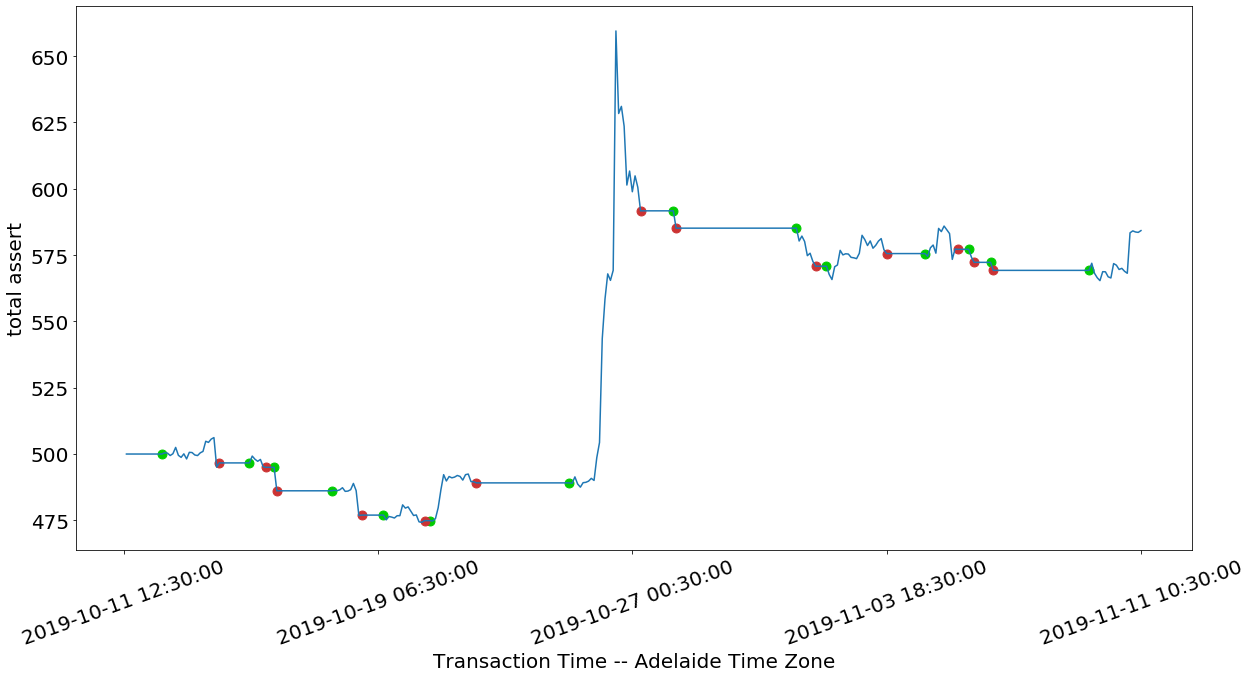

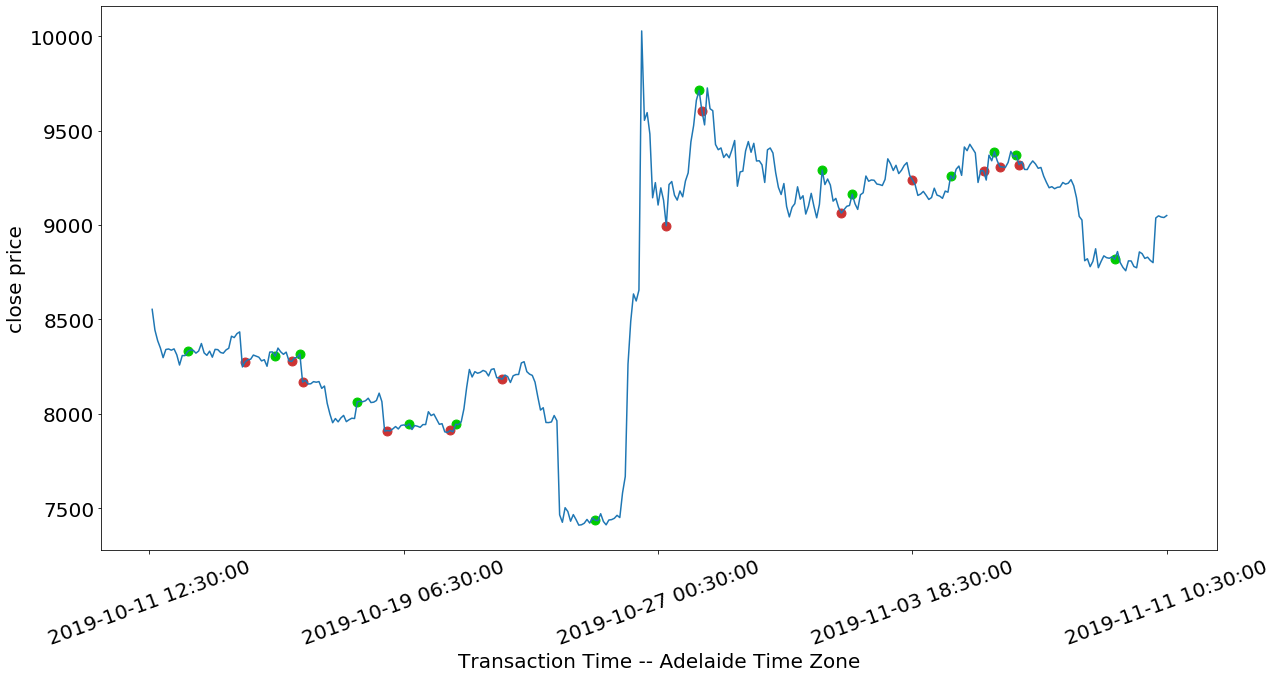

In [22]:
record = {}
run_bot('2h','2 hour','1 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-11 14:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 30
Current Money:0.00324574000001121
Current Bitcoin: 0.061556
Current BNB: 4.639748307288749
Return on Investment is:8.53838159850806%
Current Total Assert is: 640.3764514311976


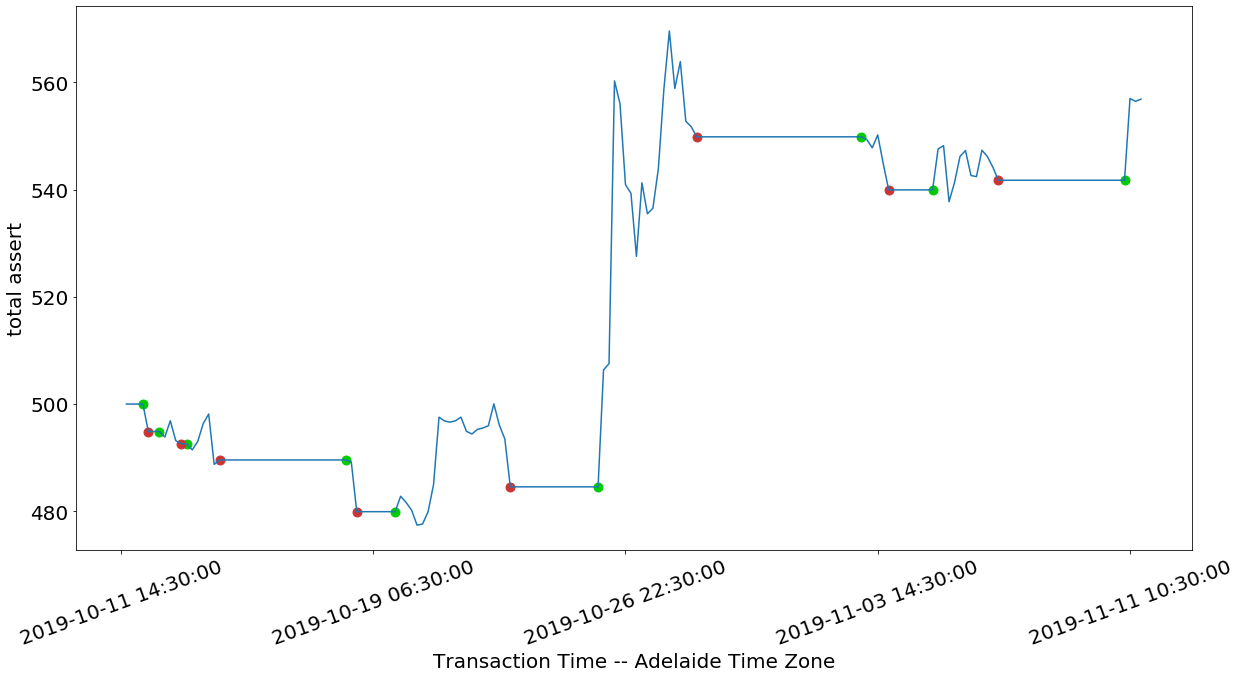

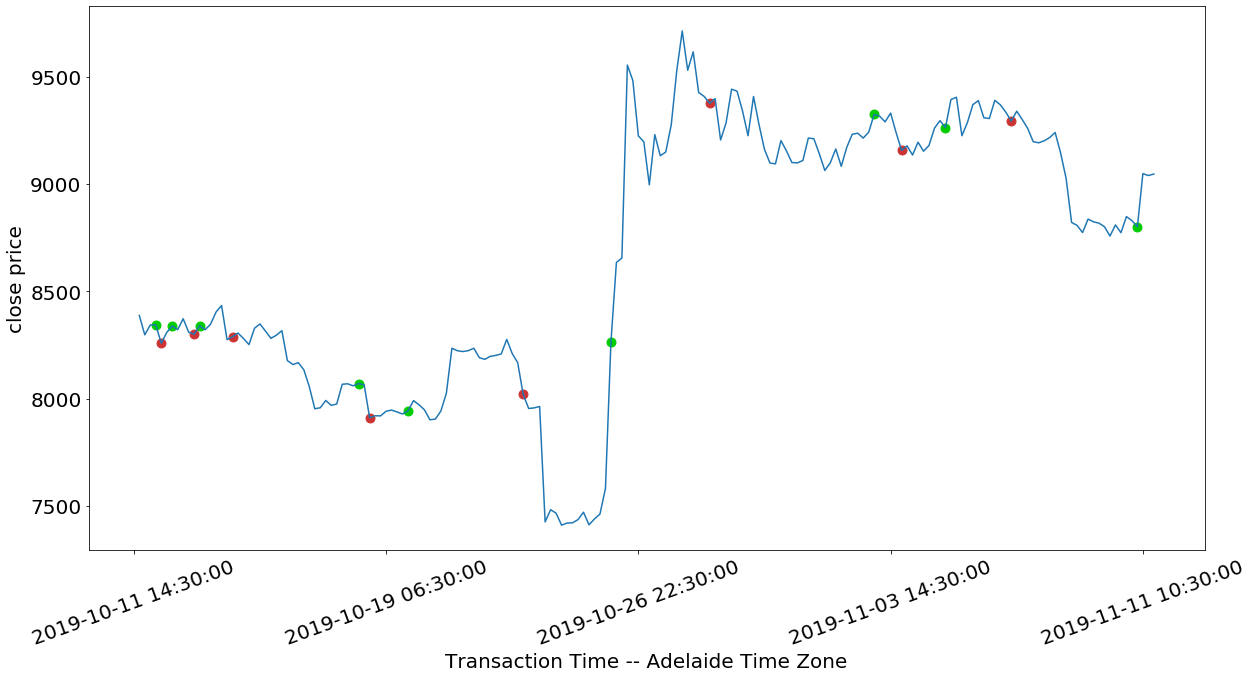

In [23]:
record = {}
run_bot('4h','4 hour','1 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-11 16:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 30
Current Money:0.007270820000030653
Current Bitcoin: 0.059206999999999996
Current BNB: 4.68331145726
Return on Investment is:5.0336623763864425%
Current Total Assert is: 619.69860802068


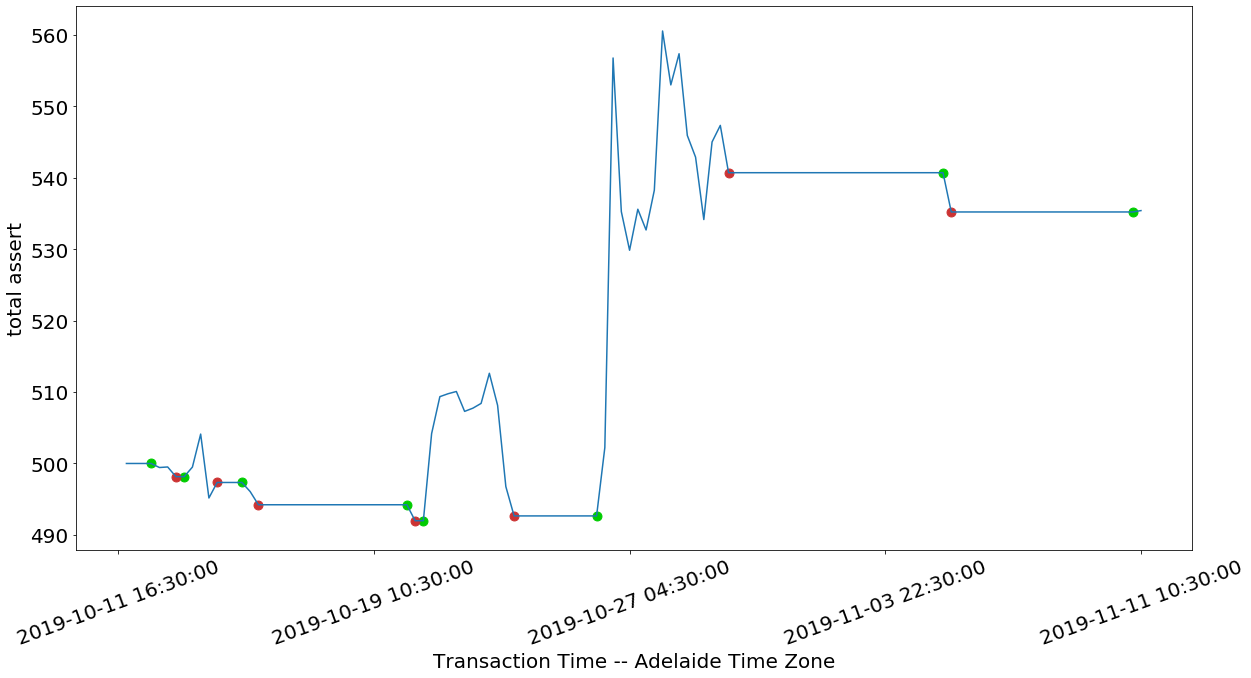

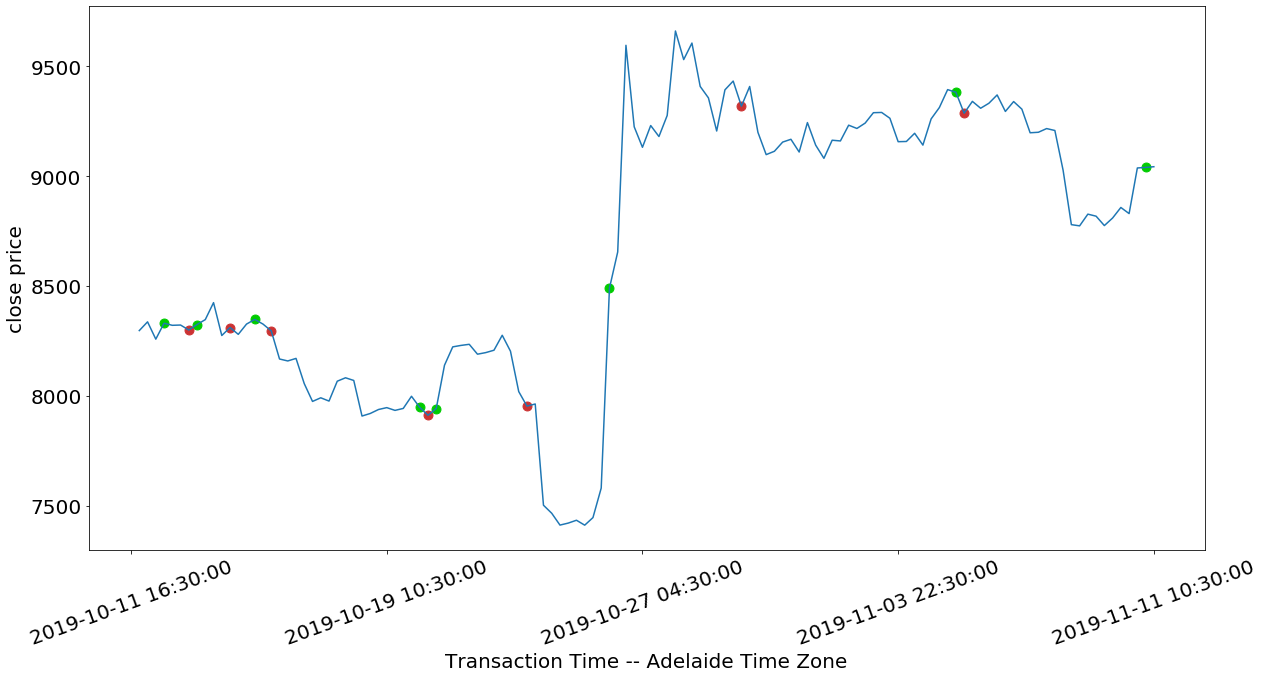

In [24]:
record = {}
run_bot('6h','6 hour','1 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-11 22:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 30
Current Money:481.19639527999993
Current Bitcoin: 0
Current BNB: 4.880116697905001
Return on Investment is:-3.5527973148661034%
Current Total Assert is: 569.03849584229


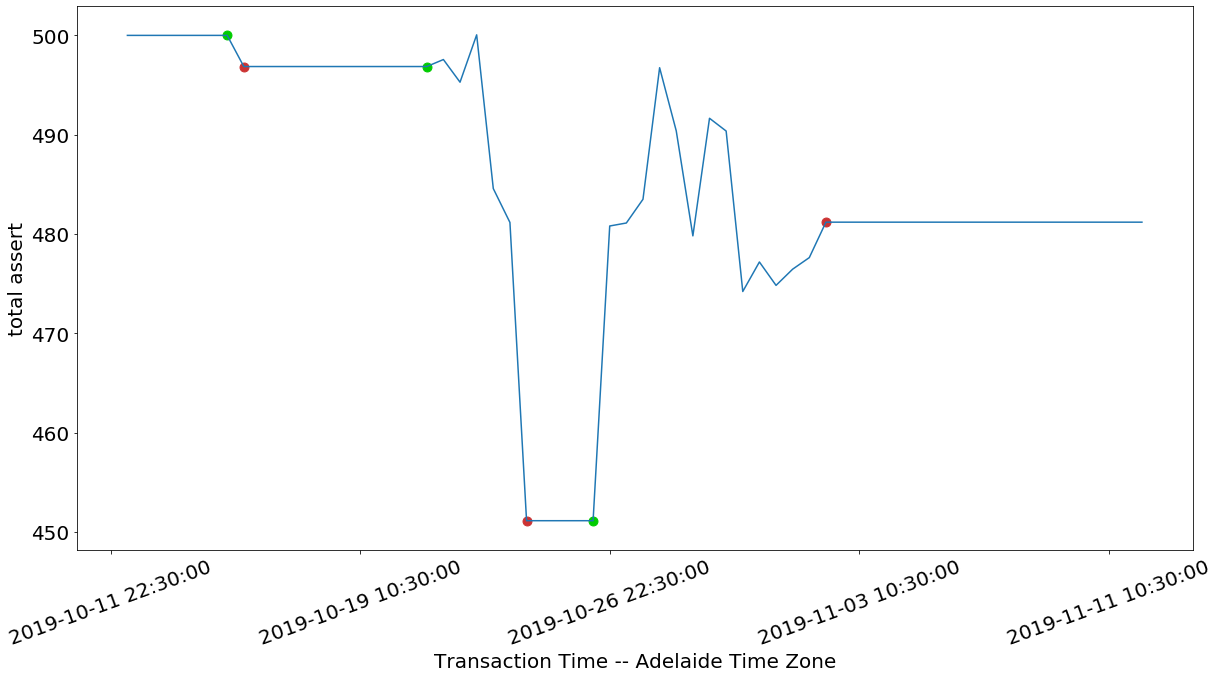

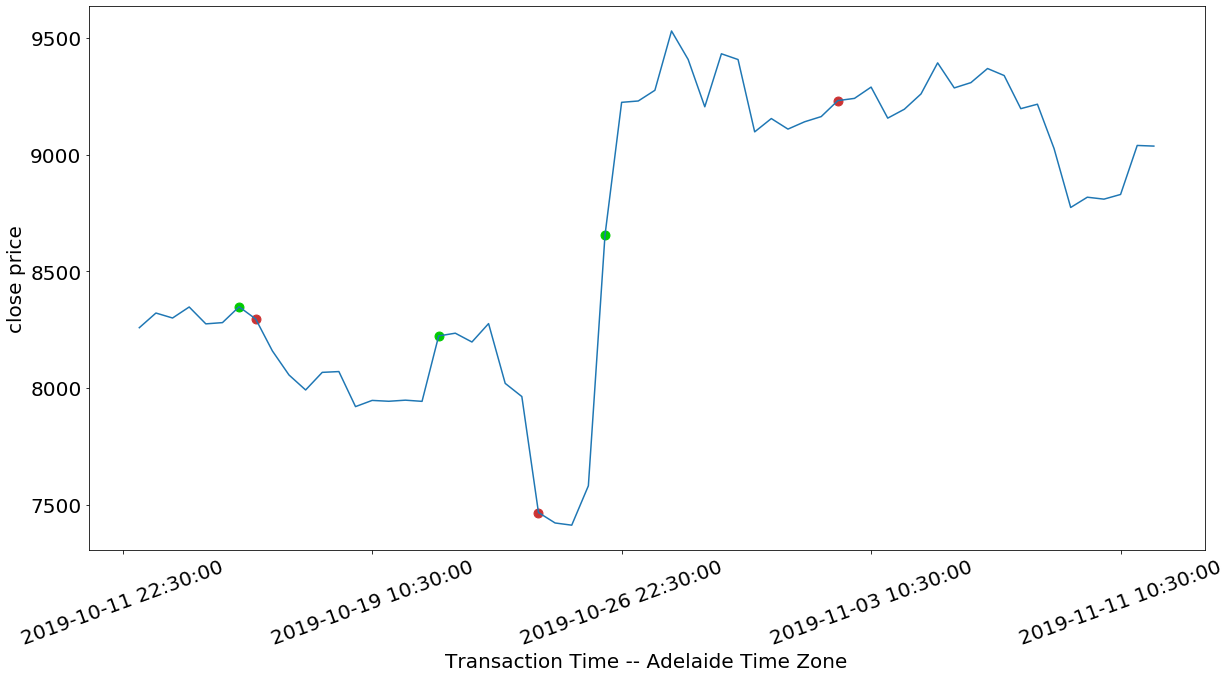

In [25]:
record = {}
run_bot('12h','12 hour','1 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-12 10:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 30
Current Money:451.23316891999986
Current Bitcoin: 0
Current BNB: 4.882547776326667
Return on Investment is:-8.623893407816968%
Current Total Assert is: 539.1190288938799


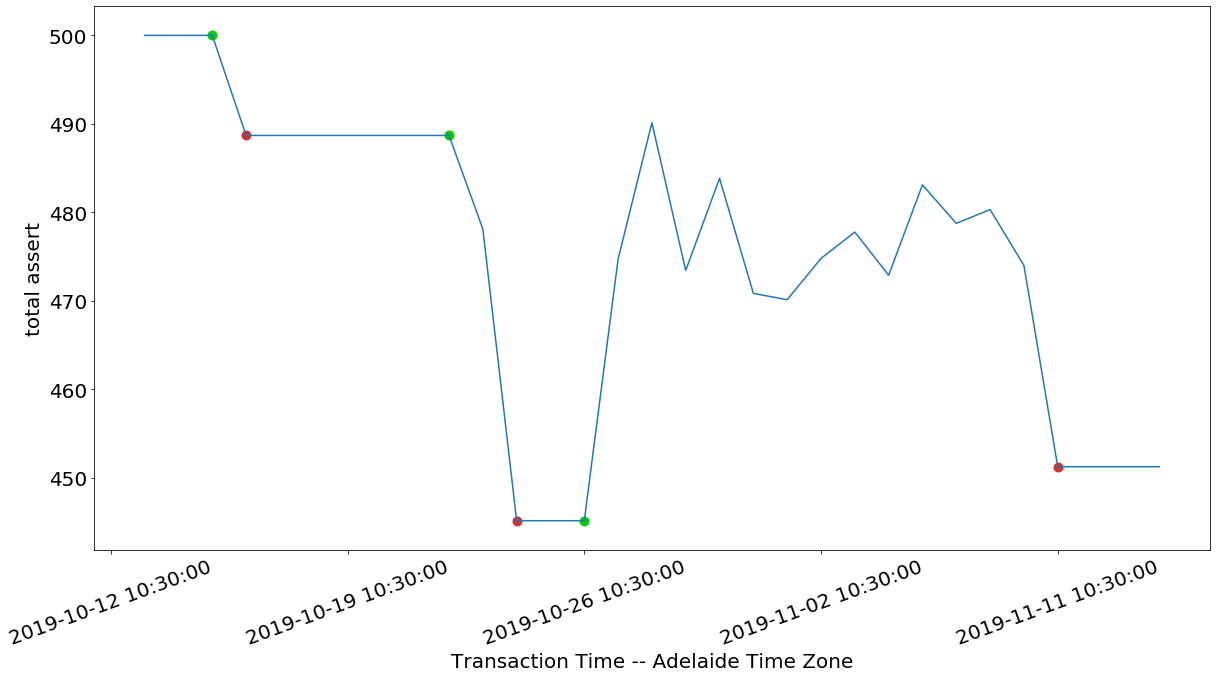

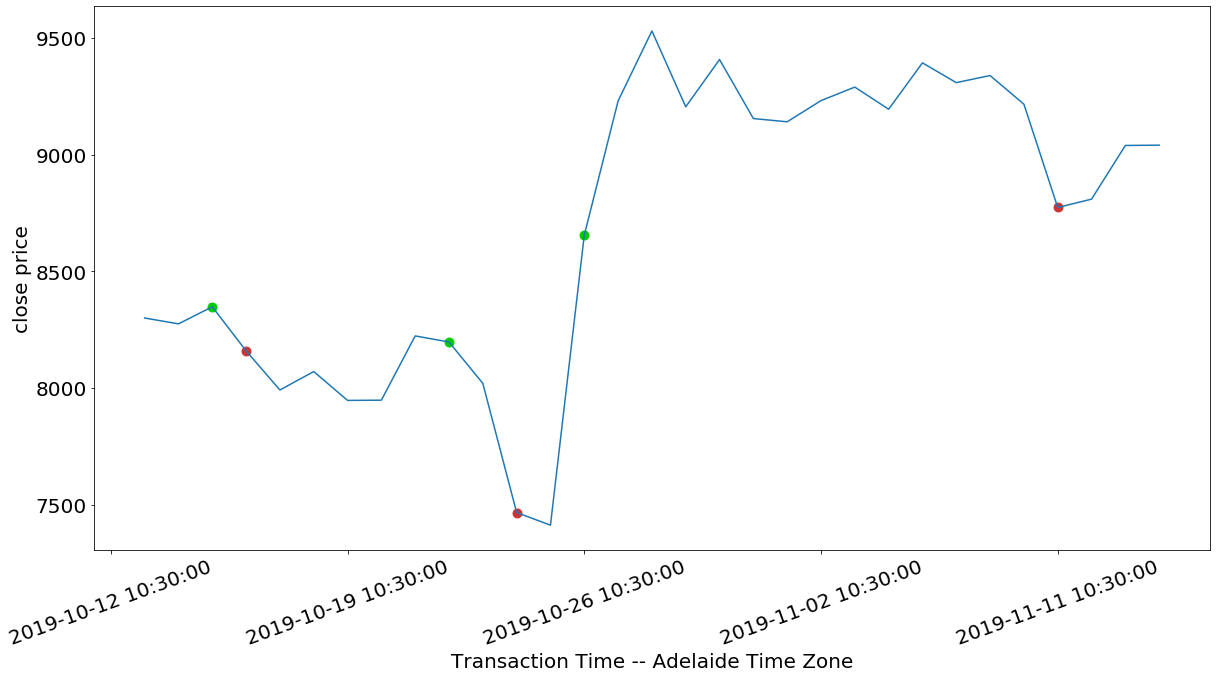

In [26]:
record = {}
run_bot('1d','1 day','1 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-09-11 11:30:00
Investment End Time:2019-11-11 11:30:00
Investment Periods: 61
Current Money:0.004069830000503316
Current Bitcoin: 0.060475999999999995
Current BNB: 2.890438250785837
Return on Investment is:1.5092086684992254%
Current Total Assert is: 598.9043311441454


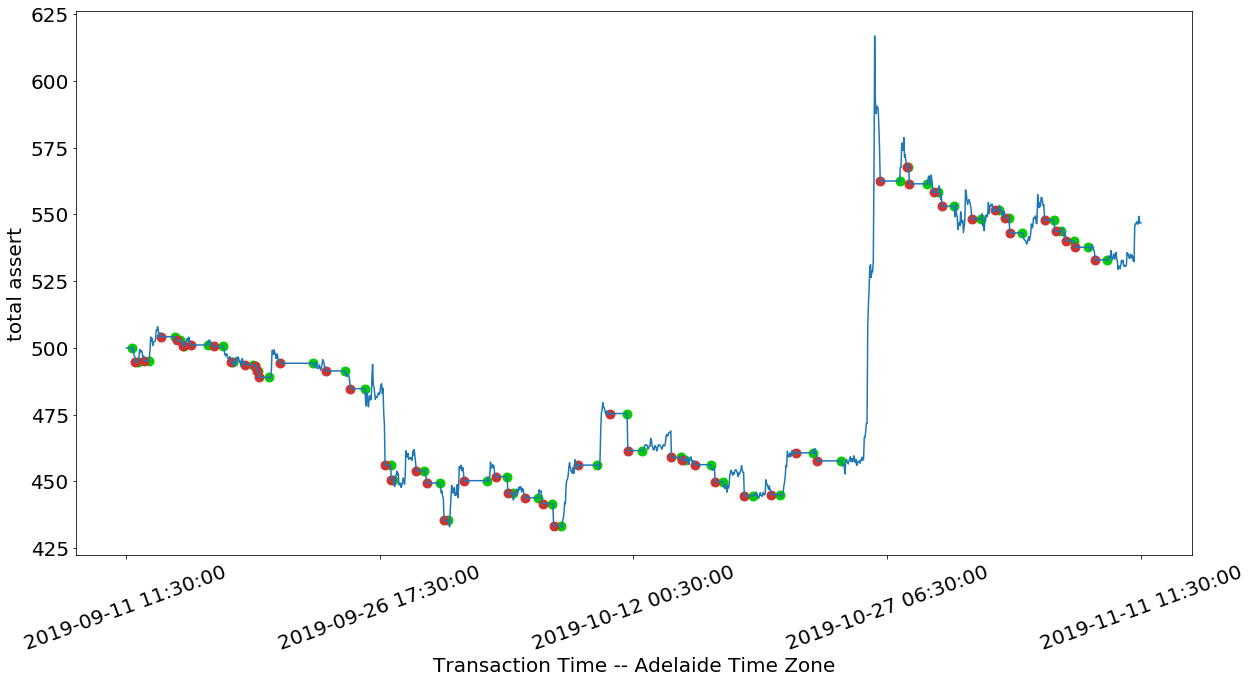

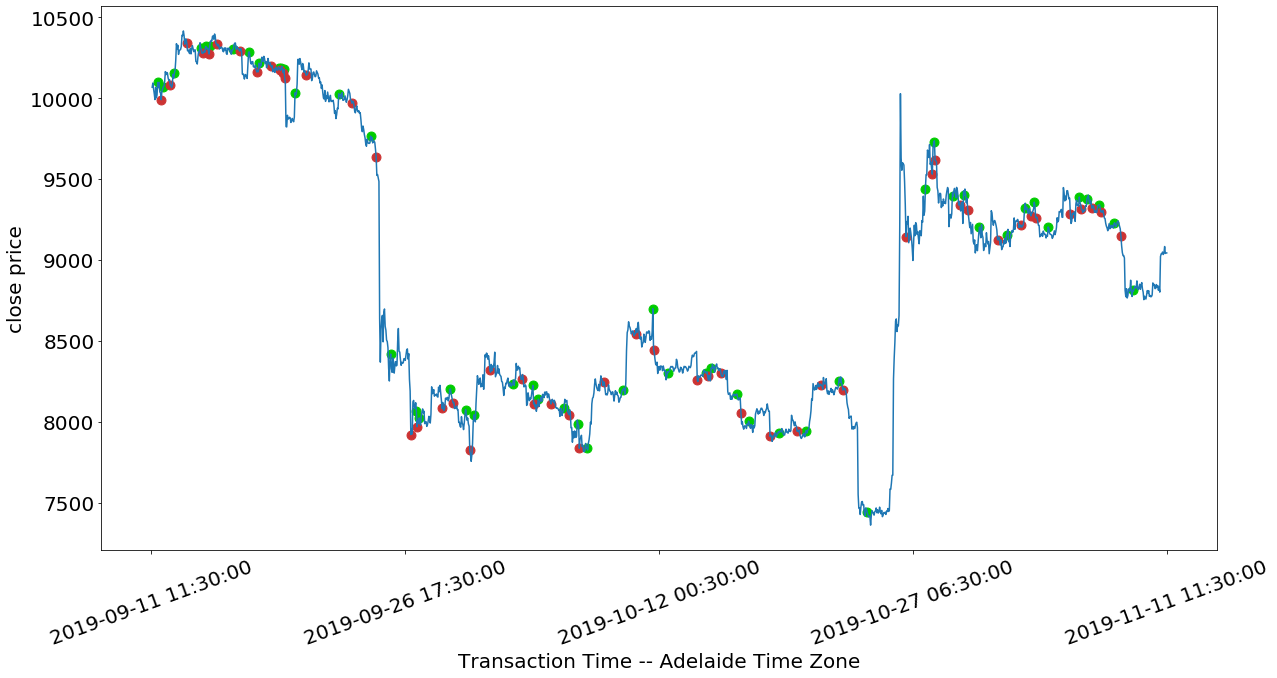

In [27]:
record = {}
run_bot('1h','1 hour','2 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-09-11 11:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 60
Current Money:0.0014755300004480887
Current Bitcoin: 0.059982999999999995
Current BNB: 3.754548276452082
Return on Investment is:3.3894265942606547%
Current Total Assert is: 609.9976169061379


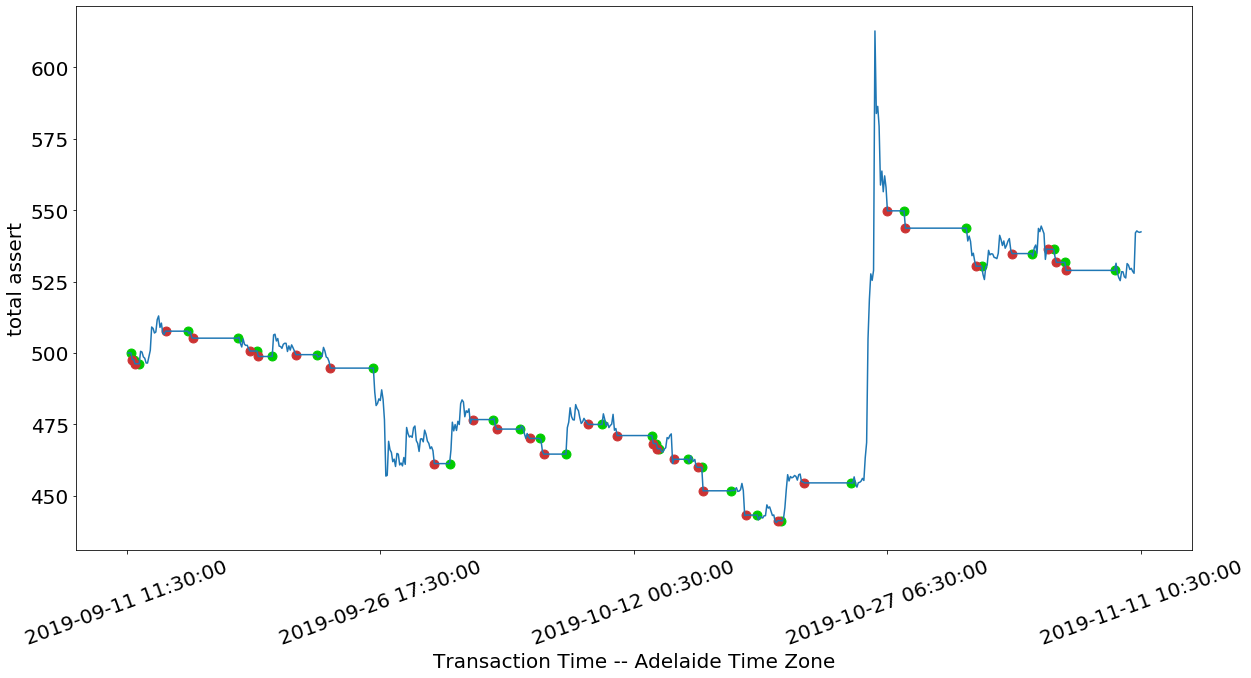

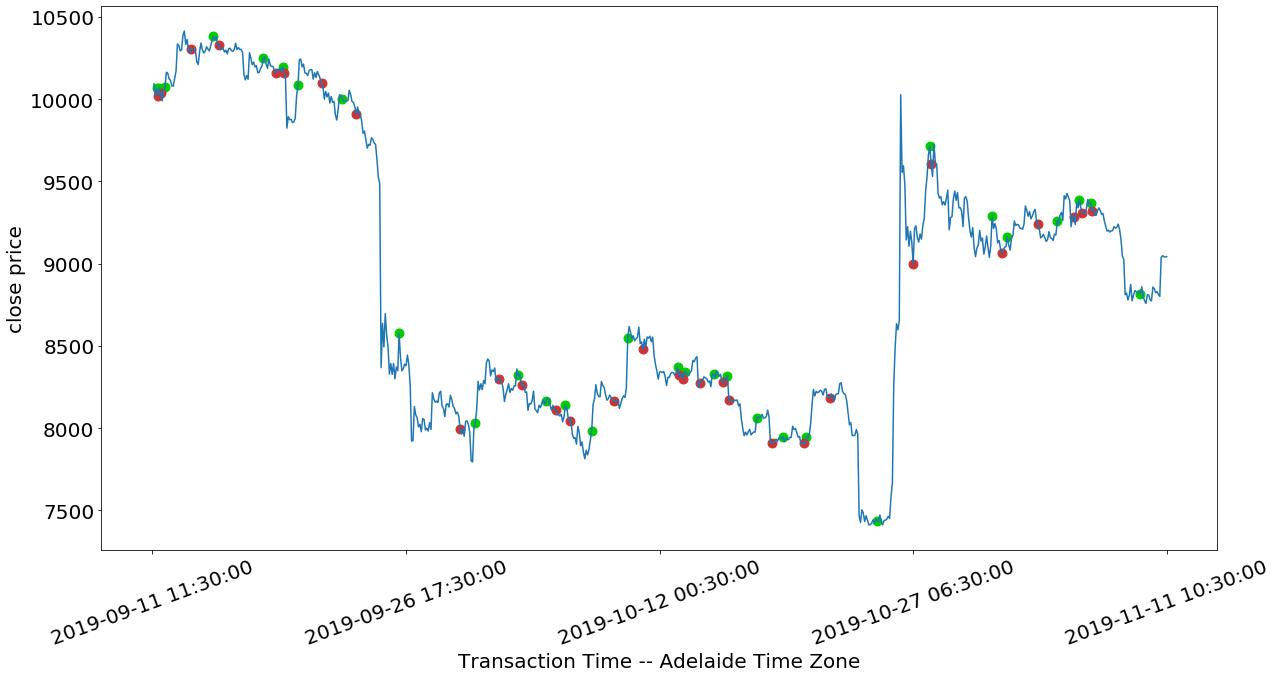

In [28]:
record = {}
run_bot('2h','2 hour','2 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-09-11 13:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 60
Current Money:0.002150719999917783
Current Bitcoin: 0.063716
Current BNB: 4.504730921386665
Return on Investment is:11.401340594060981%
Current Total Assert is: 657.2679095049598


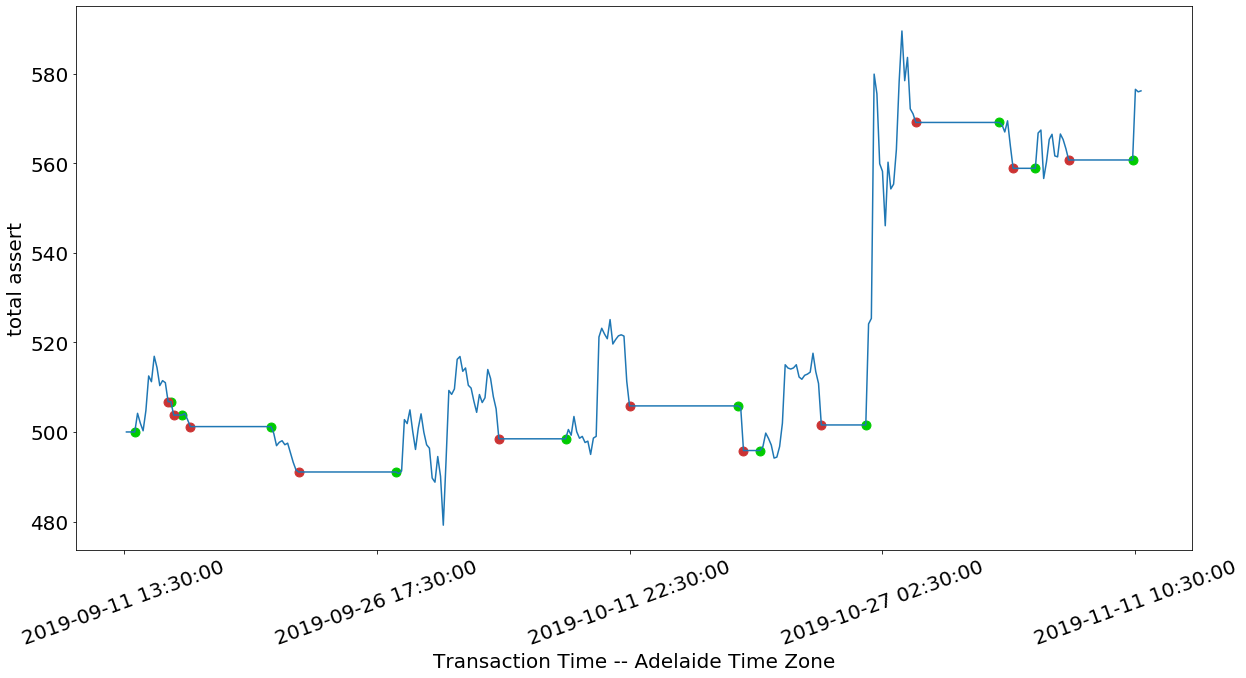

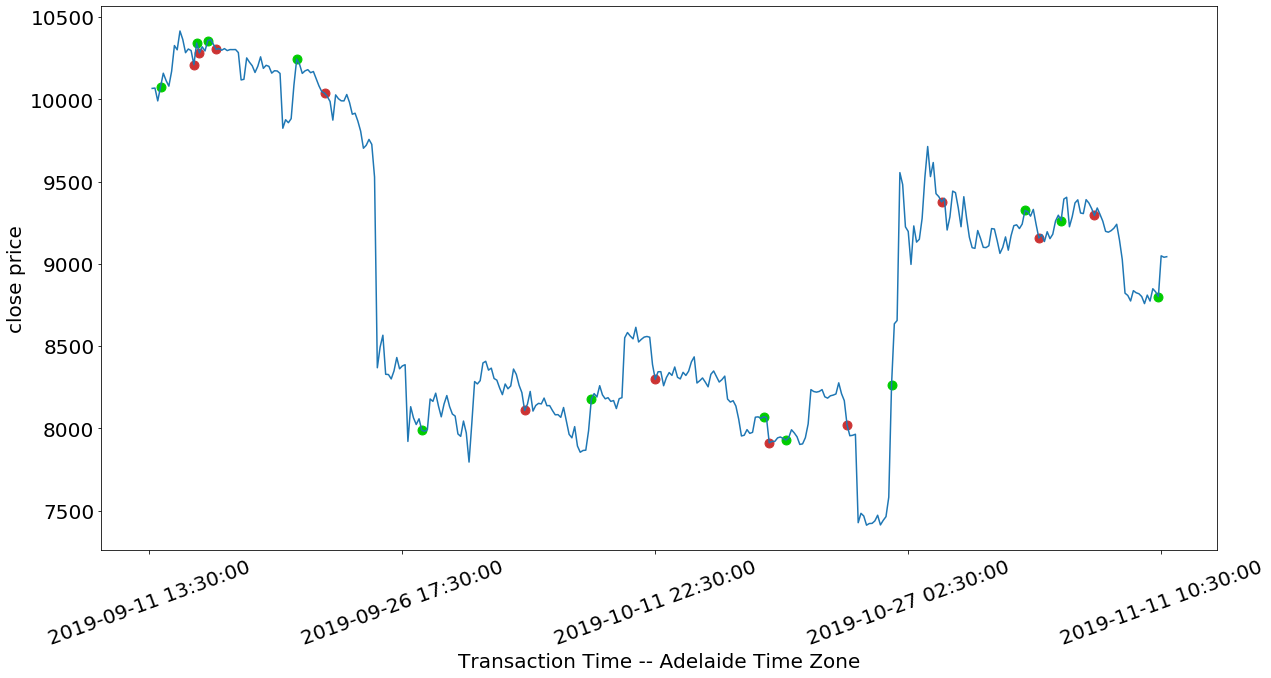

In [29]:
record = {}
run_bot('4h','4 hour','2 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-09-11 15:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 60
Current Money:0.005549890000111191
Current Bitcoin: 0.058365999999999994
Current BNB: 4.685785745545
Return on Investment is:3.7531371338661175%
Current Total Assert is: 612.1435090898101


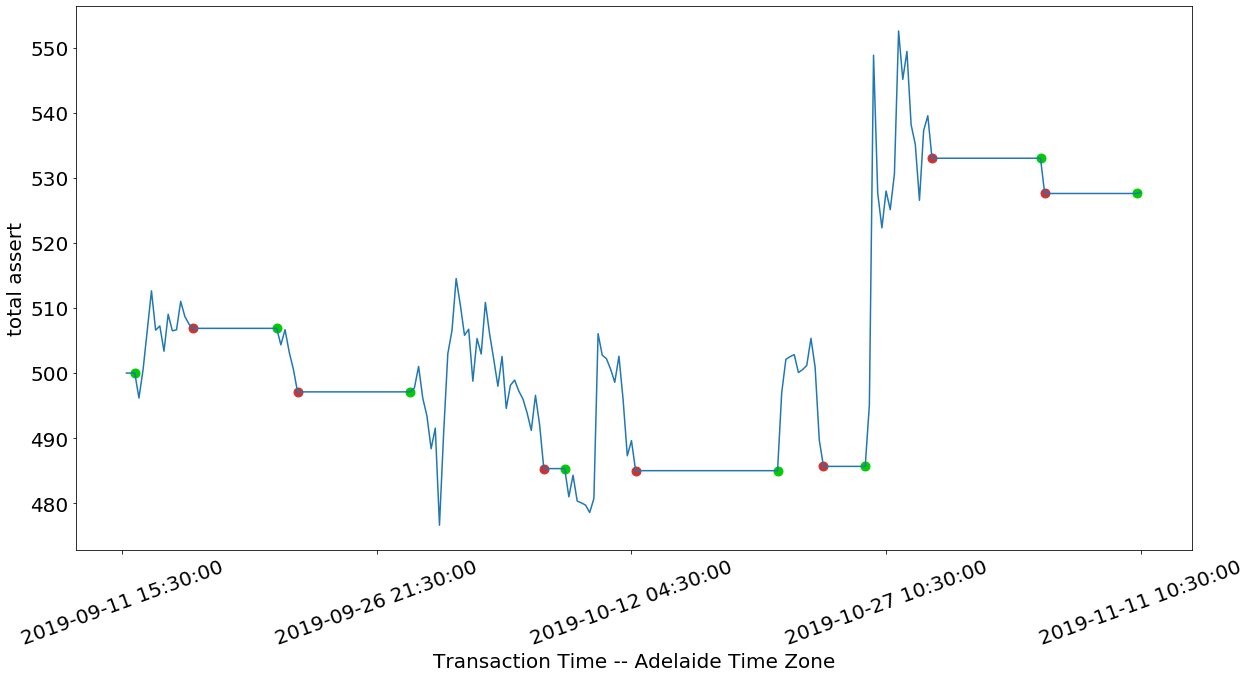

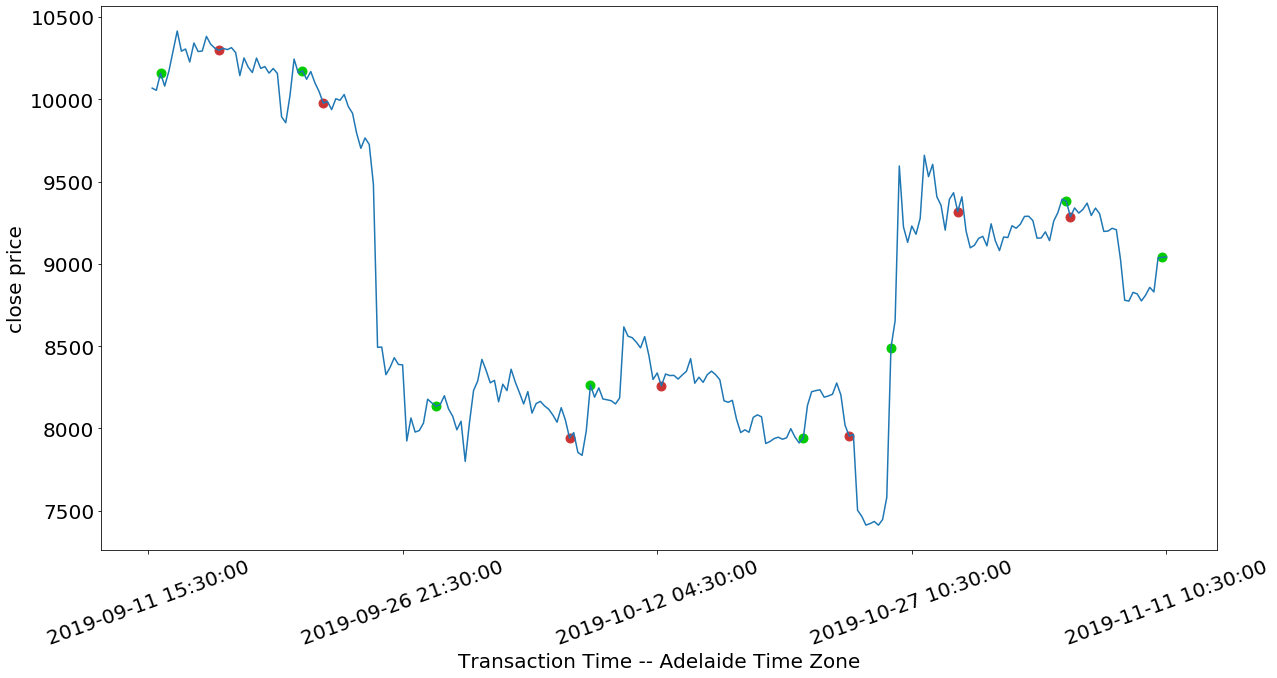

In [30]:
record = {}
run_bot('6h','6 hour','2 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-09-11 21:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 60
Current Money:466.99293063
Current Bitcoin: 0
Current BNB: 4.883040592700416
Return on Investment is:-5.951243847693654%
Current Total Assert is: 554.8876612986074


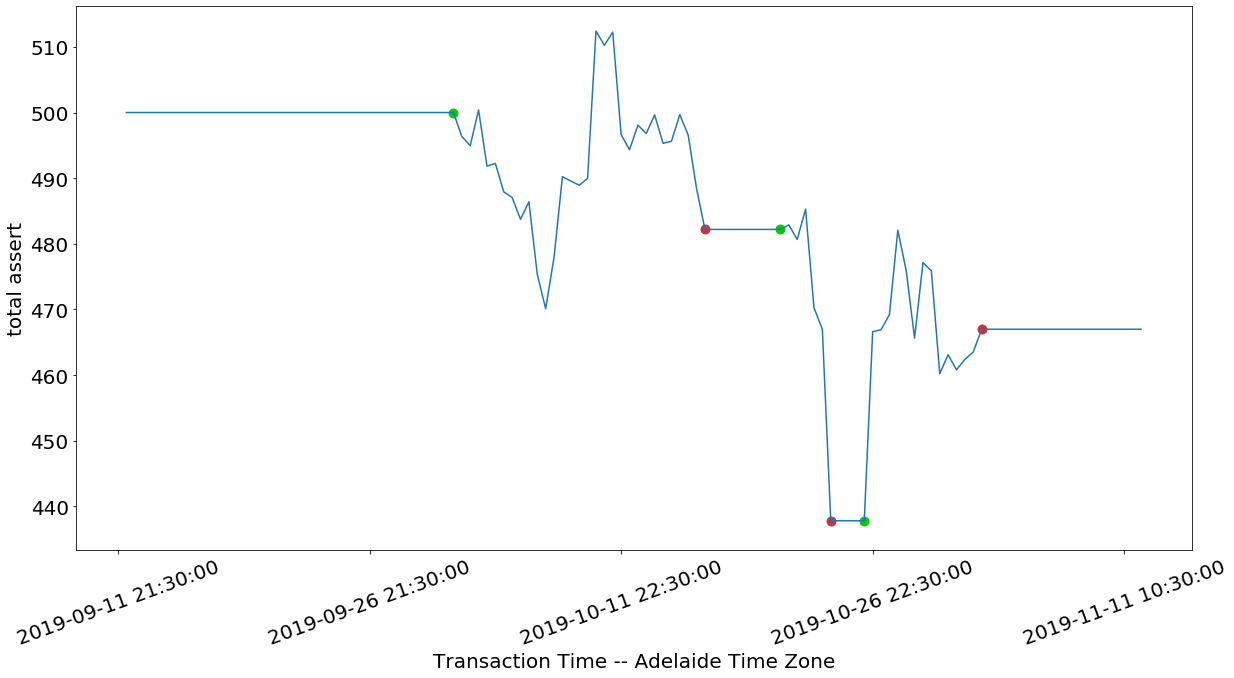

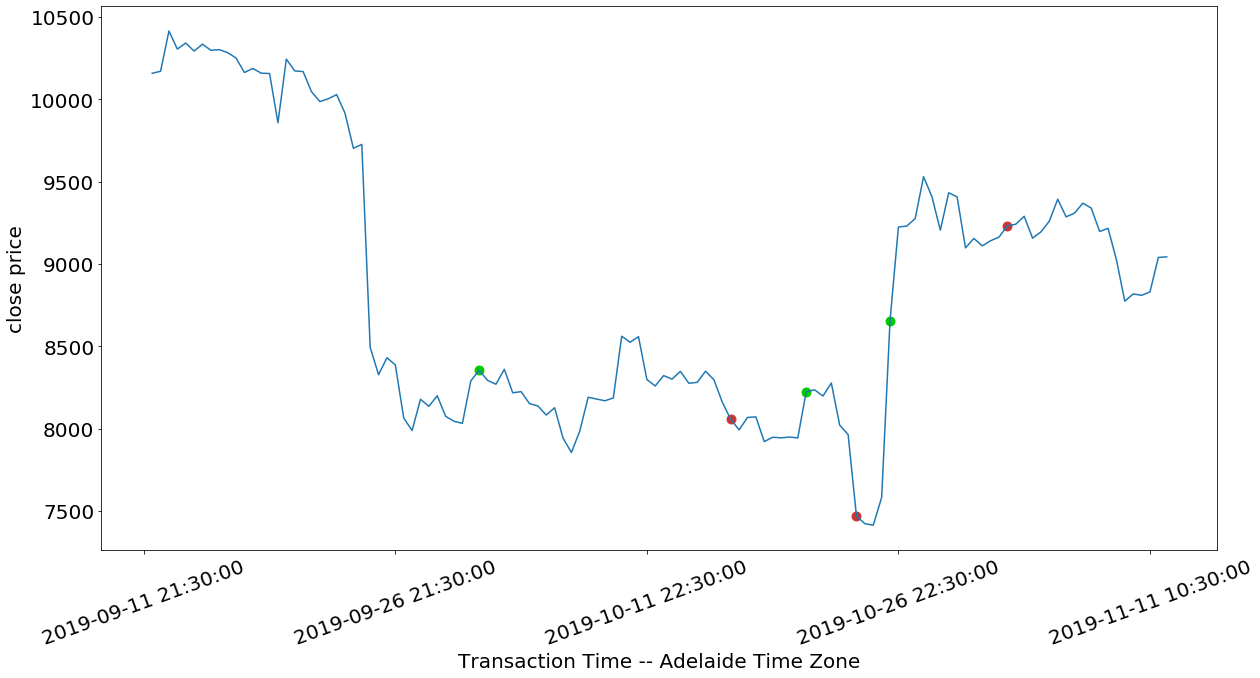

In [31]:
record = {}
run_bot('12h','12 hour','2 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-09-12 09:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 60
Current Money:463.3125567899999
Current Bitcoin: 0
Current BNB: 4.921775465844584
Return on Investment is:-6.45686183471146%
Current Total Assert is: 551.9045151752024


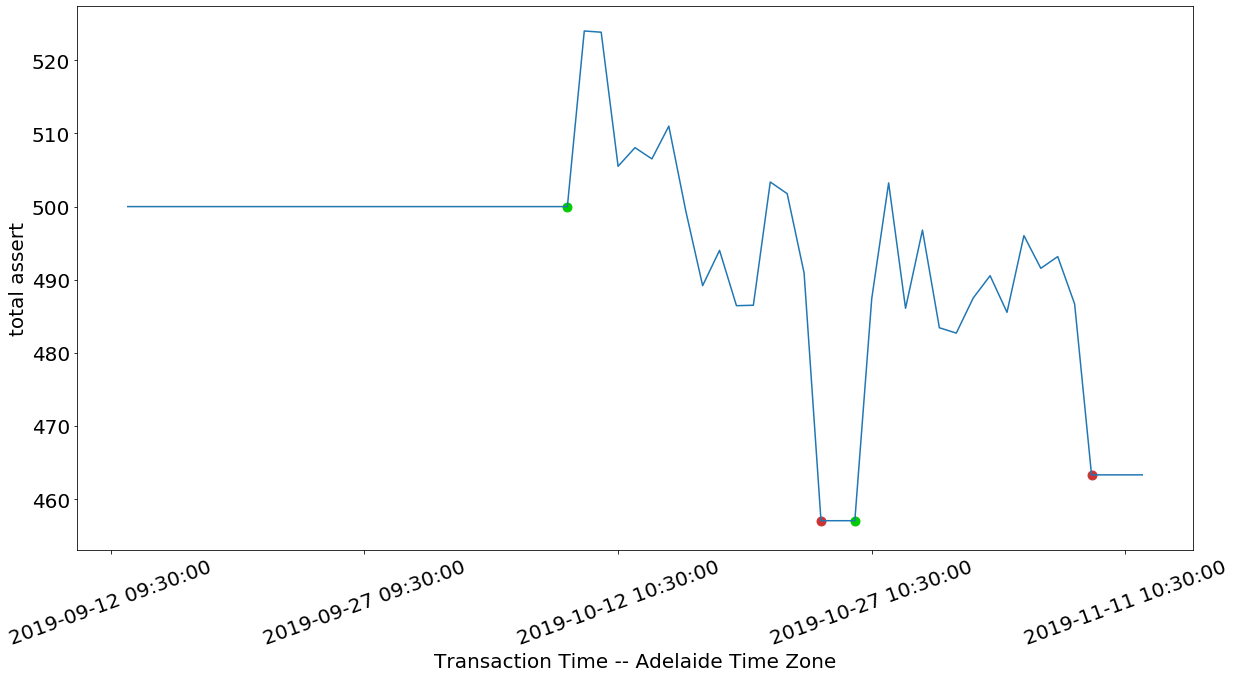

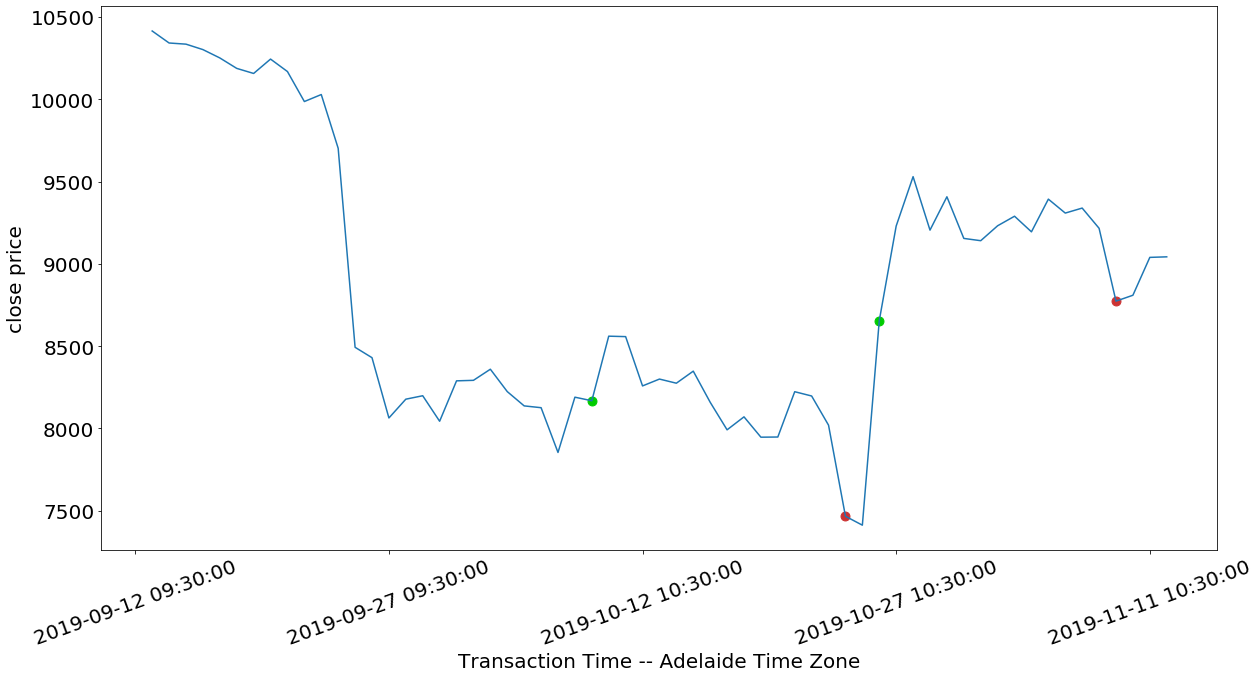

In [32]:
record = {}
run_bot('1d','1 day','2 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-08-11 11:30:00
Investment End Time:2019-11-11 11:30:00
Investment Periods: 92
Current Money:0.006059689999972306
Current Bitcoin: 0.055298
Current BNB: 1.970647919947085
Return on Investment is:-9.228489198466516%
Current Total Assert is: 535.5519137290476


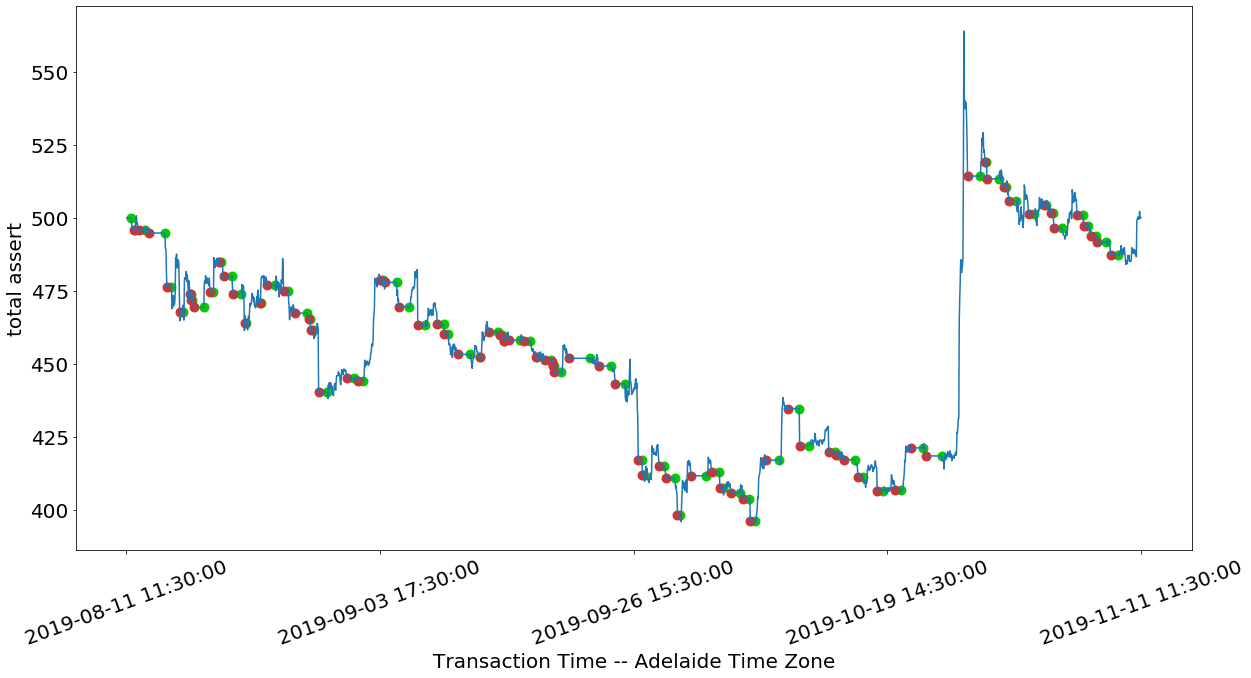

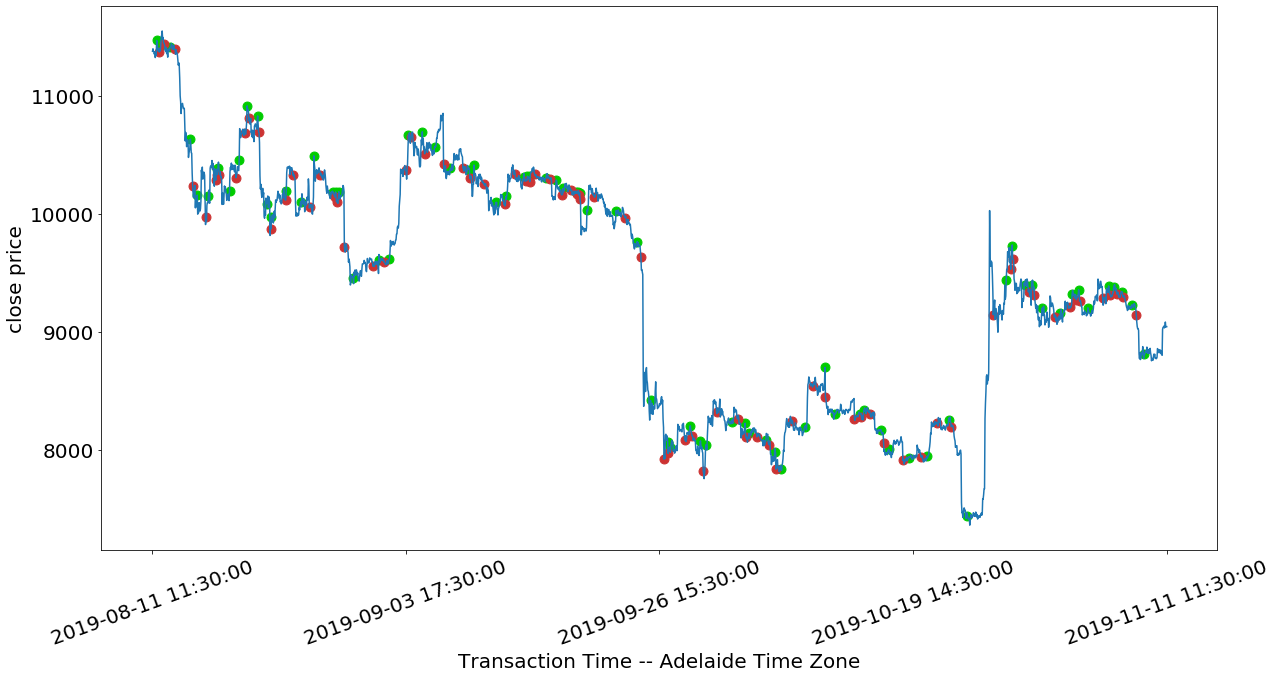

In [33]:
record = {}
run_bot('1h','1 hour','3 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-08-11 11:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 91
Current Money:0.0029747399998996116
Current Bitcoin: 0.059316999999999995
Current BNB: 3.35957944633042
Return on Investment is:1.1596044176182227%
Current Total Assert is: 596.8416660639475


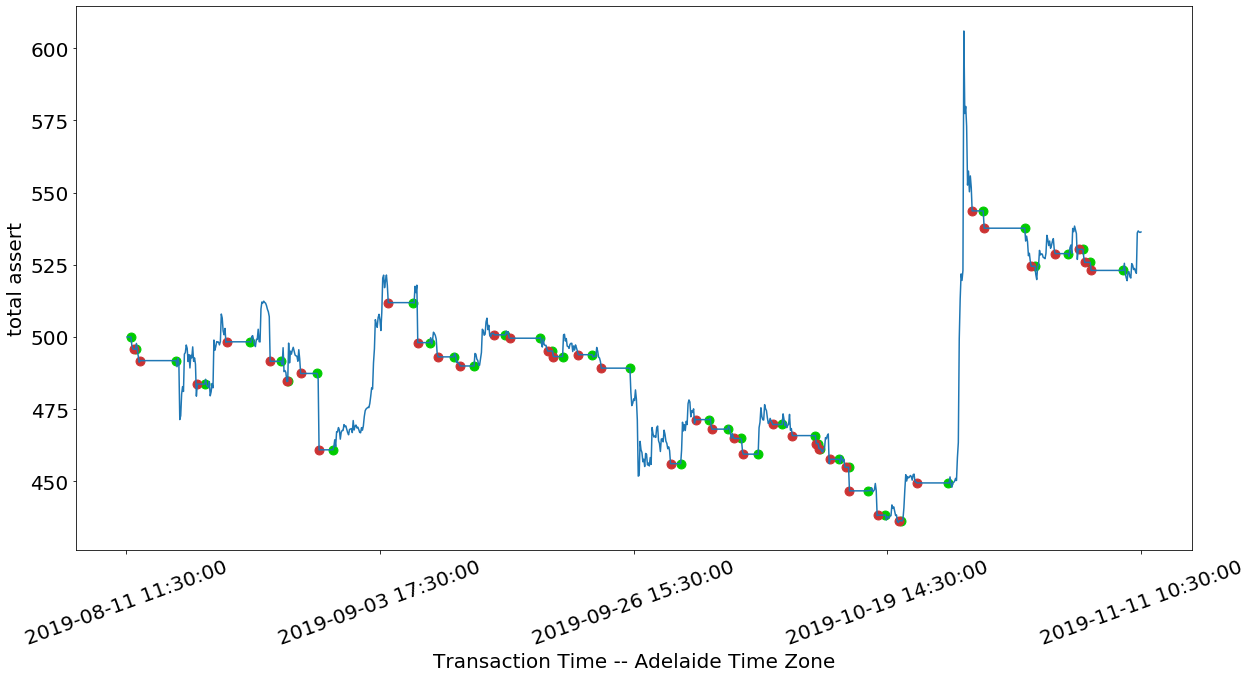

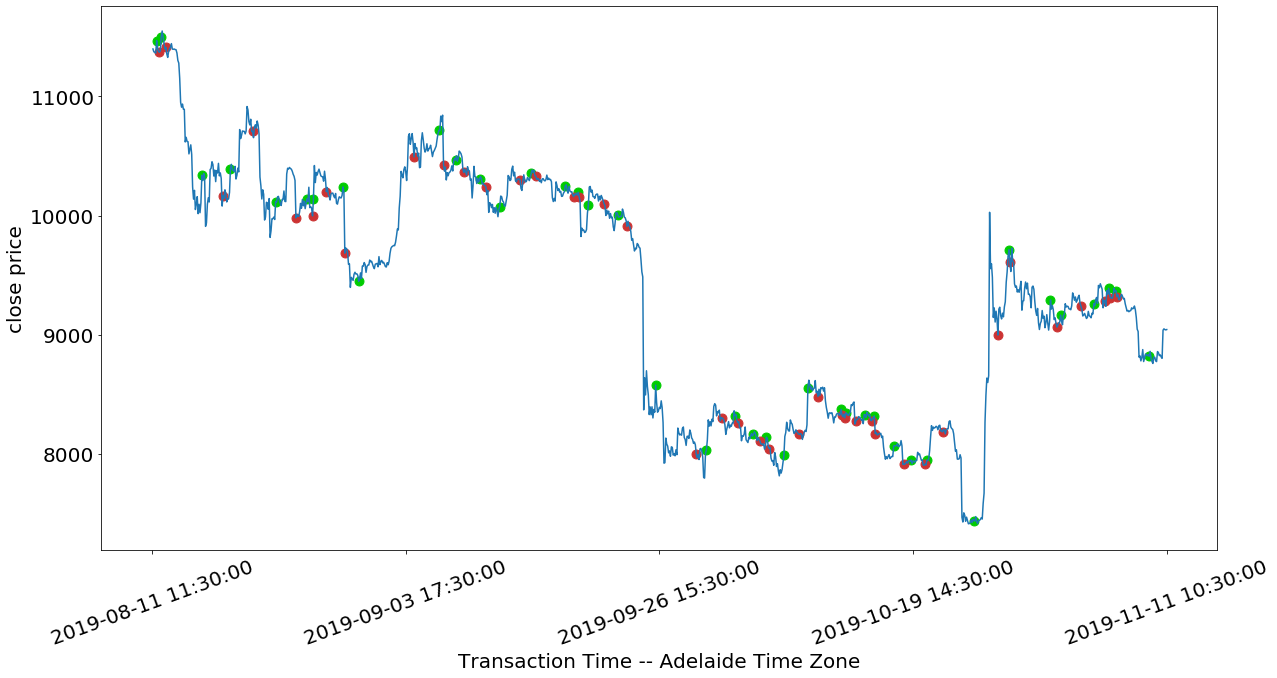

In [34]:
record = {}
run_bot('2h','2 hour','3 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-08-11 13:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 91
Current Money:0.004372039999907429
Current Bitcoin: 0.065968
Current BNB: 4.324672903622086
Return on Investment is:14.298780499185993%
Current Total Assert is: 674.3628049451974


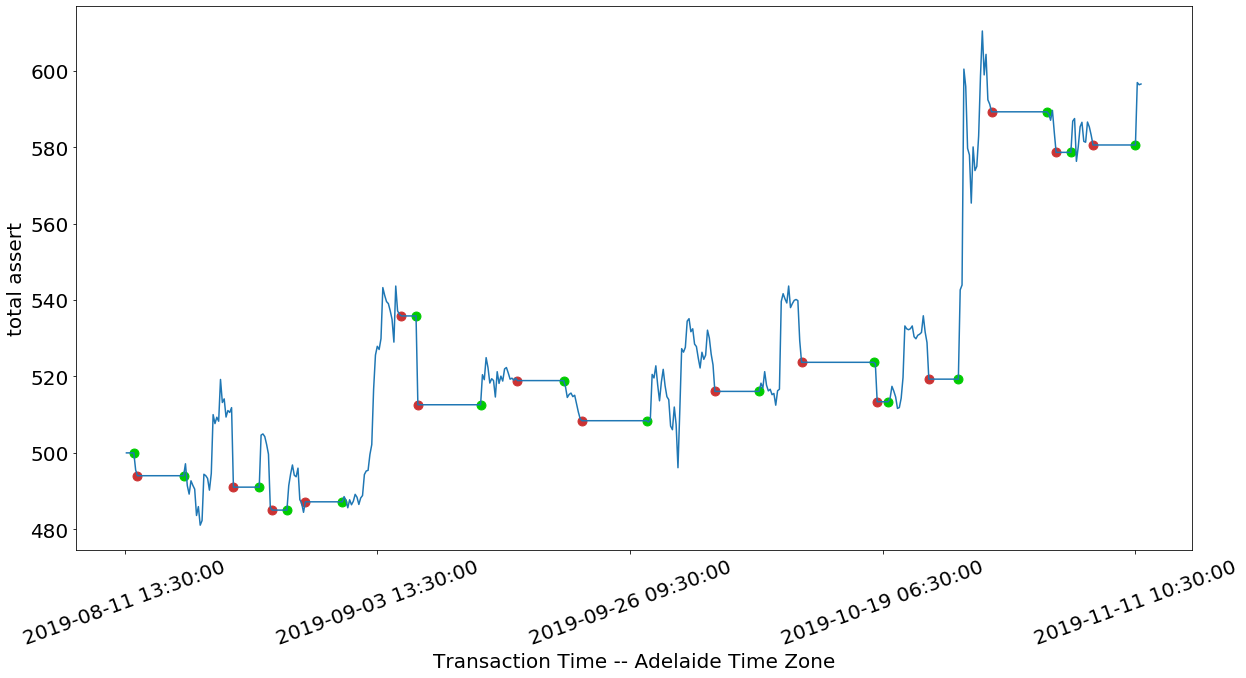

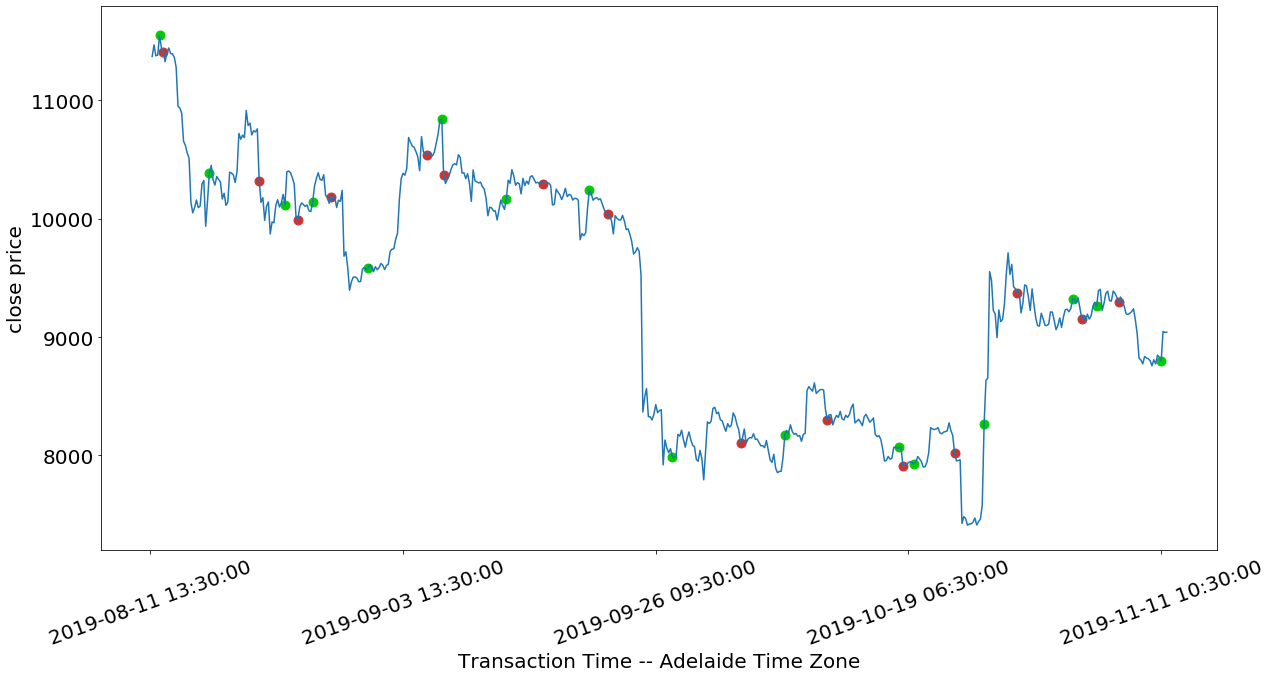

In [35]:
record = {}
run_bot('4h','4 hour','3 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-08-11 15:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 91
Current Money:0.0018994300000940711
Current Bitcoin: 0.05393
Current BNB: 4.4708107703833315
Return on Investment is:-3.713379678491507%
Current Total Assert is: 568.0910598969001


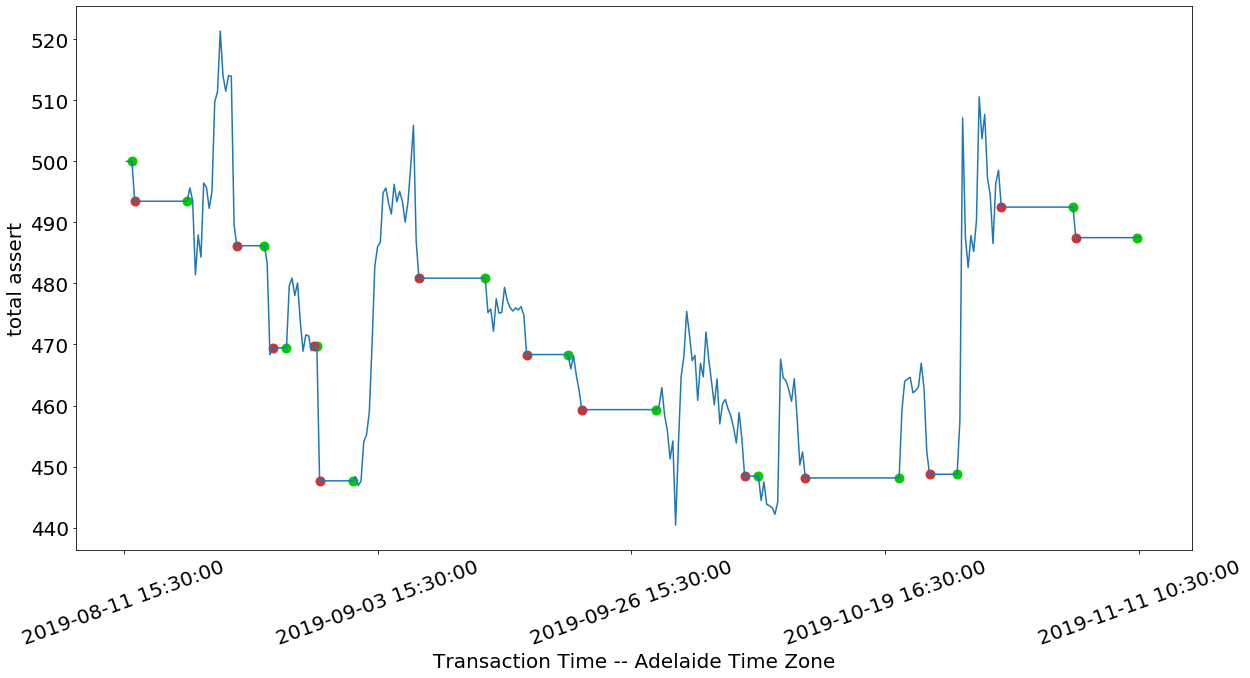

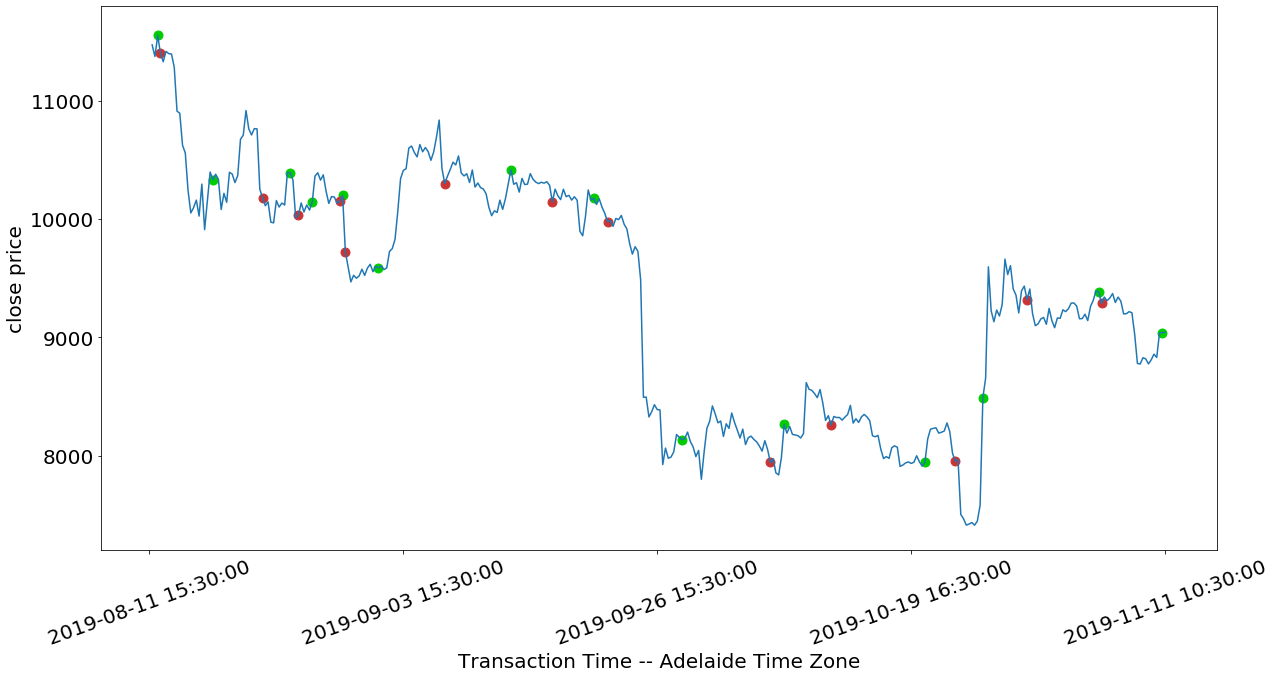

In [36]:
record = {}
run_bot('6h','6 hour','3 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-08-11 21:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 91
Current Money:447.17457206
Current Bitcoin: 0
Current BNB: 4.767534068192917
Return on Investment is:-9.66268045975042%
Current Total Assert is: 532.9901852874725


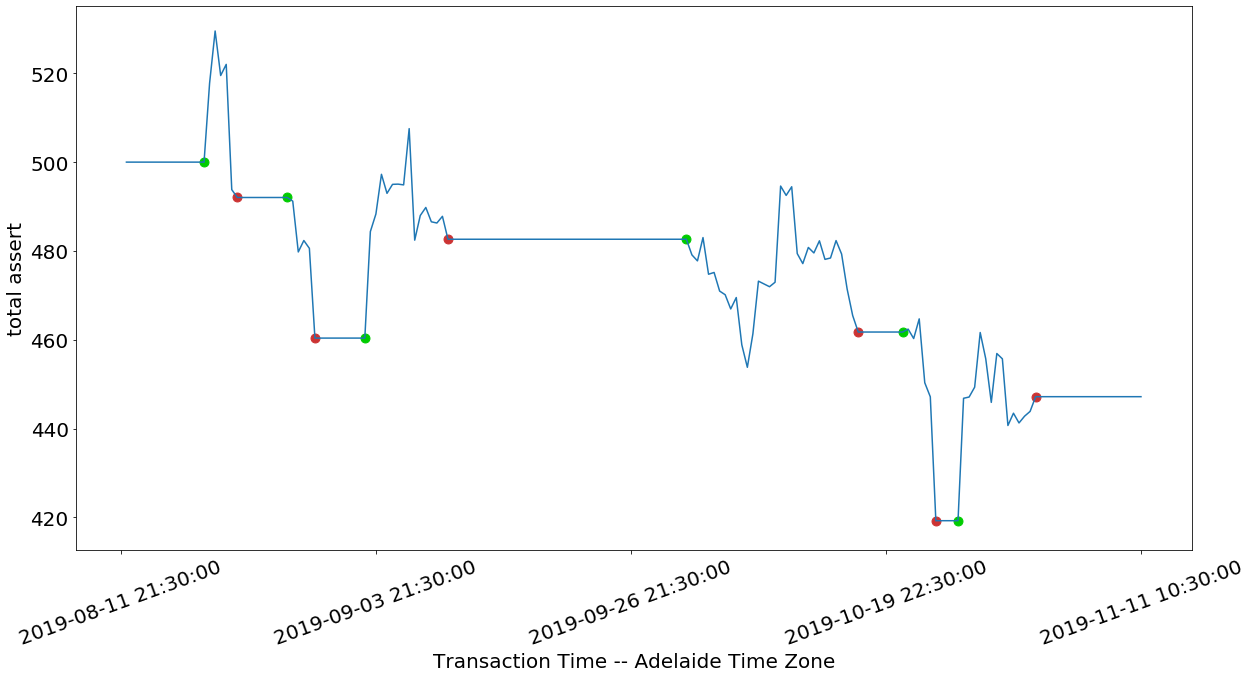

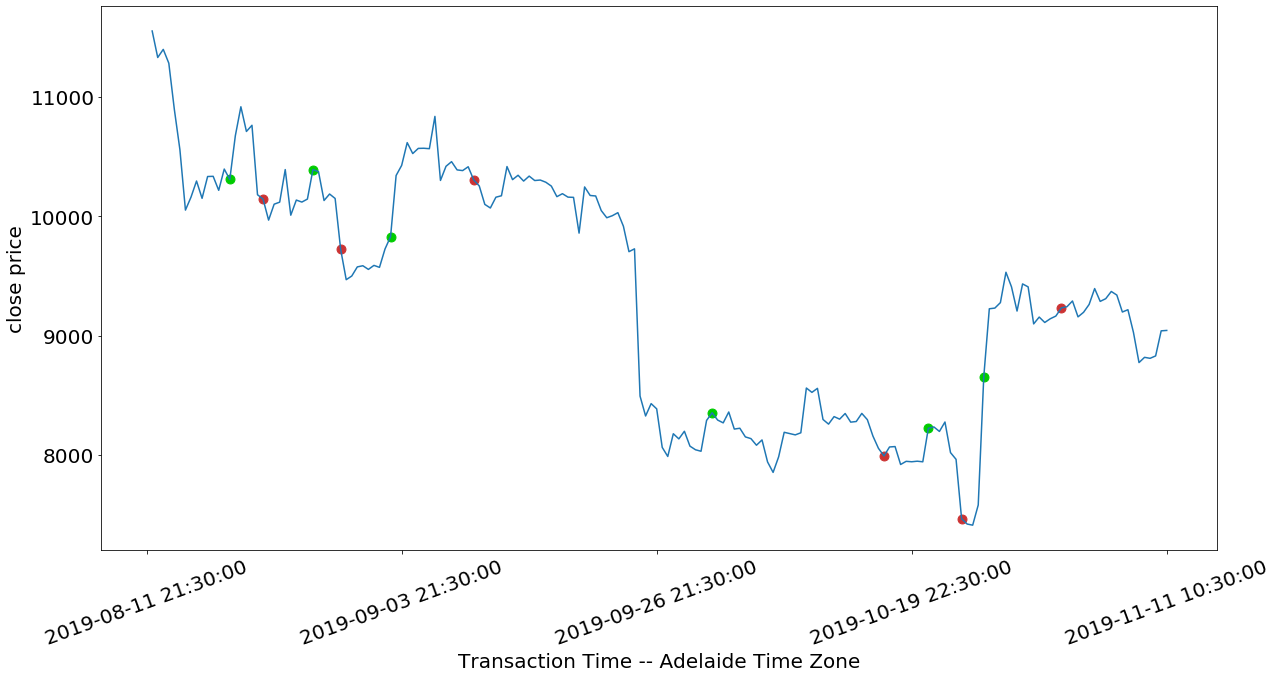

In [37]:
record = {}
run_bot('12h','12 hour','3 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-08-12 09:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 91
Current Money:410.10343071999984
Current Bitcoin: 0
Current BNB: 4.852949677141669
Return on Investment is:-15.685334761262737%
Current Total Assert is: 497.45652490854985
Trading curb occured


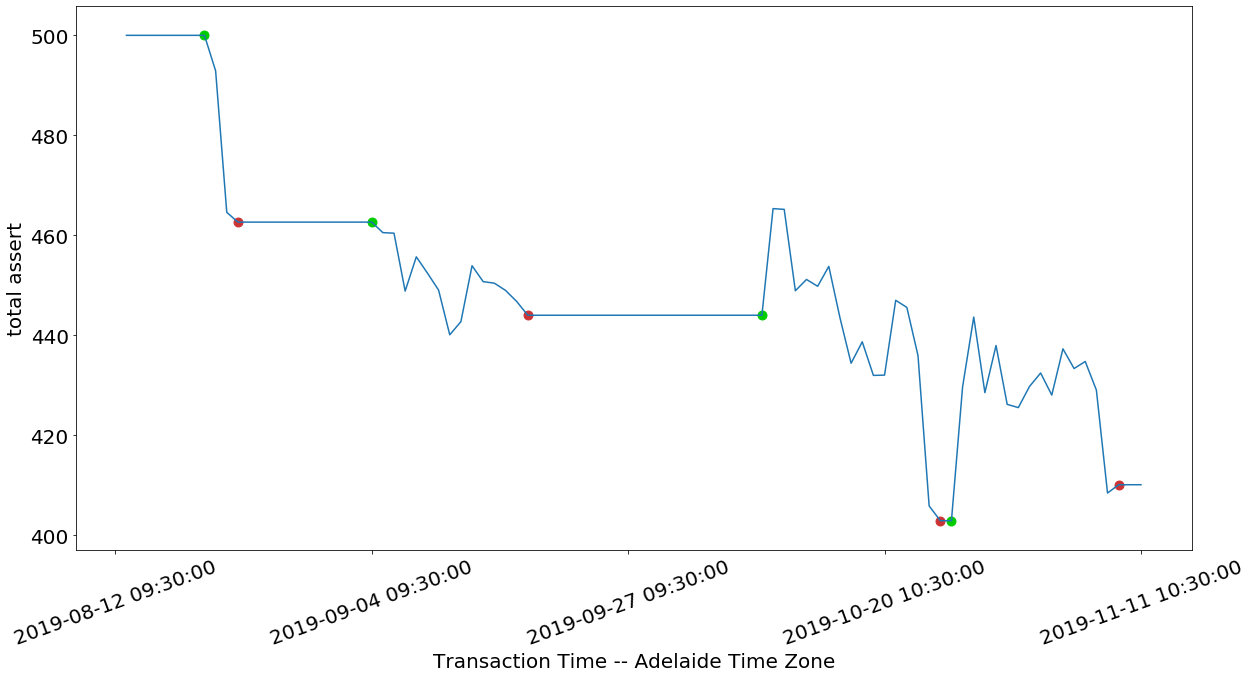

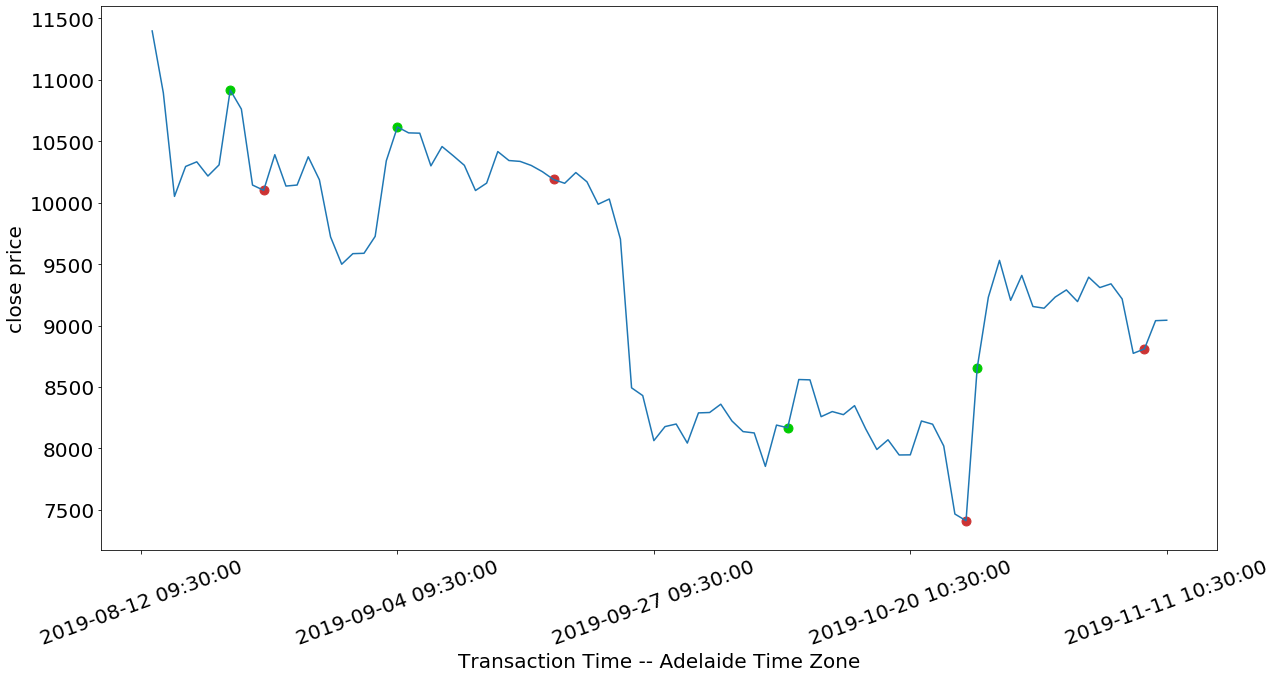

In [38]:
record = {}
run_bot('1d','1 day','3 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-07-11 11:30:00
Investment End Time:2019-11-11 11:30:00
Investment Periods: 123
Current Money:0.0017456299994478286
Current Bitcoin: 0.051588999999999996
Current BNB: 1.192794764512502
Return on Investment is:-17.220694964199247%
Current Total Assert is: 488.39789971122445
Trading curb occured


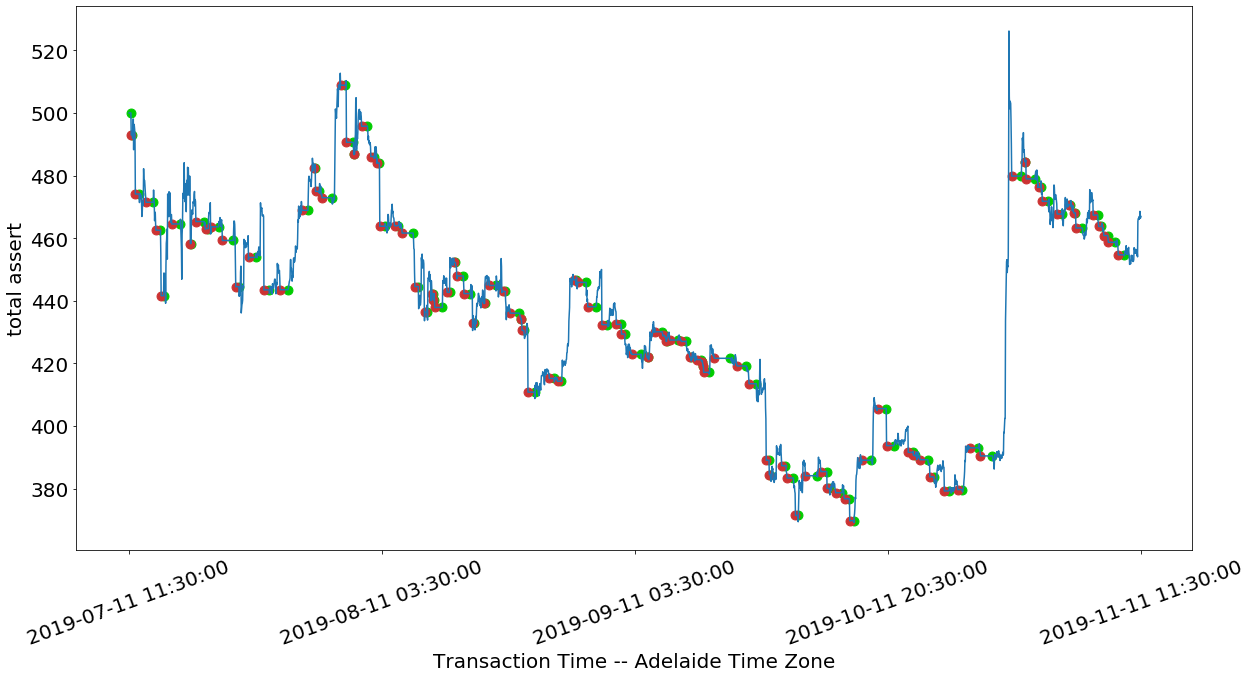

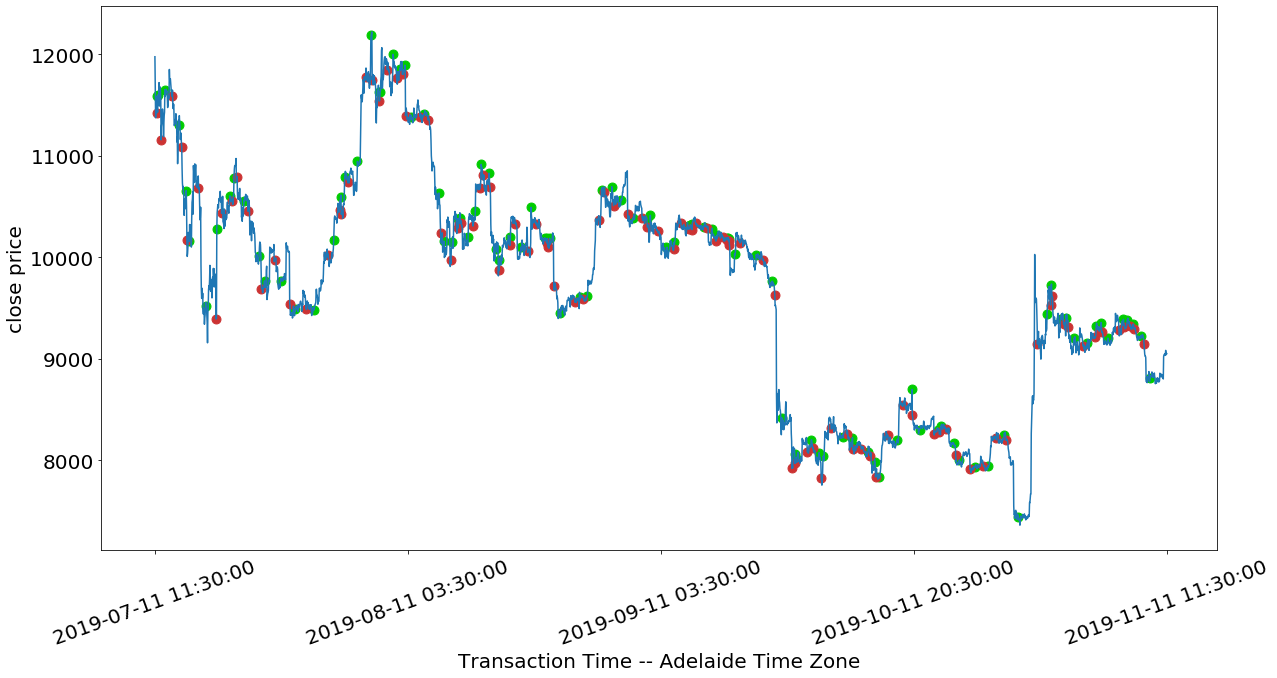

In [39]:
record = {}
run_bot('1h','1 hour','4 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-07-11 11:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 122
Current Money:0.005443889999753537
Current Bitcoin: 0.050647
Current BNB: 2.929350319326665
Return on Investment is:-13.366402164766159%
Current Total Assert is: 511.13822722787967
Trading curb occured


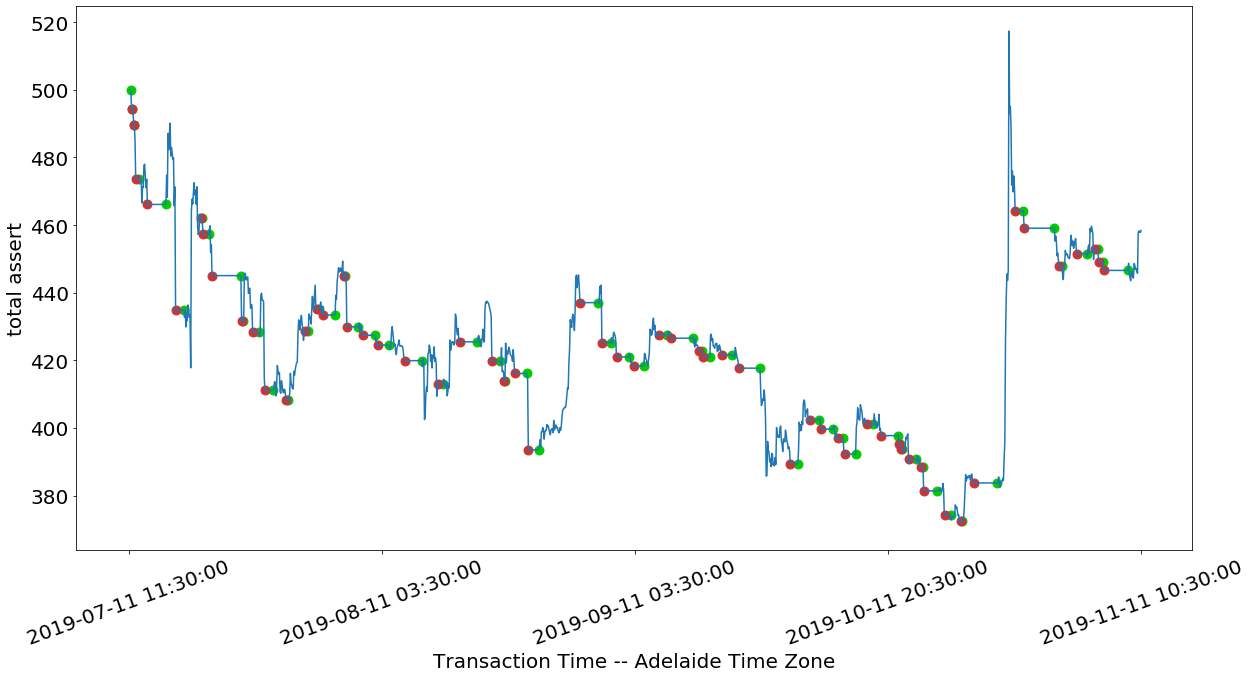

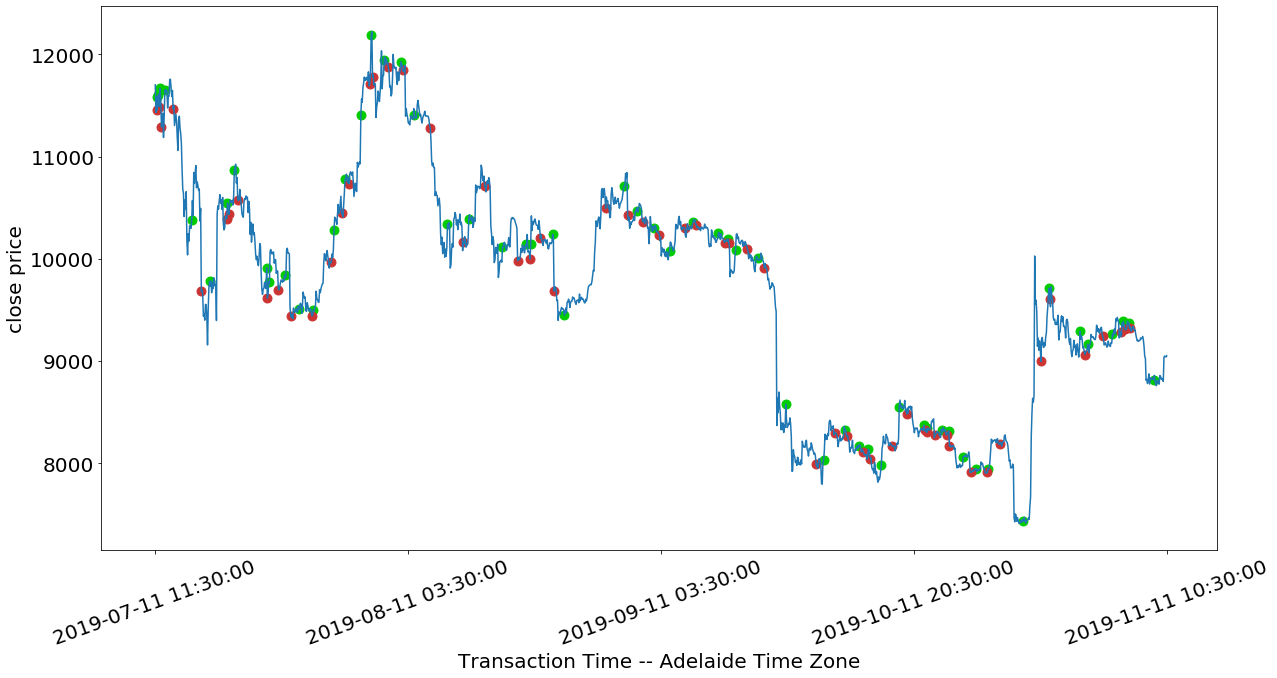

In [40]:
record = {}
run_bot('2h','2 hour','4 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-07-11 13:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 122
Current Money:0.008336950000170873
Current Bitcoin: 0.064538
Current BNB: 4.106612044449162
Return on Investment is:11.5320082762856%
Current Total Assert is: 658.038848830085


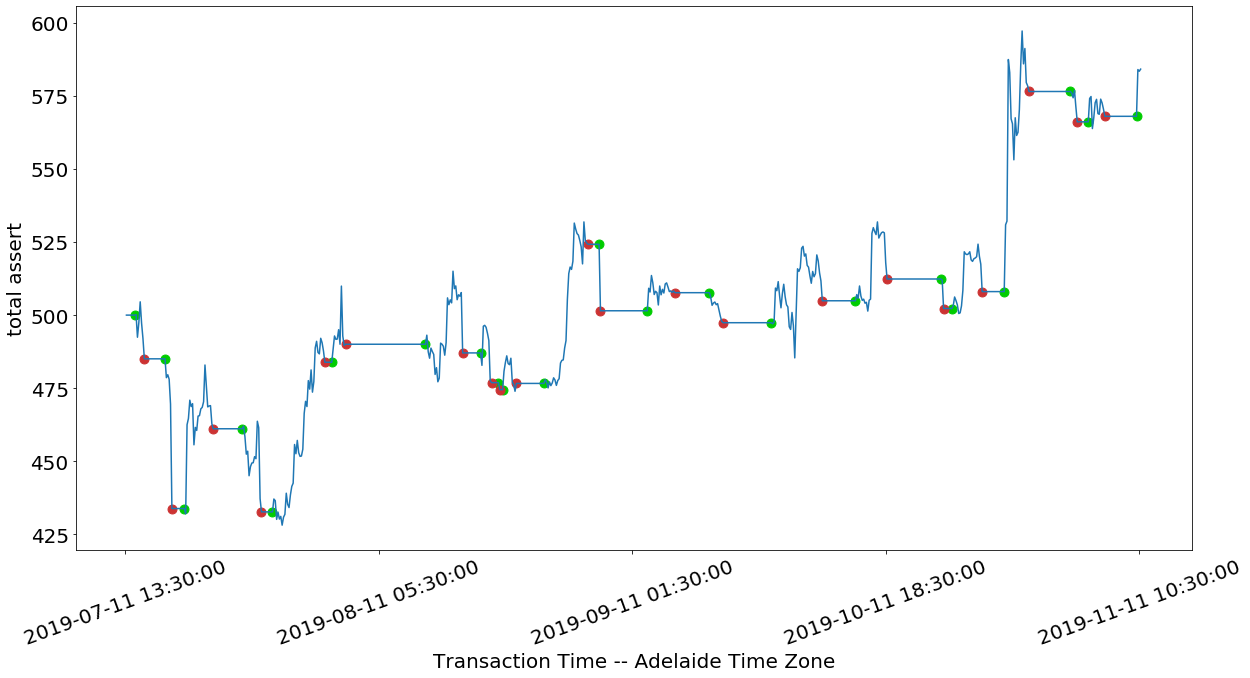

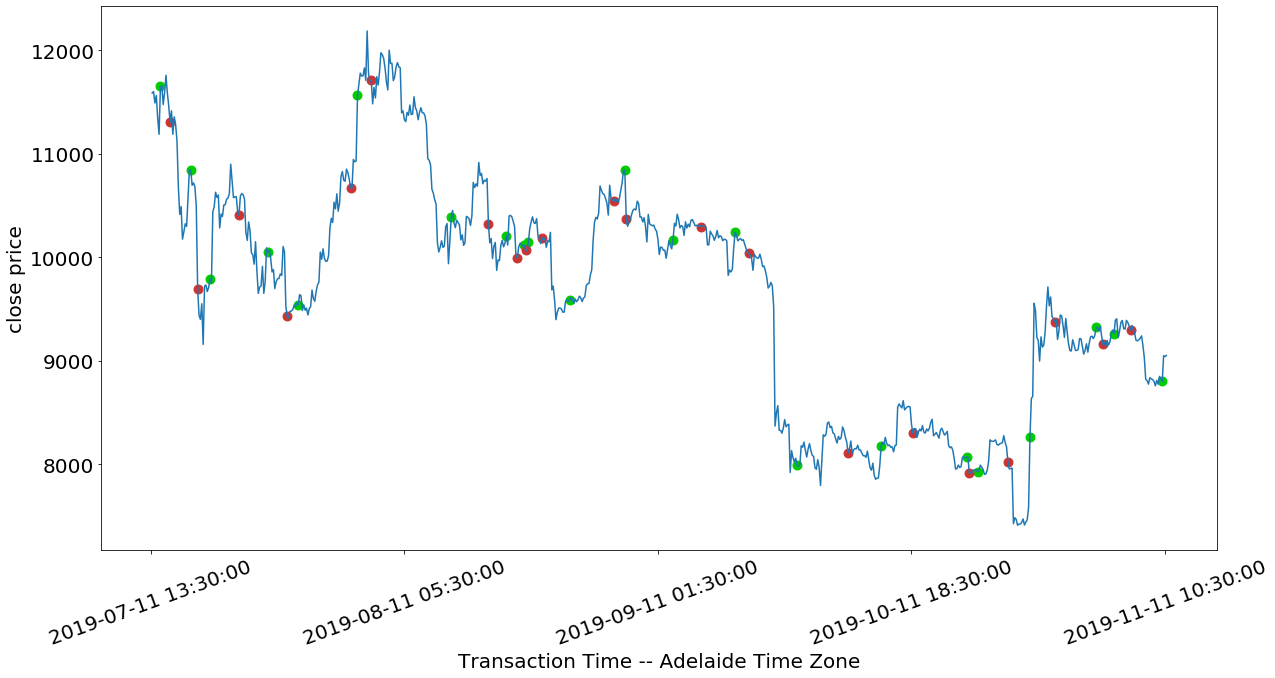

In [41]:
record = {}
run_bot('4h','4 hour','4 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-07-11 15:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 122
Current Money:0.006658920000177204
Current Bitcoin: 0.059592
Current BNB: 4.253328837899166
Return on Investment is:4.407169627489003%
Current Total Assert is: 616.0023008021851


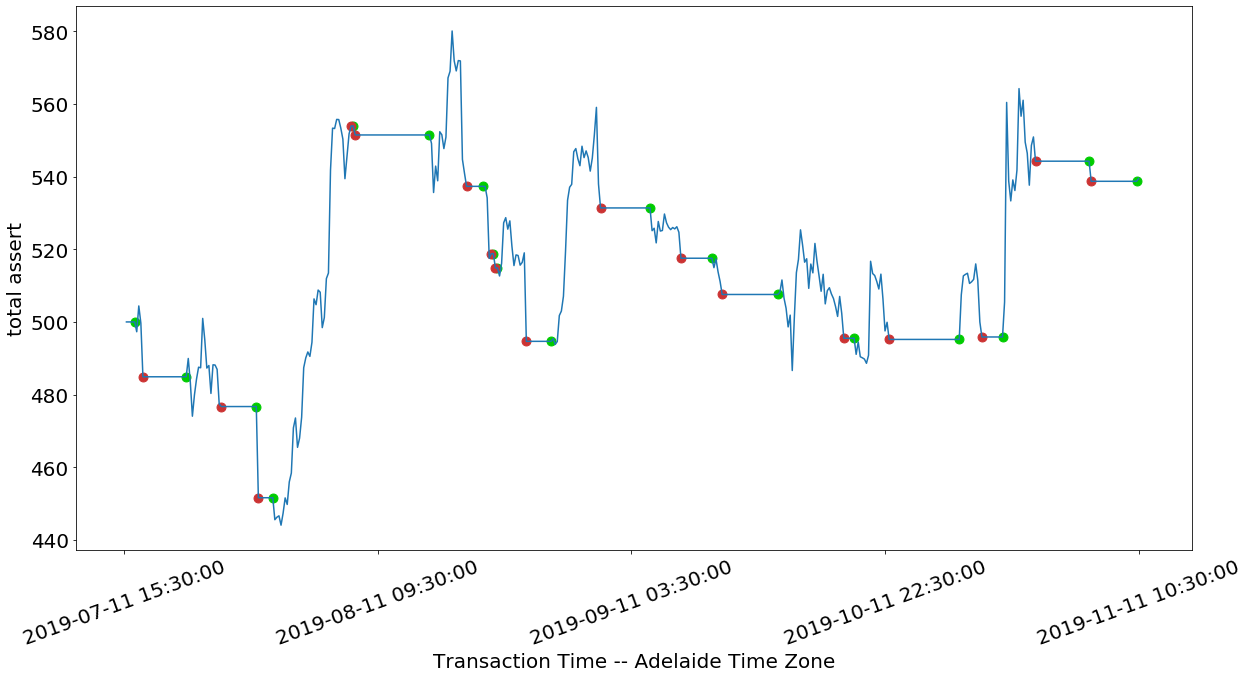

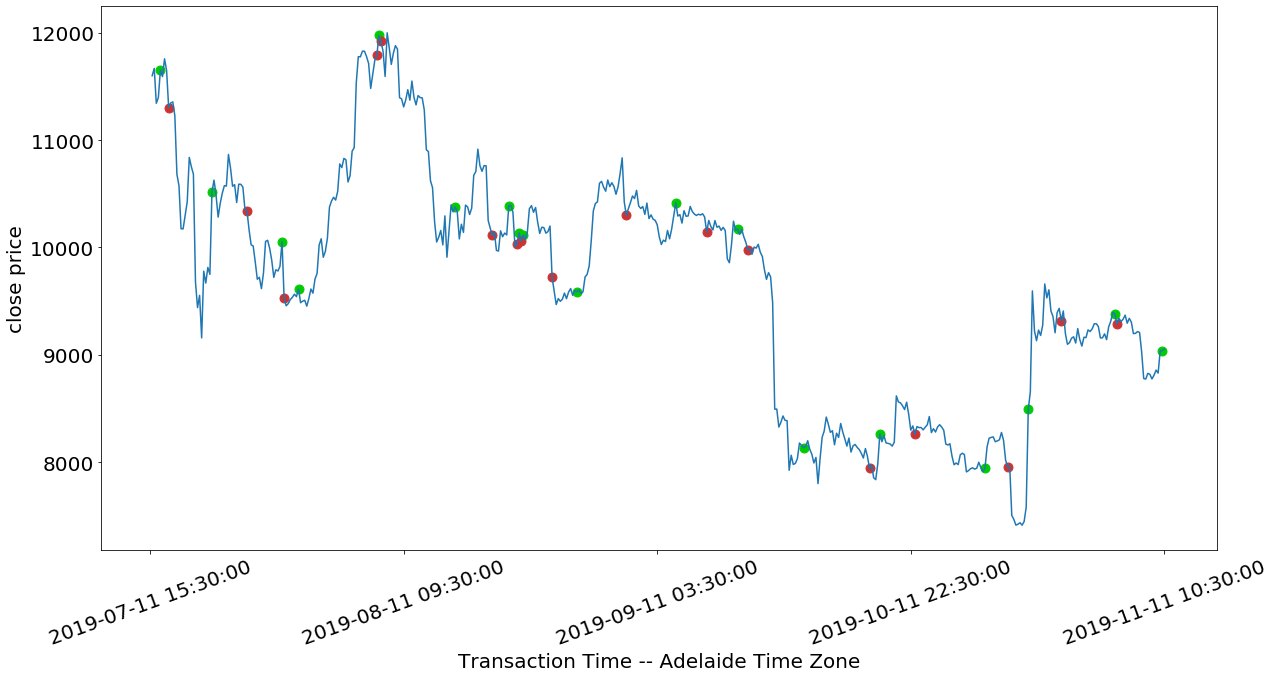

In [42]:
record = {}
run_bot('6h','6 hour','4 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-07-11 21:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 122
Current Money:469.47572911000015
Current Bitcoin: 0
Current BNB: 4.670677817502918
Return on Investment is:-6.178316978804622%
Current Total Assert is: 553.5479298250527


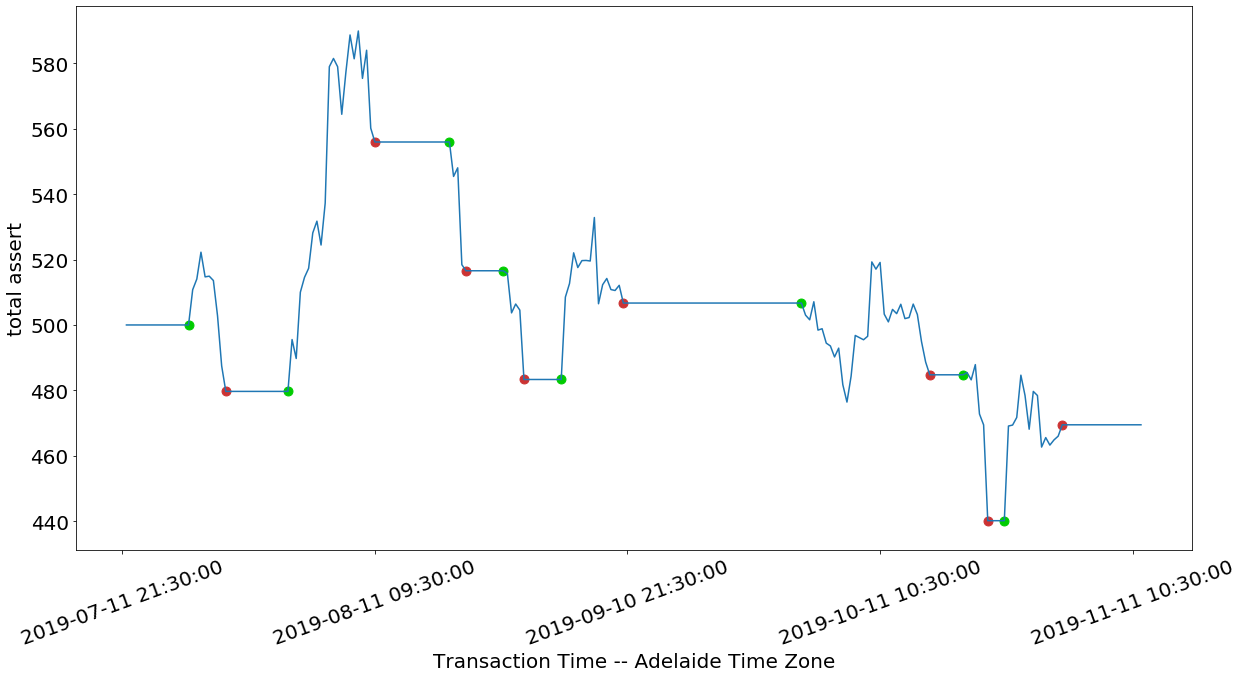

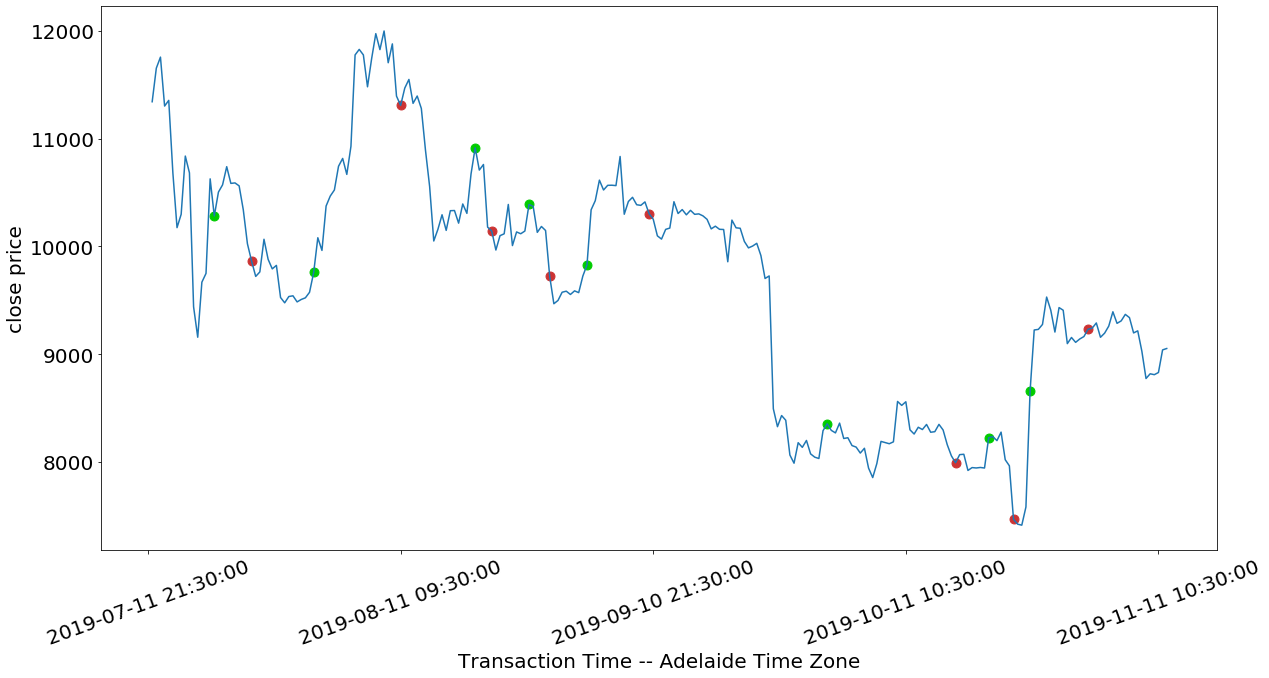

In [43]:
record = {}
run_bot('12h','12 hour','4 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-07-12 09:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 122
Current Money:402.46057430999997
Current Bitcoin: 0
Current BNB: 4.8161002994775
Return on Investment is:-17.09315598295001%
Current Total Assert is: 489.15037970059495
Trading curb occured


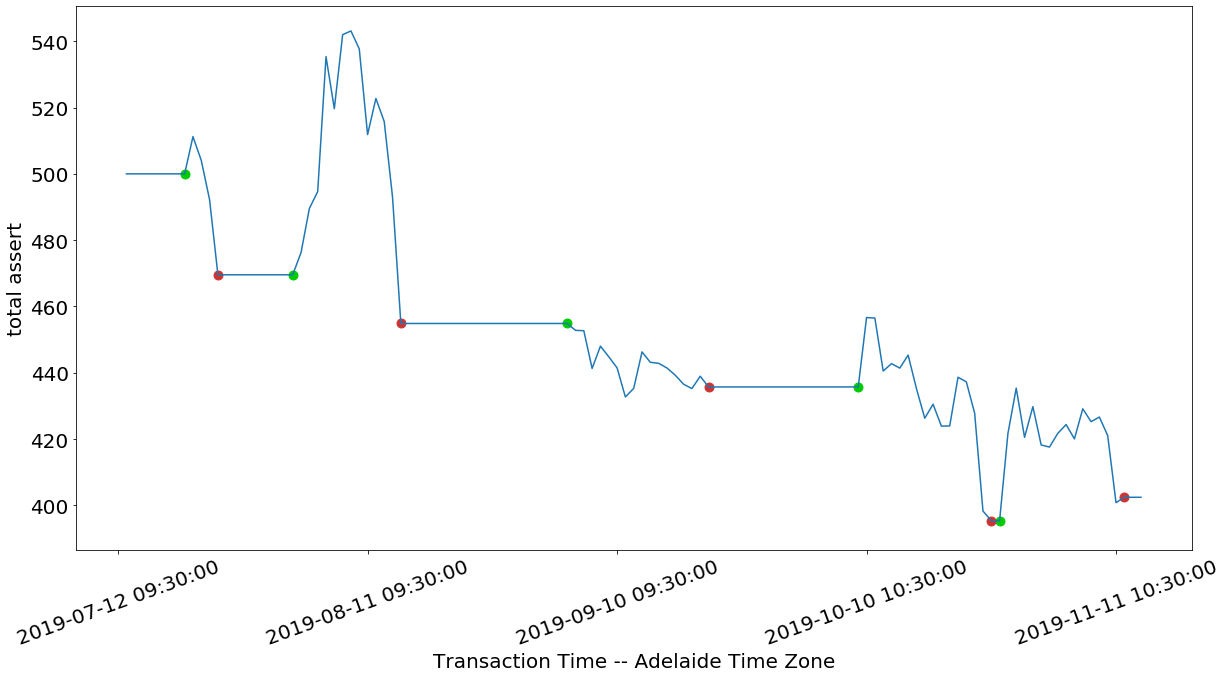

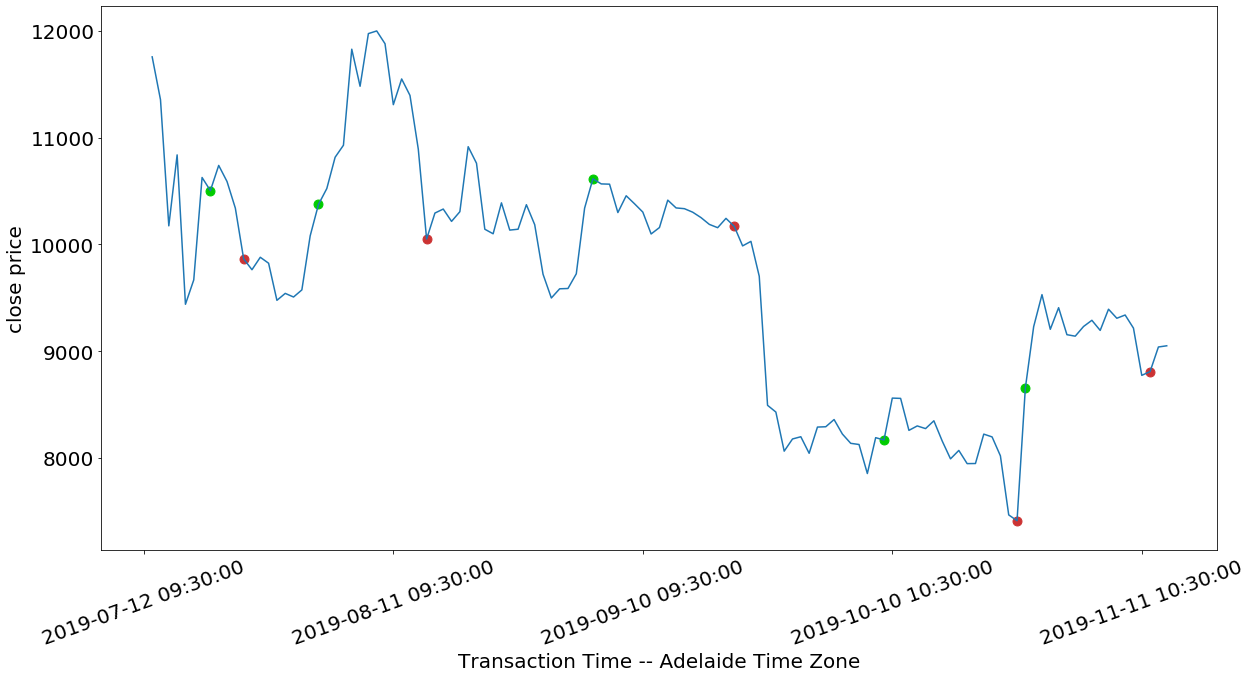

In [44]:
record = {}
run_bot('1d','1 day','4 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-06-11 11:30:00
Investment End Time:2019-11-11 11:30:00
Investment Periods: 153
Current Money:0.005973390000121981
Current Bitcoin: 0.06705
Current BNB: -0.0032435726845859367
Return on Investment is:2.900138657911442%
Current Total Assert is: 607.1108180816775


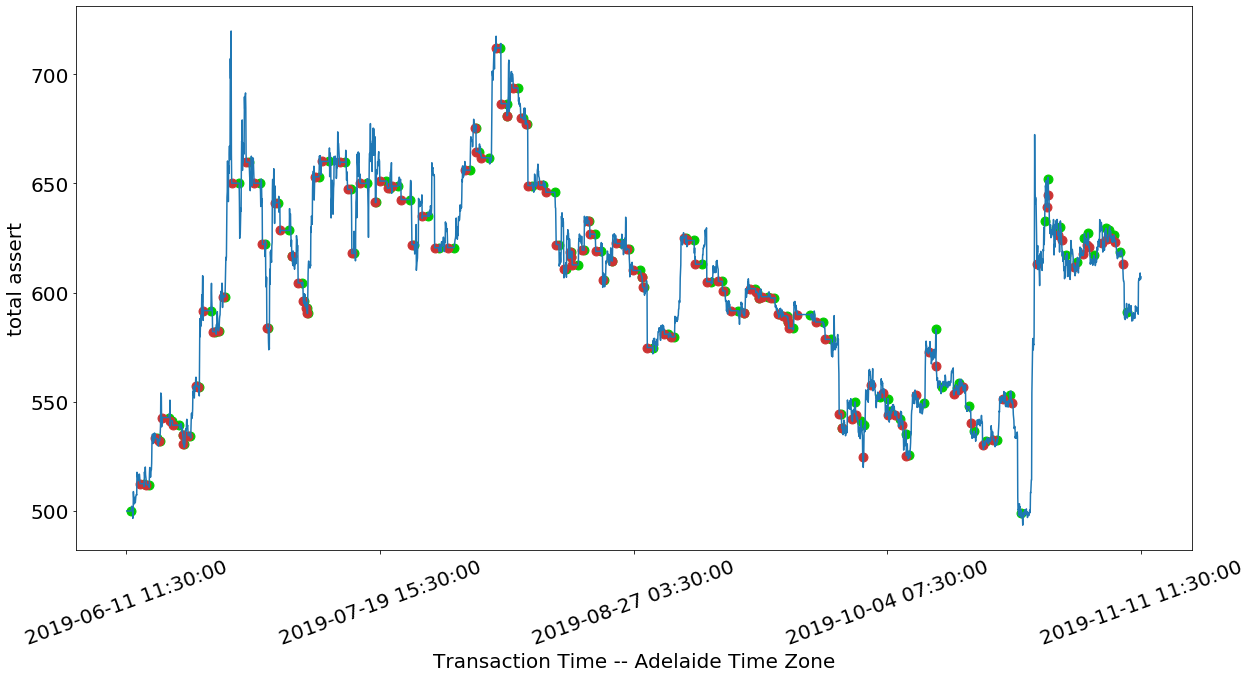

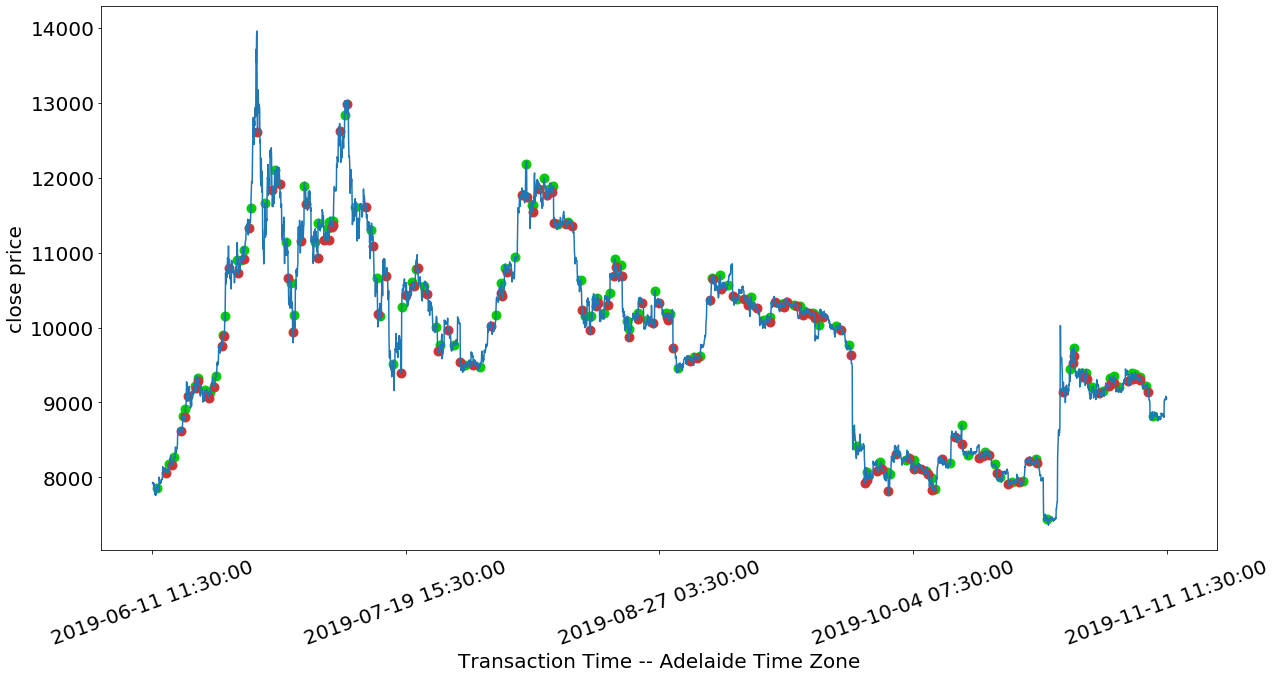

In [45]:
record = {}
run_bot('1h','1 hour','5 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-06-11 11:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 152
Current Money:0.007130770000230768
Current Bitcoin: 0.083302
Current BNB: 1.2270163827104175
Return on Investment is:31.5968403964047%
Current Total Assert is: 776.4213583387877


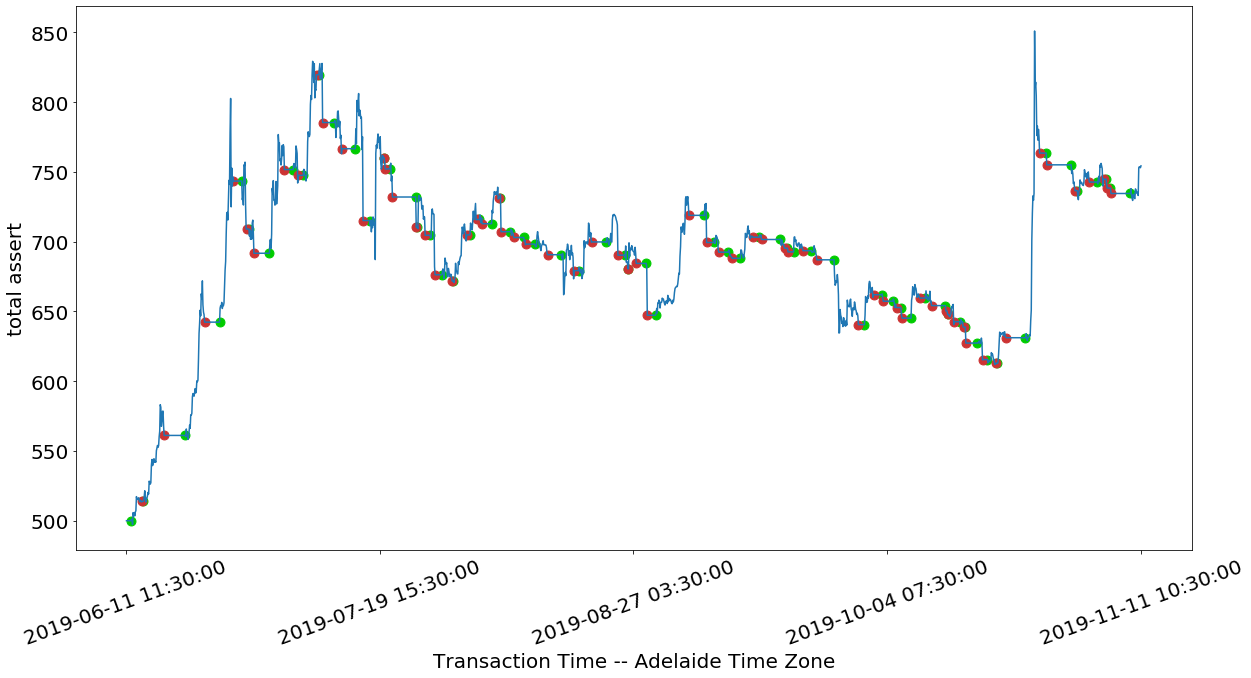

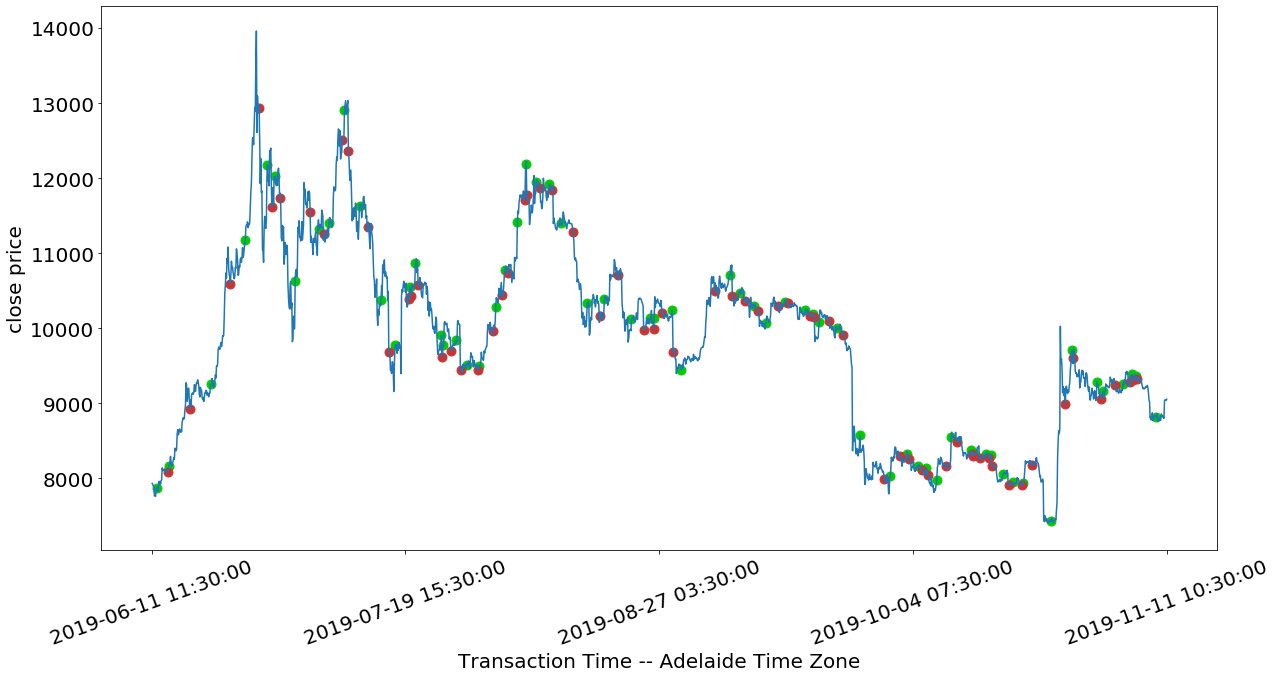

In [46]:
record = {}
run_bot('2h','2 hour','5 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-06-11 13:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 152
Current Money:0.003622319999408319
Current Bitcoin: 0.093389
Current BNB: 3.388601891392087
Return on Investment is:53.672158617806254%
Current Total Assert is: 906.6657358450569


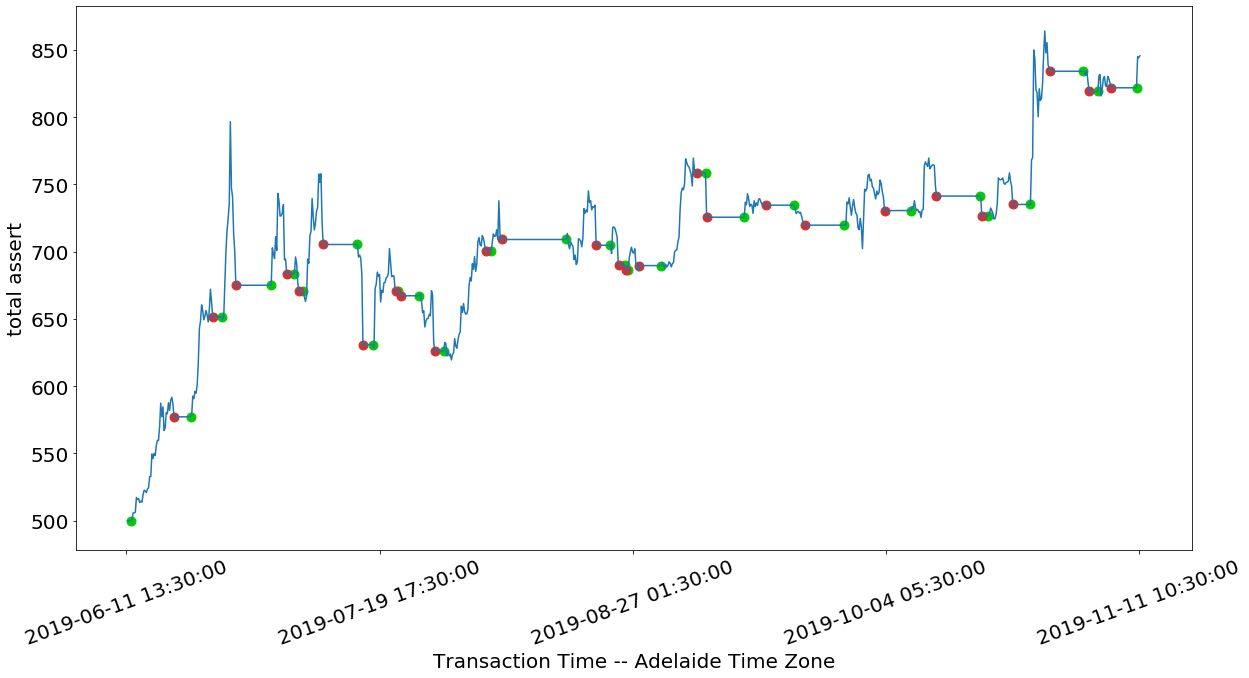

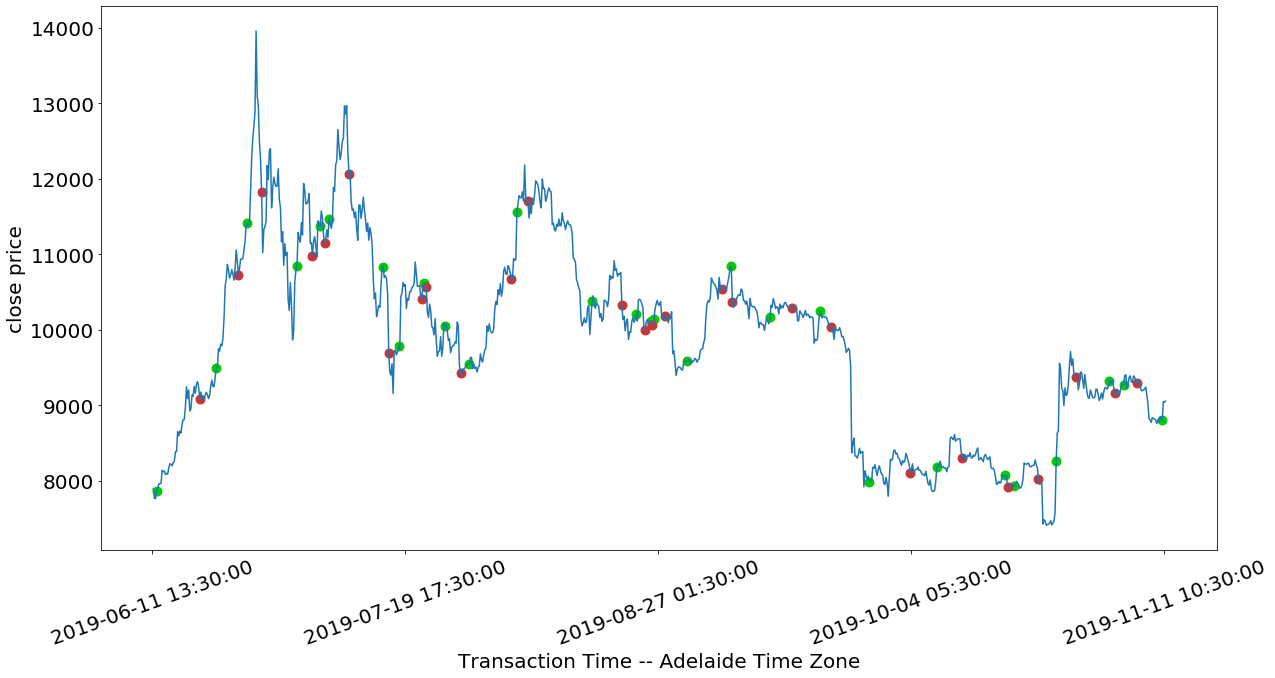

In [47]:
record = {}
run_bot('4h','4 hour','5 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-06-11 15:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 152
Current Money:0.004599179999786429
Current Bitcoin: 0.070647
Current BNB: 4.023493642342084
Return on Investment is:20.69911291900971%
Current Total Assert is: 712.1247662221573


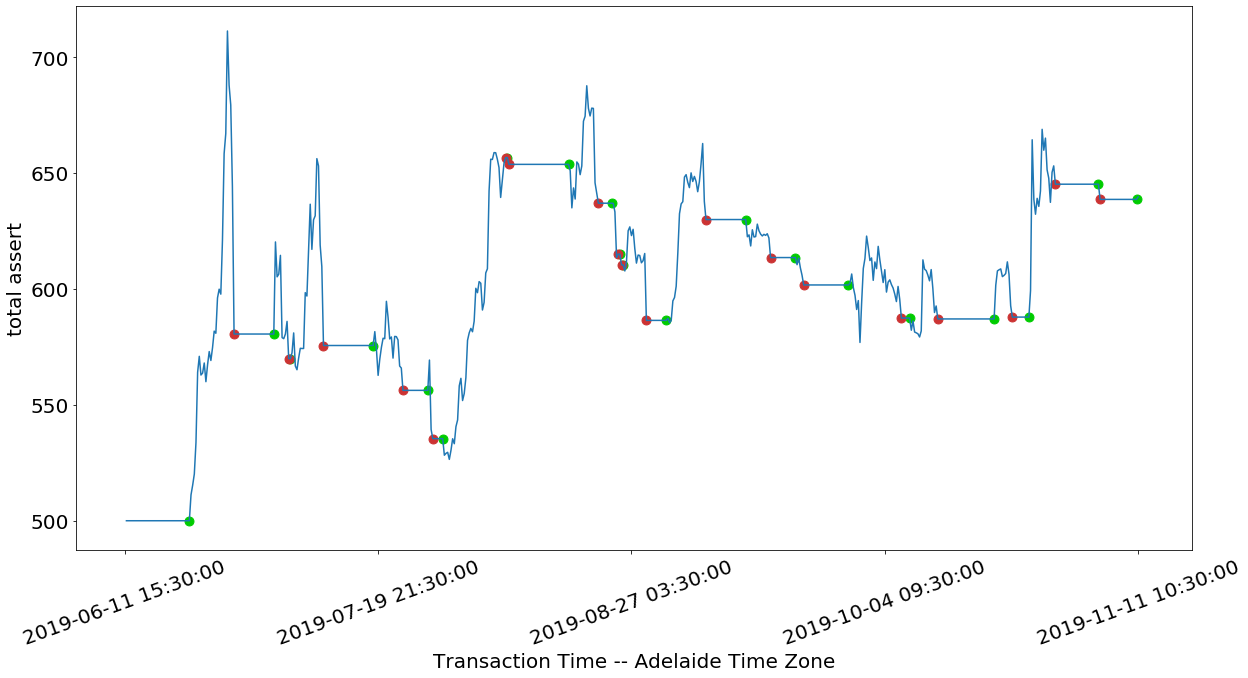

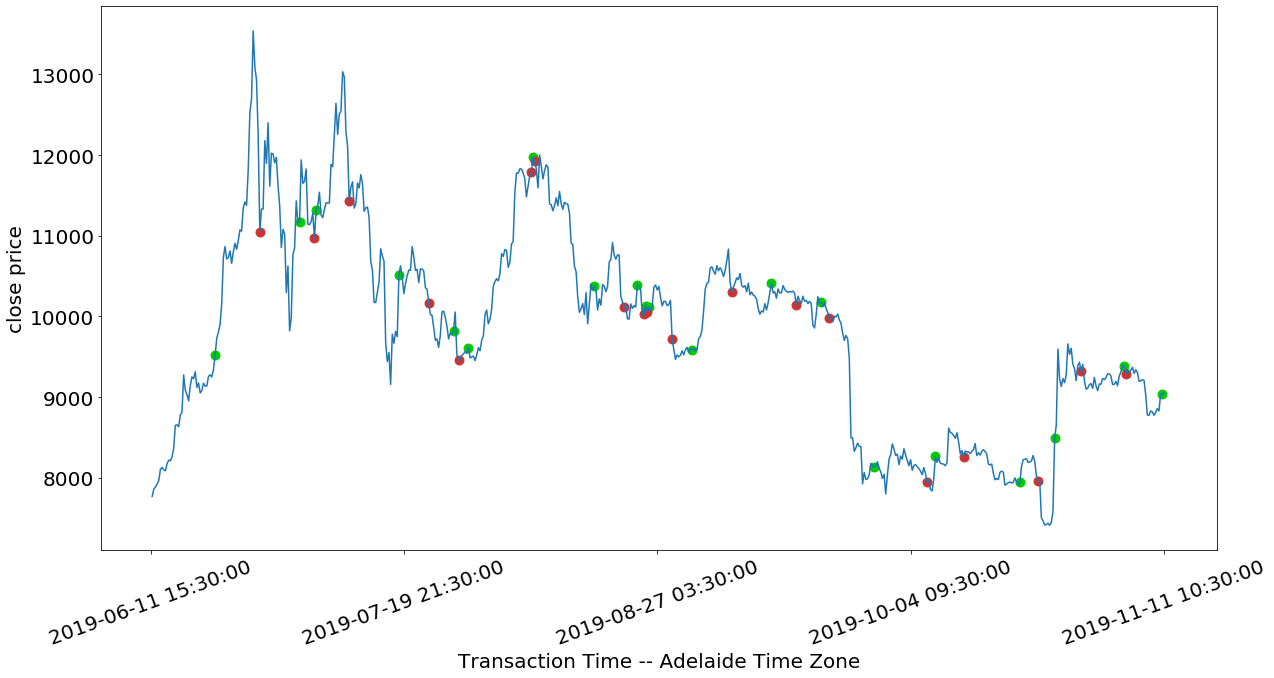

In [48]:
record = {}
run_bot('6h','6 hour','5 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-06-11 21:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 152
Current Money:435.5785068800001
Current Bitcoin: 0
Current BNB: 4.653108400524583
Return on Investment is:-11.977210493314814%
Current Total Assert is: 519.3344580894426
Trading curb occured


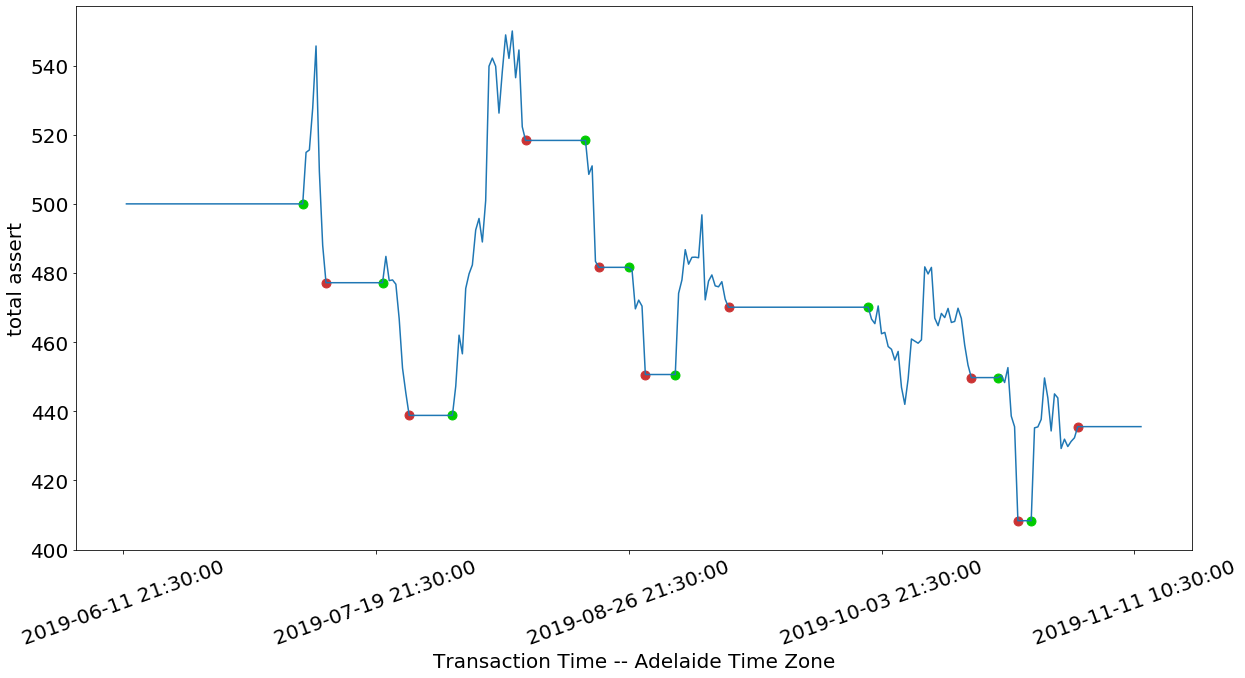

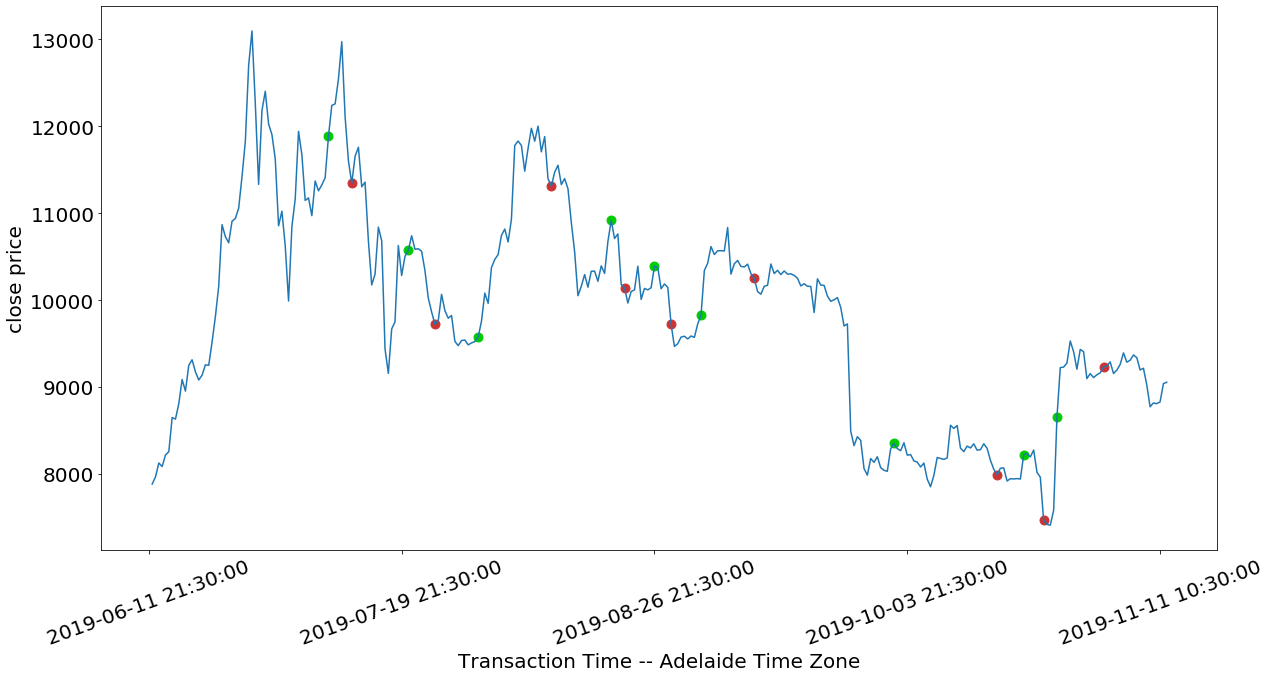

In [49]:
record = {}
run_bot('12h','12 hour','5 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-06-12 09:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 152
Current Money:387.52971597000004
Current Bitcoin: 0
Current BNB: 4.822149633773333
Return on Investment is:-19.60535434272542%
Current Total Assert is: 474.32840937792
Trading curb occured


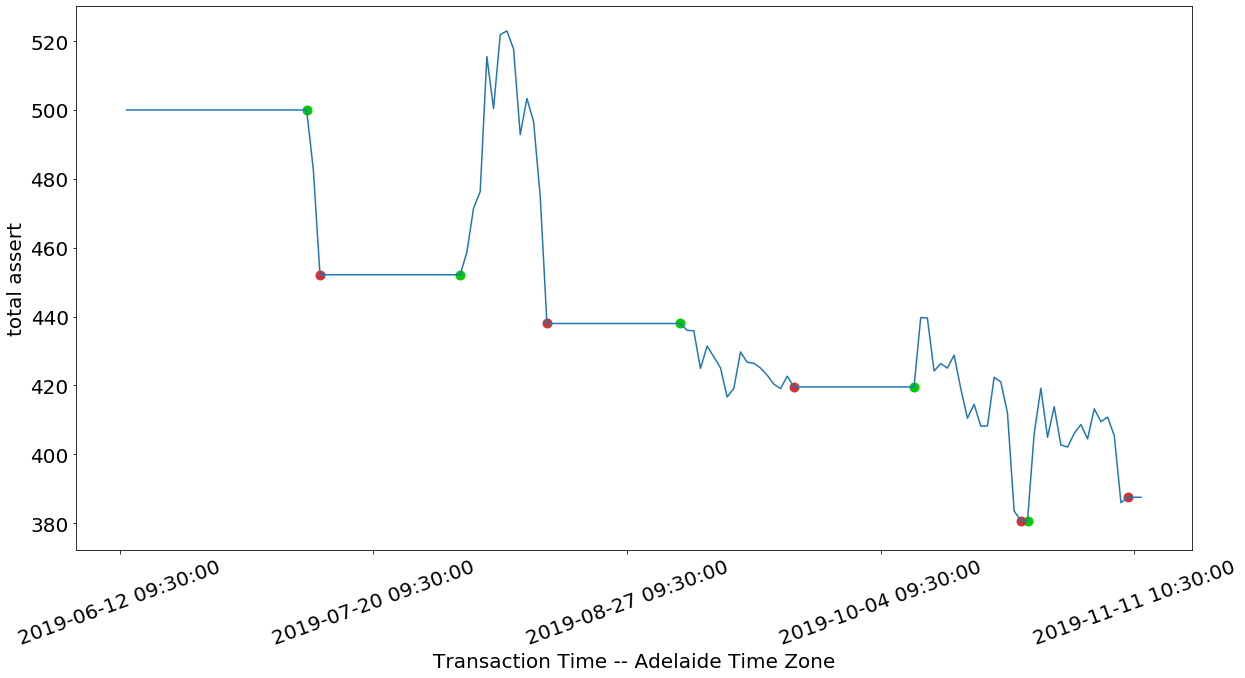

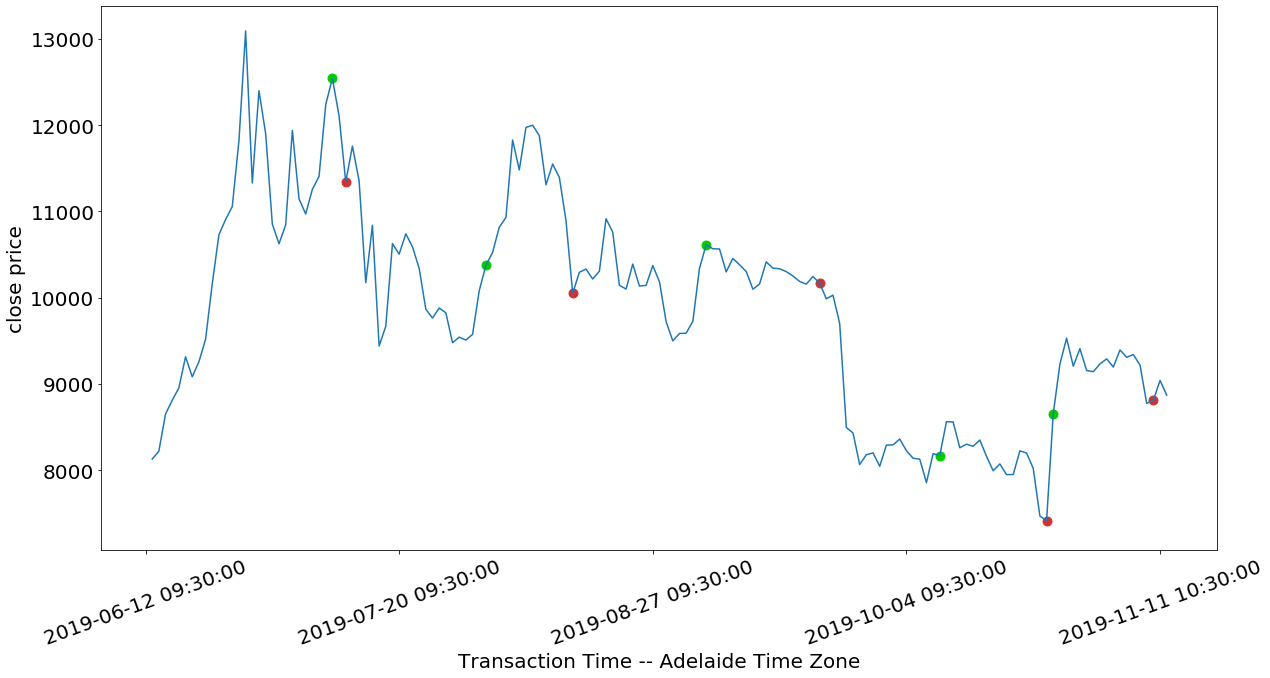

In [63]:
record = {}
run_bot('1d','1 day','5 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-05-11 12:30:00
Investment End Time:2019-11-11 12:30:00
Investment Periods: 184
Current Money:0.0011956200002032347
Current Bitcoin: 0.07388399999999999
Current BNB: -0.008347876939166141
Return on Investment is:13.388052046626298%
Current Total Assert is: 668.9895070750952


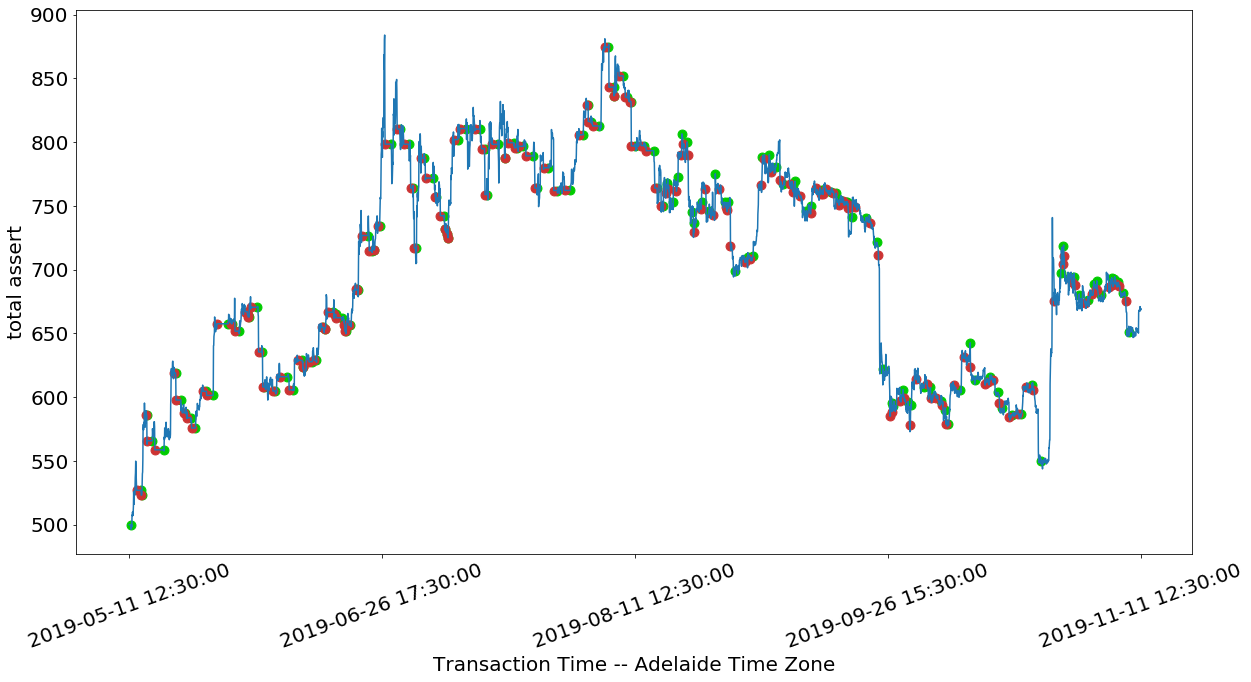

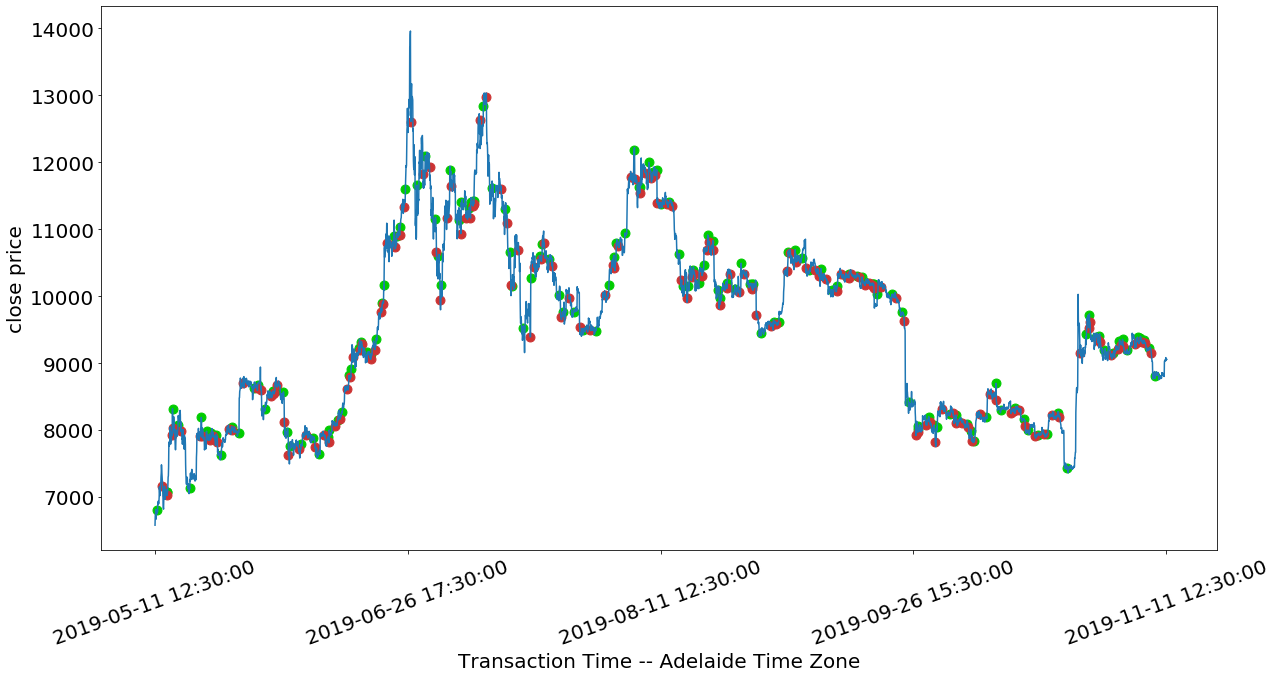

In [51]:
record = {}
run_bot('1h','1 hour','6 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-05-11 13:30:00
Investment End Time:2019-11-11 12:30:00
Investment Periods: 183
Current Money:0.001528339999936179
Current Bitcoin: 0.096942
Current BNB: 0.08945287942750232
Return on Investment is:49.06401975079575%
Current Total Assert is: 879.4777165296949


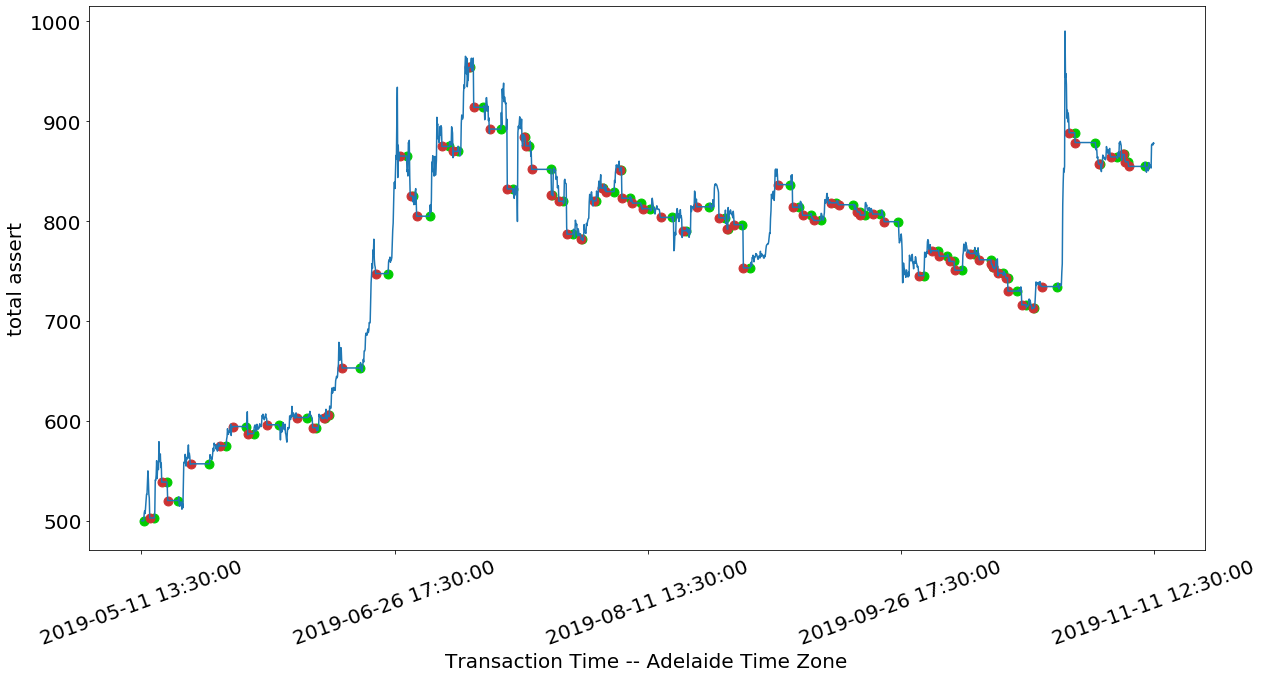

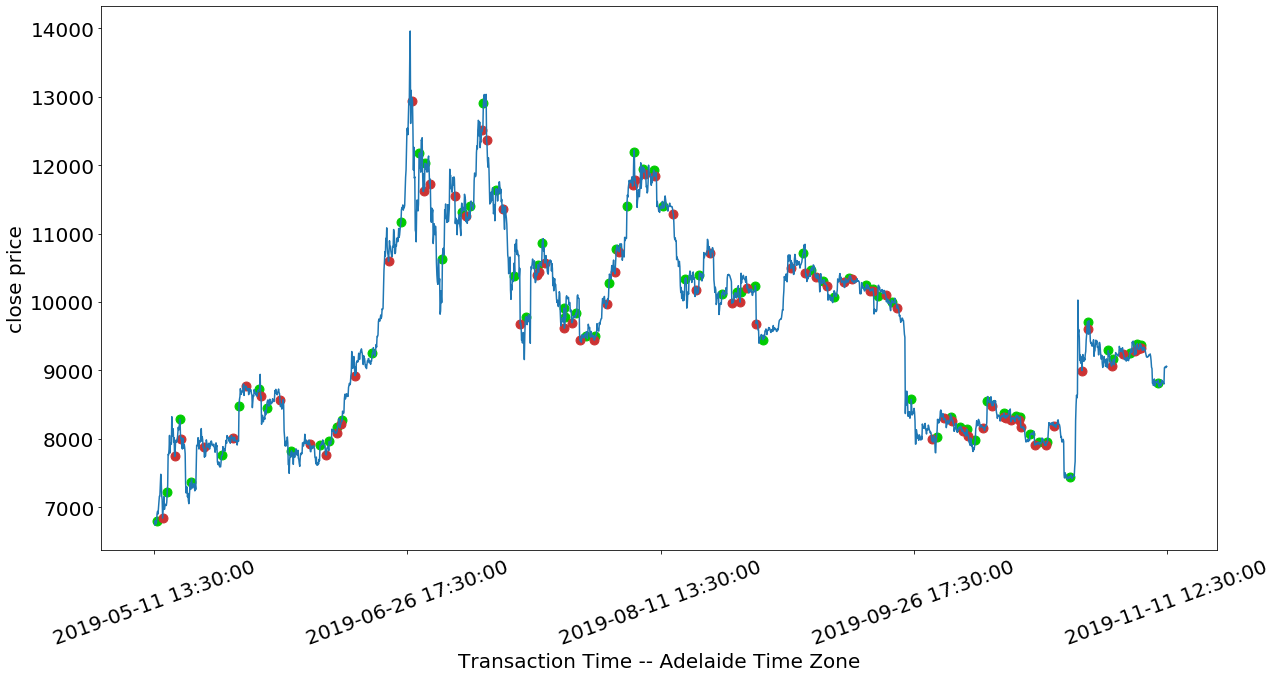

In [52]:
record = {}
run_bot('2h','2 hour','6 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-05-11 13:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 183
Current Money:0.003468459999908191
Current Bitcoin: 0.10419099999999999
Current BNB: 2.8529091920675036
Return on Investment is:68.62944026393475%
Current Total Assert is: 994.9136975572151


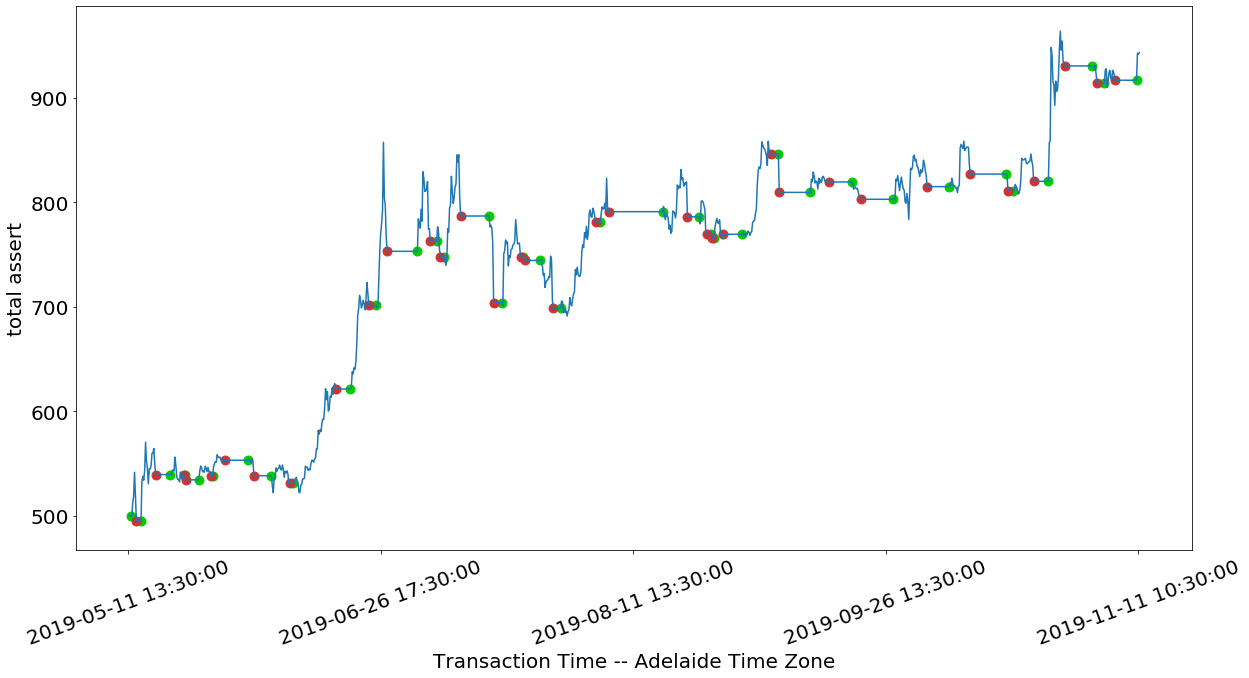

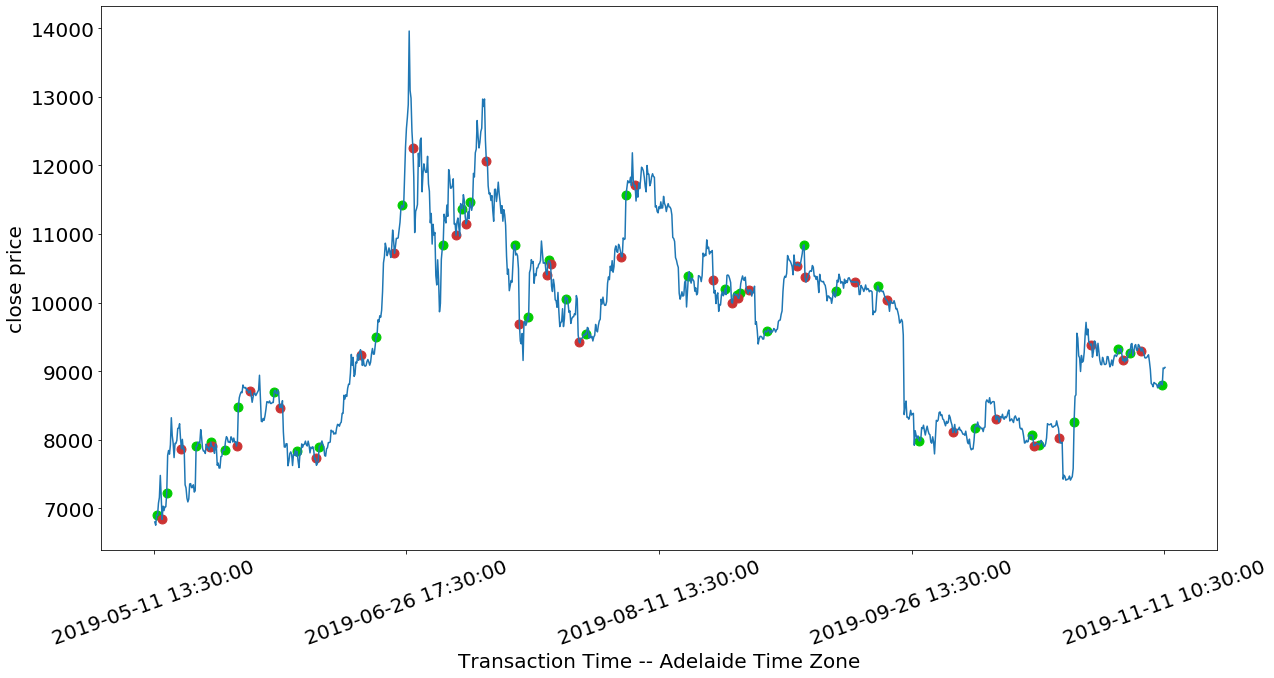

In [53]:
record = {}
run_bot('4h','4 hour','6 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-05-11 15:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 183
Current Money:0.004286440000100811
Current Bitcoin: 0.08791099999999999
Current BNB: 3.5037763752733357
Return on Investment is:45.63642979405424%
Current Total Assert is: 859.25493578492


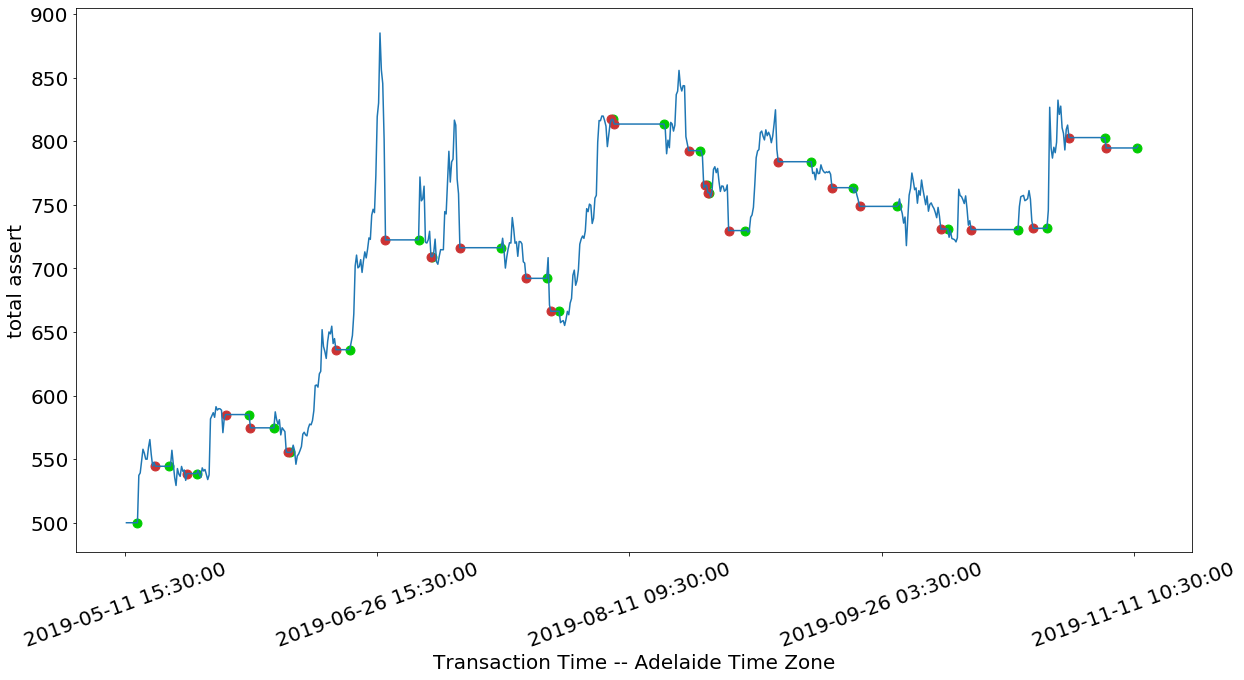

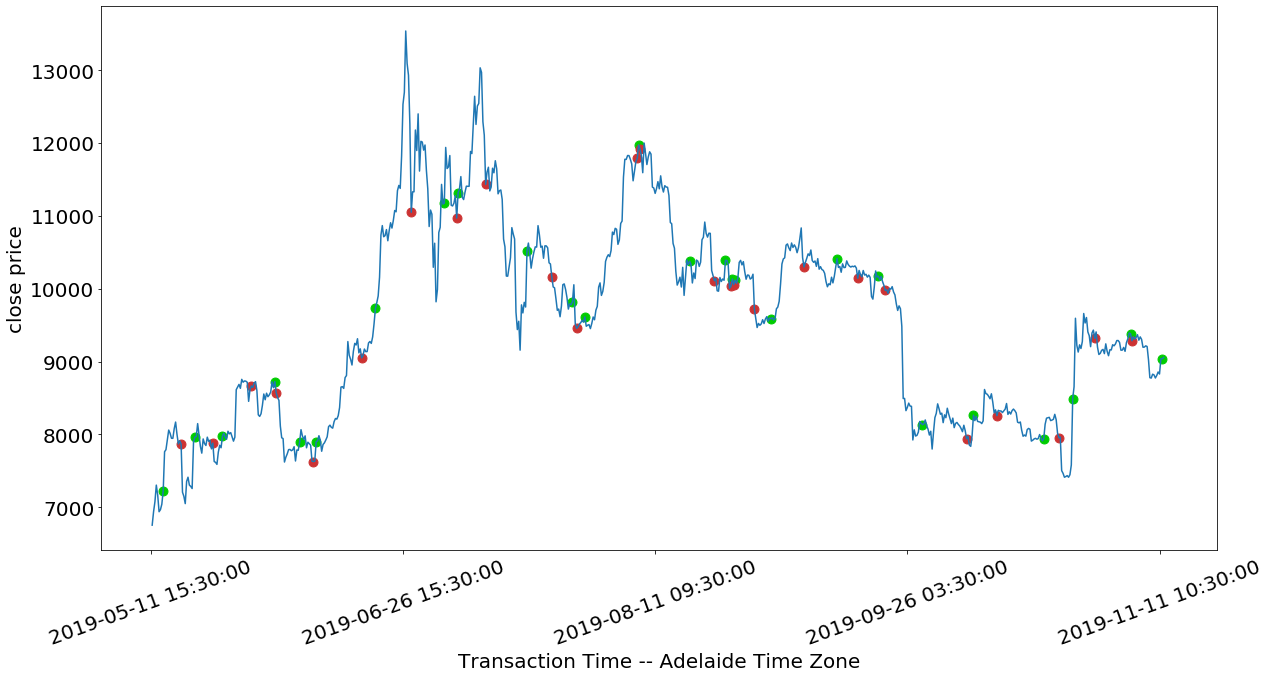

In [54]:
record = {}
run_bot('6h','6 hour','6 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-05-11 21:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 183
Current Money:616.9121367599998
Current Bitcoin: 0
Current BNB: 4.3383752647625
Return on Investment is:17.797100258597435%
Current Total Assert is: 695.0028915257249


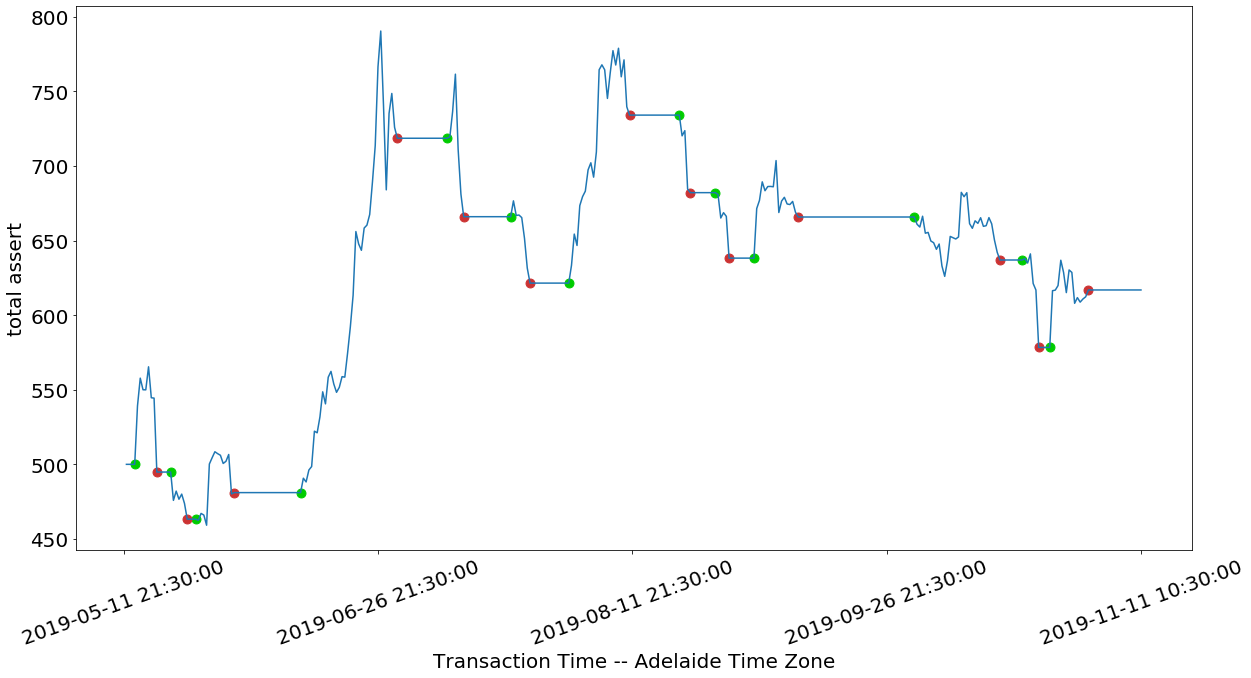

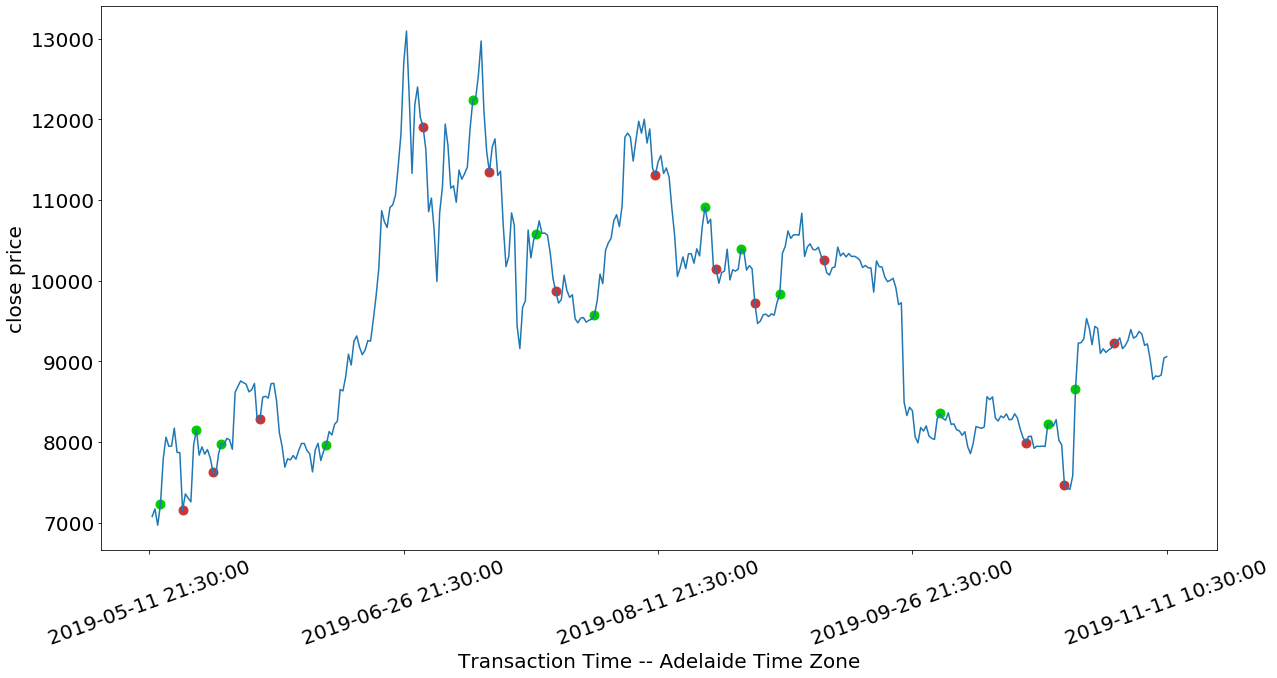

In [55]:
record = {}
run_bot('12h','12 hour','6 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-05-12 09:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 183
Current Money:494.7074957599999
Current Bitcoin: 0
Current BNB: 4.6481643308862495
Return on Investment is:-1.9704315735673852%
Current Total Assert is: 578.3744537159524


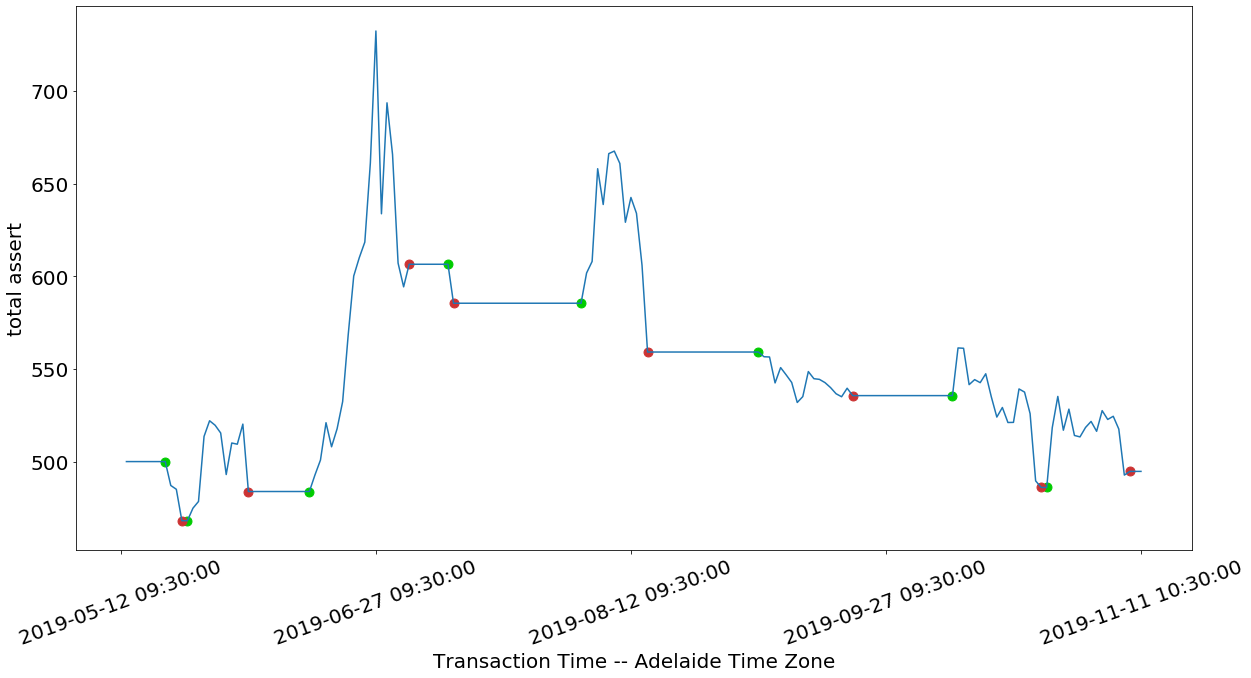

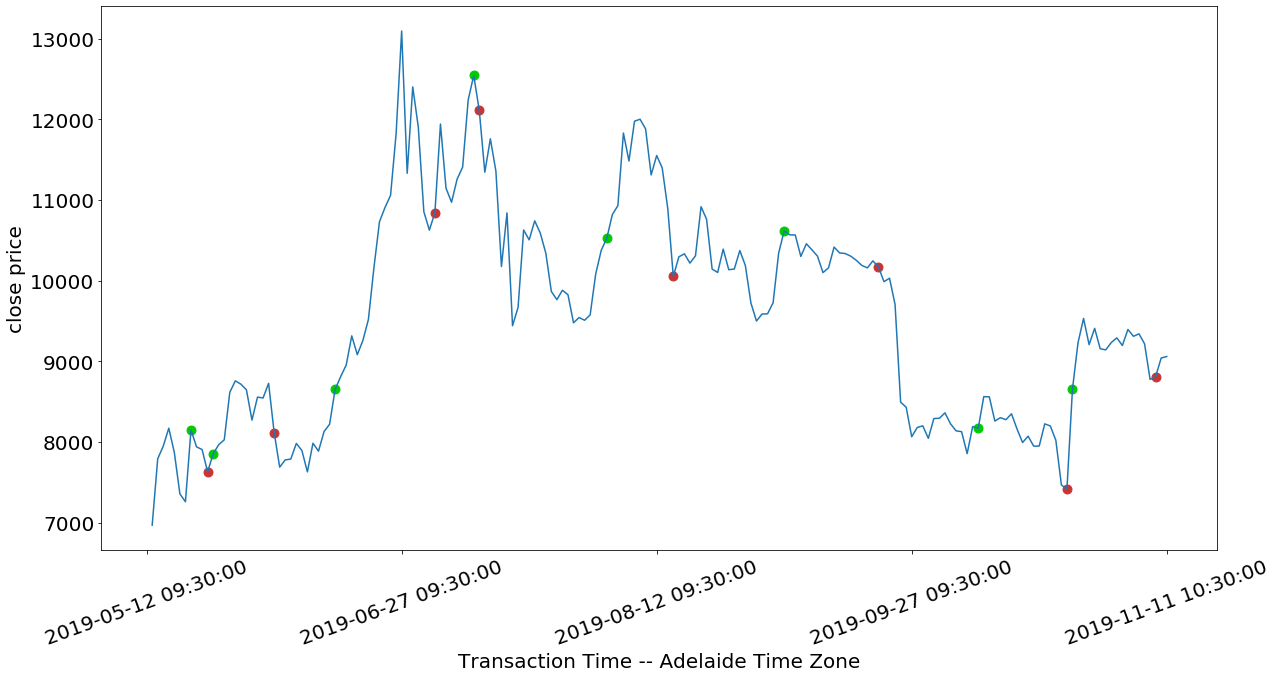

In [56]:
record = {}
run_bot('1d','1 day','6 months ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2018-11-11 13:30:00
Investment End Time:2019-11-11 12:30:00
Investment Periods: 364
Current Money:481.41205961000026
Current Bitcoin: 0
Current BNB: -0.0013949670879228222
Return on Investment is:-18.40899149111565%
Current Total Assert is: 481.38695020241767
Trading curb occured


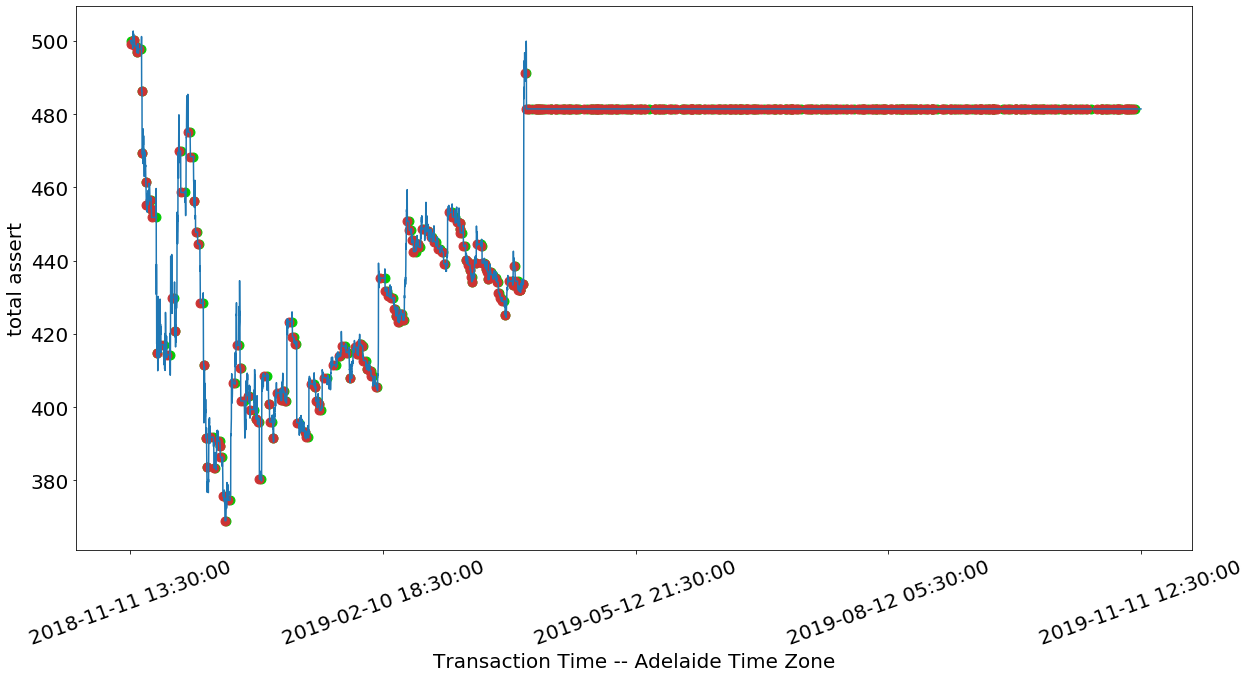

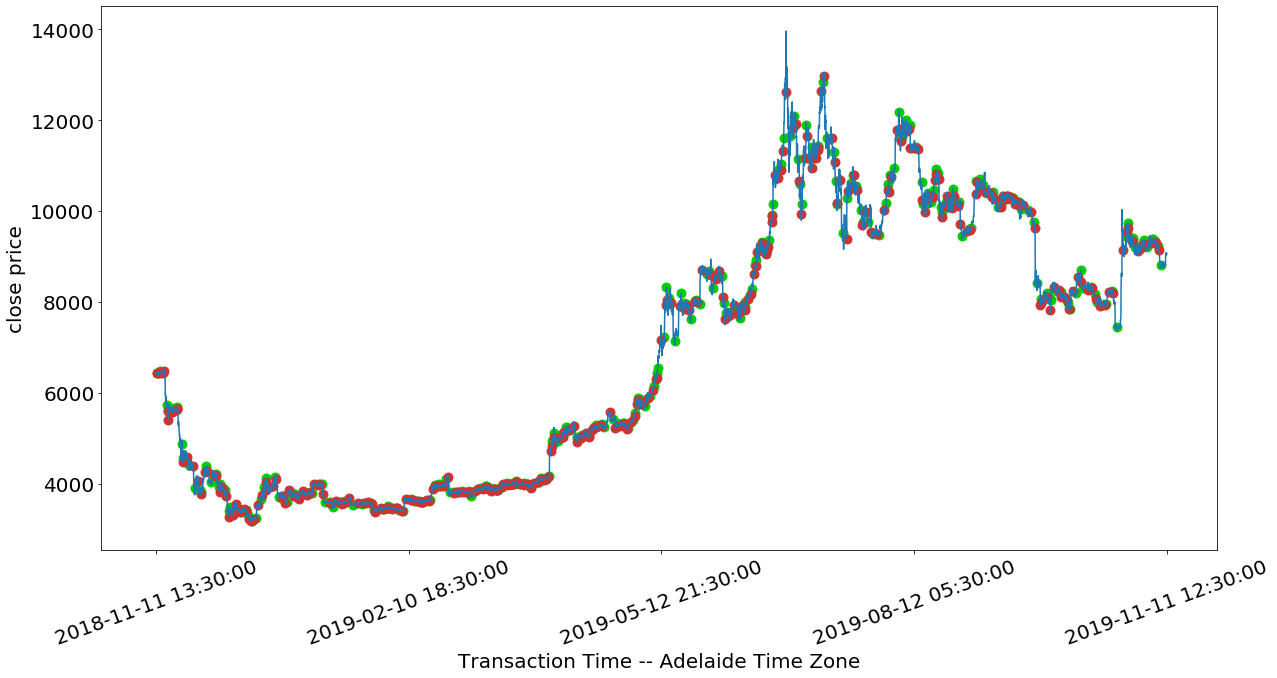

In [57]:
record = {}
run_bot('1h','1 hour','1 year ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2018-11-11 14:30:00
Investment End Time:2019-11-11 12:30:00
Investment Periods: 364
Current Money:971.9375203200003
Current Bitcoin: 0
Current BNB: -0.008988954226250352
Return on Investment is:64.7077490074454%
Current Total Assert is: 971.7757191439279


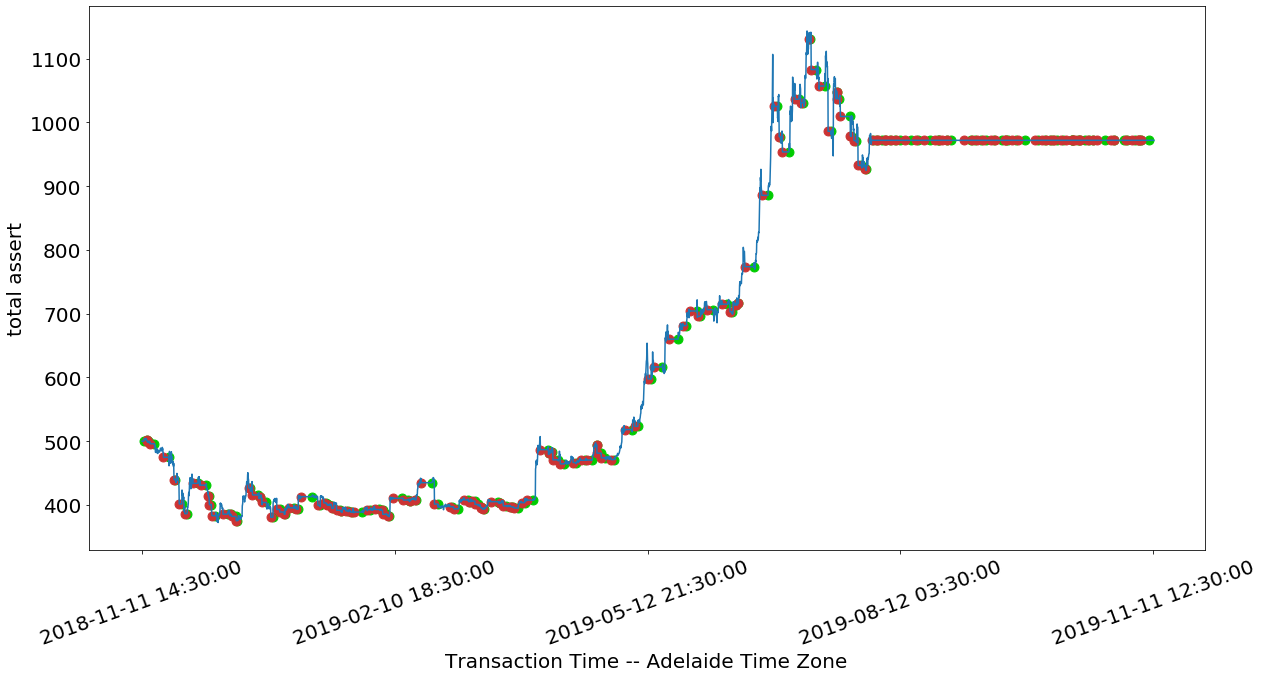

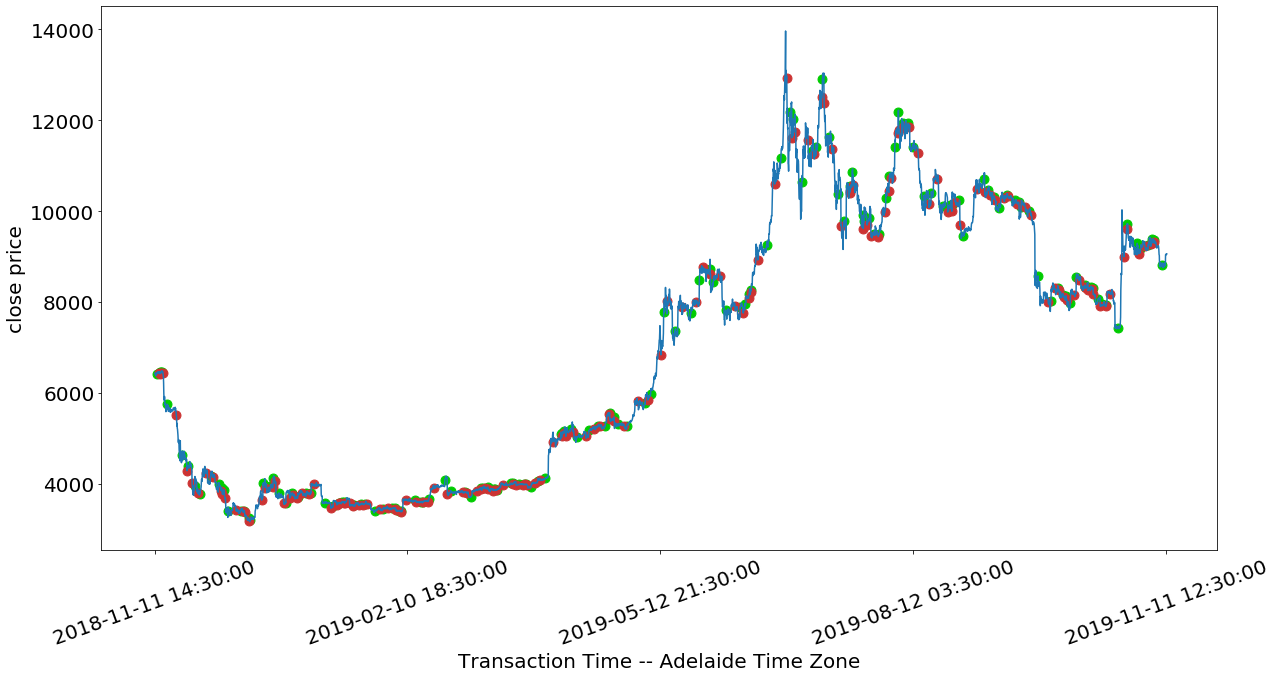

In [58]:
record = {}
run_bot('2h','2 hour','1 year ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2018-11-11 14:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 364
Current Money:0.007651369999962299
Current Bitcoin: 0.11562
Current BNB: 1.303024836663337
Return on Investment is:81.52720607287118%
Current Total Assert is: 1071.01051582994


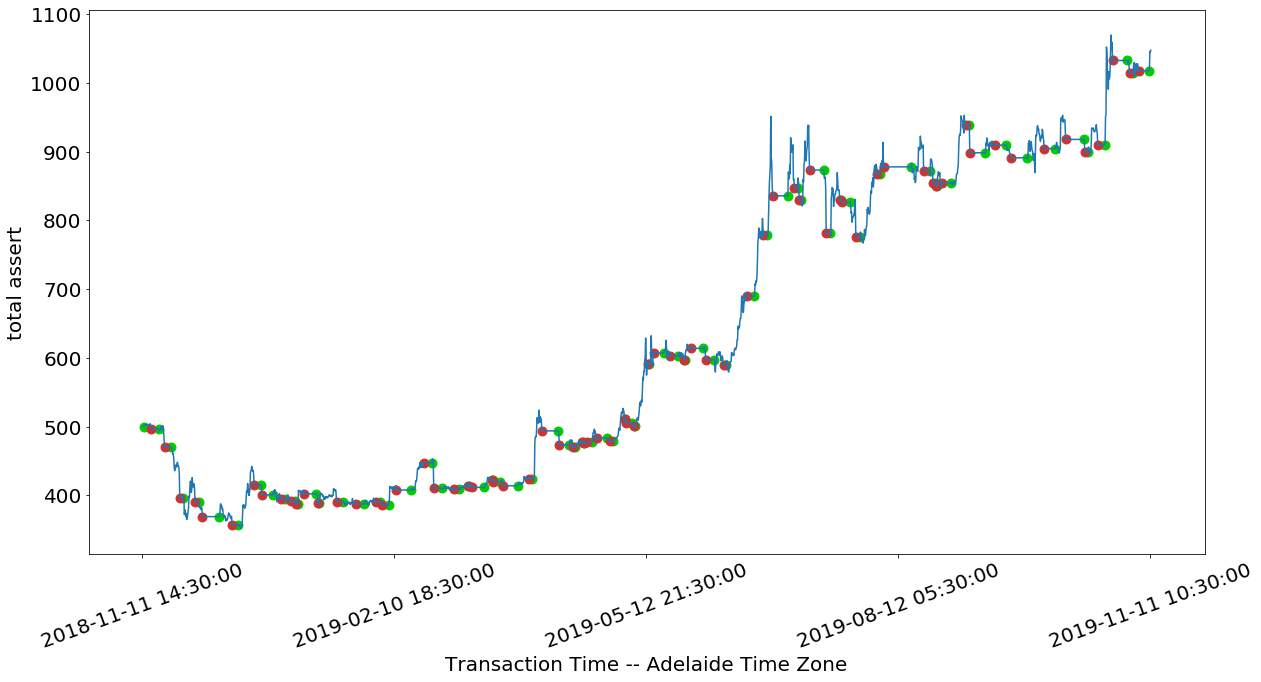

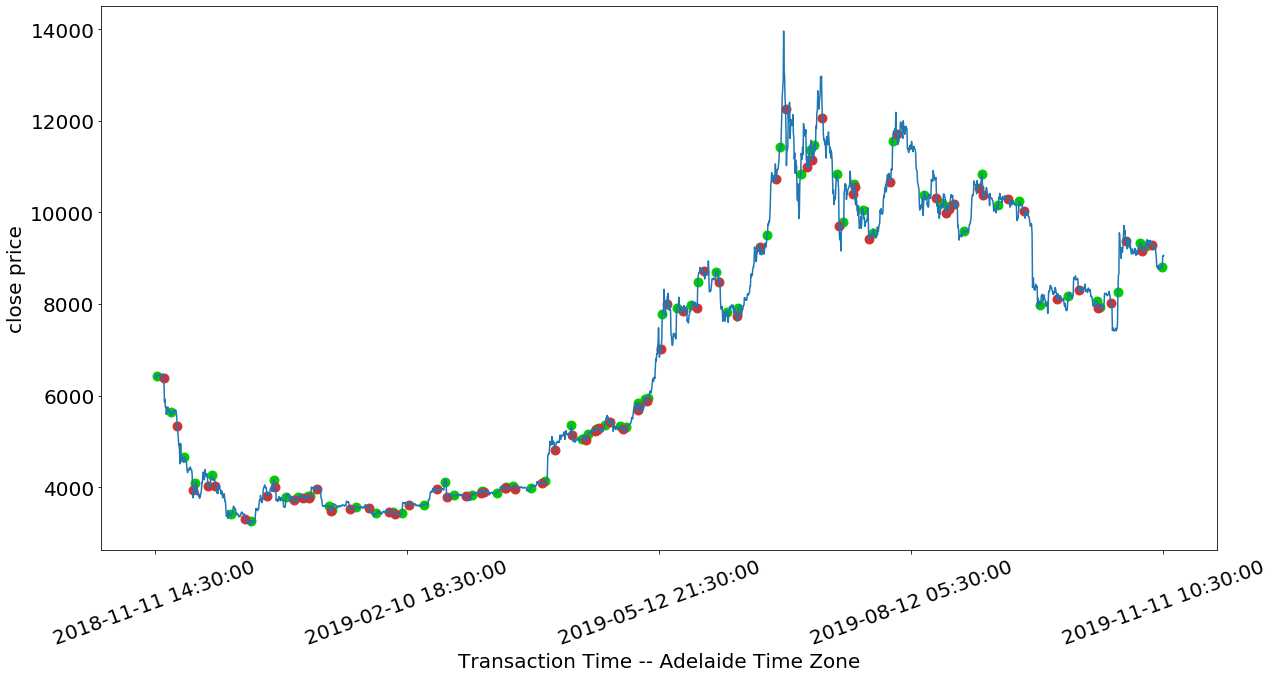

In [59]:
record = {}
run_bot('4h','4 hour','1 year ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2018-11-11 16:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 364
Current Money:0.0029849599998215126
Current Bitcoin: 0.092572
Current BNB: 2.372675511946252
Return on Investment is:49.407645839835986%
Current Total Assert is: 881.5051104550323


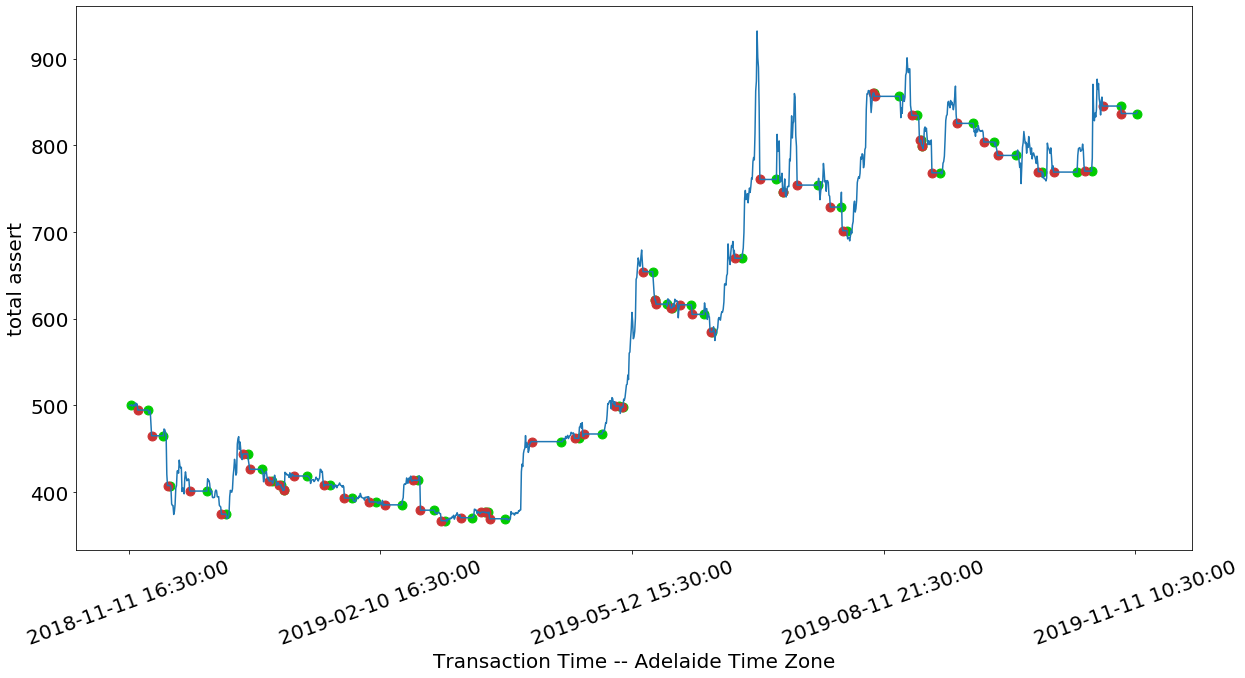

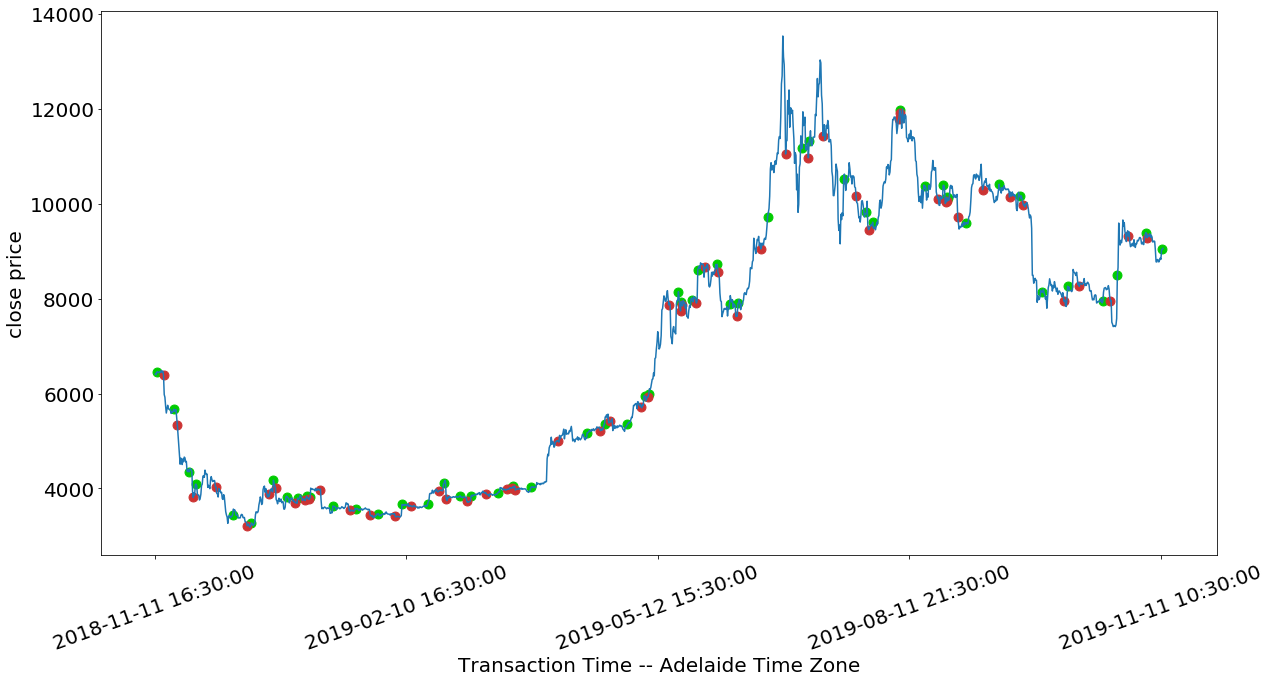

In [60]:
record = {}
run_bot('6h','6 hour','1 year ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2018-11-11 22:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 364
Current Money:783.8334928199994
Current Bitcoin: 0
Current BNB: 3.5653394132004177
Return on Investment is:43.73044106061135%
Current Total Assert is: 848.009602257607


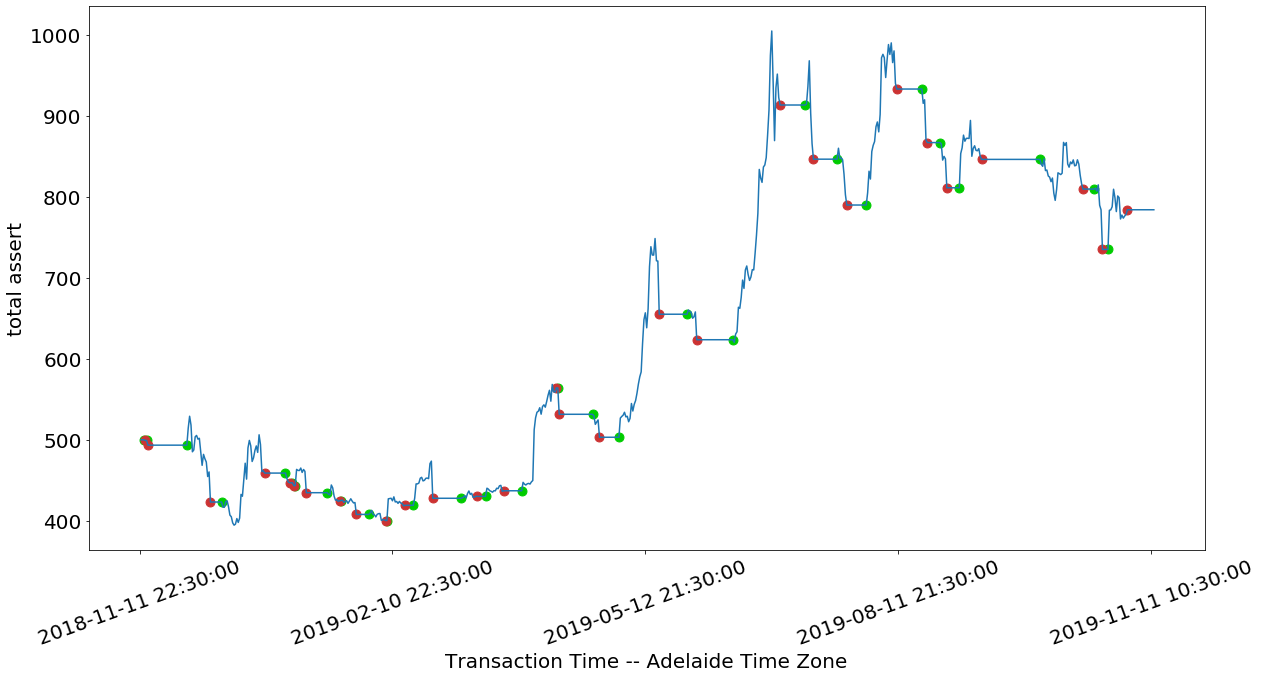

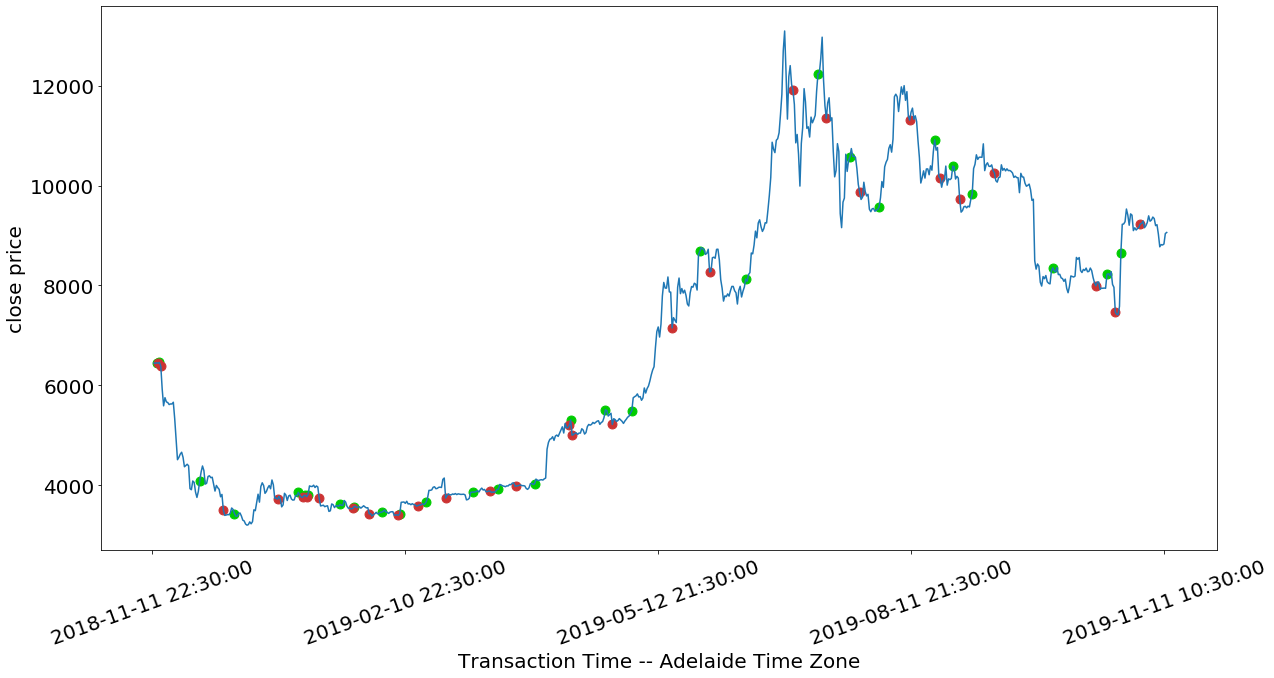

In [61]:
record = {}
run_bot('12h','12 hour','1 year ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2018-11-12 10:30:00
Investment End Time:2019-11-11 10:30:00
Investment Periods: 364
Current Money:732.92918248
Current Bitcoin: 0
Current BNB: 4.24744776526
Return on Investment is:37.18360038214915%
Current Total Assert is: 809.38324225468


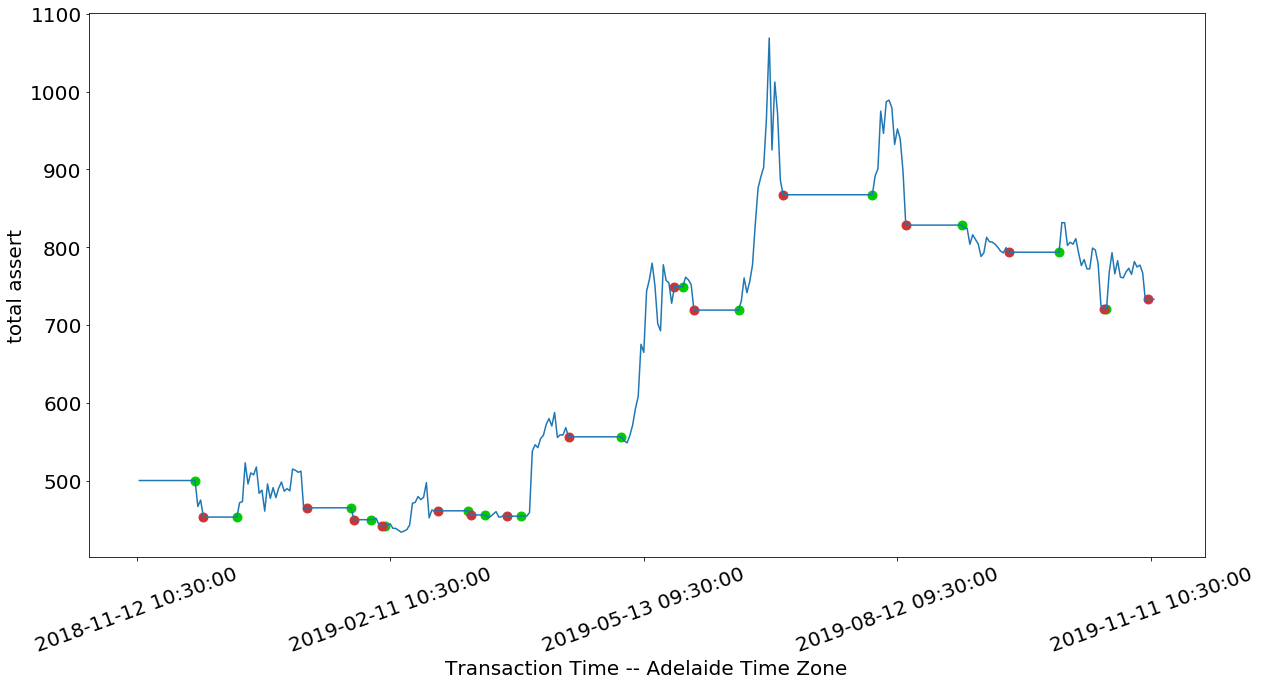

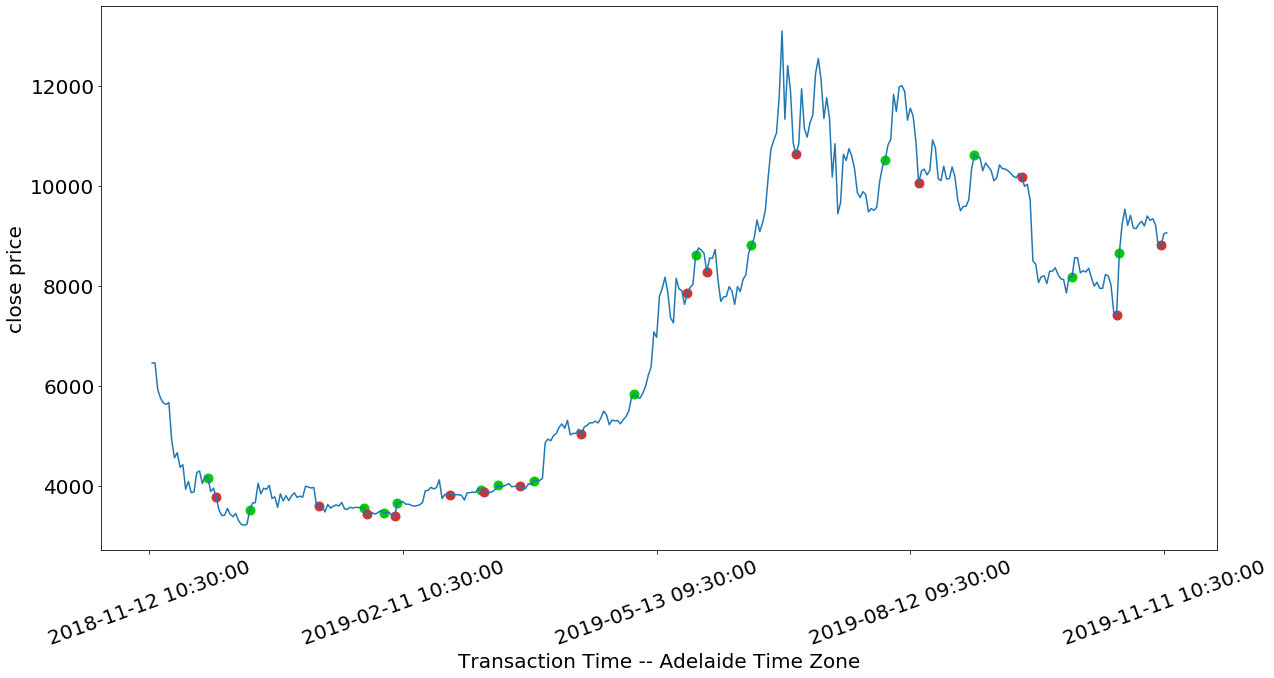

In [62]:
record = {}
run_bot('1d','1 day','1 year ago UTC',record)